# CEE 501 - Final Project: Building Energy Benchmarking in Seattle
# Github Repository: [Link](https://github.com/Mounusha25/CEE501_Final_project)
## Mounusha Metti & Kashish patel

## PHASE 1: Import Libraries

In [98]:
# Core libraries
import pandas as pd
import numpy as np
import warnings

# Scikit-learn preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Regression models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

# Classification models
from sklearn.ensemble import RandomForestClassifier

# Clustering Analysis
from sklearn.cluster import KMeans

from scipy import stats

# Hyperparameter tuning for Random Forest
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
warnings.filterwarnings('ignore')
print("ALL libraries imported")

ALL libraries imported


In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("Visualization libraries imported")

Visualization libraries imported


In [3]:
# Importing advanced libraries
import xgboost as xgb
import shap
print("Advanced libraries imported")

Advanced libraries imported


## PHASE 2: Load and Merge Data (2015 + 2016)

In [4]:
# Load 2015 data
print("Loading 2015 dataset...")
df_2015 = pd.read_csv('2015-building-energy-benchmarking.csv', encoding='latin-1', low_memory=False)
print(f"Loaded: {df_2015.shape[0]:,} buildings × {df_2015.shape[1]} features")

Loading 2015 dataset...
Loaded: 3,340 buildings × 47 features


In [5]:
# Load 2016 data
print("Loading 2016 dataset...")
df_2016 = pd.read_csv('2016-building-energy-benchmarking.csv', encoding='latin-1', low_memory=False)
print(f"Loaded: {df_2016.shape[0]:,} buildings × {df_2016.shape[1]} features")

Loading 2016 dataset...
Loaded: 3,376 buildings × 46 features


In [6]:
# Identify building ID column
if 'OSEBuildingID' in df_2015.columns and 'OSEBuildingID' in df_2016.columns:
    building_id = 'OSEBuildingID'
else:
    building_id = 'BuildingID'
print(f"Using '{building_id}' as identifier")

Using 'OSEBuildingID' as identifier


### 🔍 Building Overlap Analysis

**Purpose**: Identify buildings that appear in both 2015 and 2016 datasets to enable temporal analysis.

**Why This Matters**:
- **Temporal Features**: We need the same buildings across years to calculate year-over-year changes (Δ EUI, Δ Electricity, etc.)
- **Model Target**: Our goal is predicting 2016 EUI based on 2015 performance
- **Data Quality**: Understanding dataset continuity helps identify buildings that dropped out or were newly added

**Expected Outcome**: High overlap (>90%) indicates strong data continuity for reliable temporal modeling.

In [7]:
# Analyze overlap
buildings_2015 = set(df_2015[building_id].dropna())
buildings_2016 = set(df_2016[building_id].dropna())
overlap = buildings_2015.intersection(buildings_2016)

print("\nOverlap Analysis:")
print(f"  2015 only: {len(buildings_2015 - buildings_2016):,}")
print(f"  2016 only: {len(buildings_2016 - buildings_2015):,}")
print(f"  Both years: {len(overlap):,} ({len(overlap)/len(buildings_2015)*100:.1f}%)")


Overlap Analysis:
  2015 only: 56
  2016 only: 92
  Both years: 3,284 (98.3%)


In [8]:
# Select key features
key_features = [
    building_id, 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 
    'GHGEmissions(MetricTonsCO2e)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 
    'SteamUse(kBtu)', 'PropertyGFATotal', 'YearBuilt', 'NumberofFloors',
    'BuildingType', 'PrimaryPropertyType', 'ENERGYSTARScore'
]

key_features_2015 = [c for c in key_features if c in df_2015.columns]
key_features_2016 = [c for c in key_features if c in df_2016.columns]
print(f"Selected {len(key_features_2015)} features")

Selected 13 features


---
## COMPREHENSIVE EDA - 2015 DATASET

Detailed exploratory data analysis before merging

In [9]:
# Dataset Overview - 2015
print("2015 DATASET OVERVIEW")

print(f"\nShape: {df_2015.shape[0]:,} rows × {df_2015.shape[1]} columns")

print("\nColumn Data Types:")
dtype_counts = df_2015.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"{dtype}: {count} columns")

print("\nFirst 5 rows:")
print(df_2015.head())

2015 DATASET OVERVIEW

Shape: 3,340 rows × 47 columns

Column Data Types:
float64: 23 columns
object: 15 columns
int64: 9 columns

First 5 rows:
   OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  \
0   MAYFLOWER PARK HOTEL                     659000030   
1        PARAMOUNT HOTEL                     659000220   
2           WESTIN HOTEL                     659000475   
3              HOTEL MAX                     659000640   
4  WARWICK SEATTLE HOTEL                     659000970   

                                            Location  CouncilDistrictCode  \
0  {'latitude': '47.61219025', '

MISSING VALUES ANALYSIS - 2015

 Found 32 columns with missing values

Top 15 columns with highest missing values:
                           Column  Missing_Count  Missing_Percentage
                          Comment           3327               99.61
                          Outlier           3256               97.49
         YearsENERGYSTARCertified           3230               96.71
           City Council Districts           3127               93.62
               2010 Census Tracts           3116               93.29
      ThirdLargestPropertyUseType           2780               83.23
   ThirdLargestPropertyUseTypeGFA           2780               83.23
     SecondLargestPropertyUseType           1781               53.32
  SecondLargestPropertyUseTypeGFA           1781               53.32
                  ENERGYSTARScore            780               23.35
        LargestPropertyUseTypeGFA            136                4.07
           LargestPropertyUseType            136         

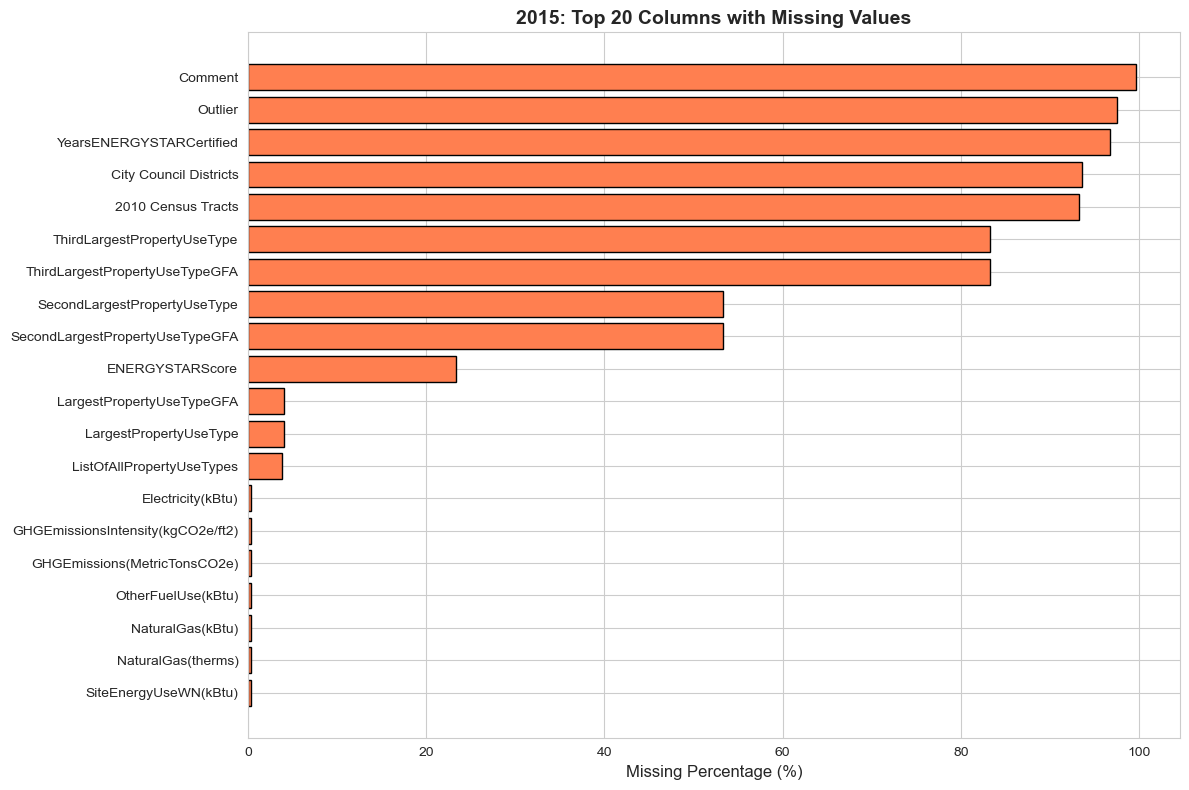

In [10]:
# Missing Values Analysis - 2015
print("MISSING VALUES ANALYSIS - 2015")

missing_2015 = pd.DataFrame({
    'Column': df_2015.columns,
    'Missing_Count': df_2015.isnull().sum(),
    'Missing_Percentage': (df_2015.isnull().sum() / len(df_2015) * 100).round(2)
})
missing_2015 = missing_2015[missing_2015['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_2015) > 0:
    print(f"\n Found {len(missing_2015)} columns with missing values")
    print("\nTop 15 columns with highest missing values:")
    print(missing_2015.head(15).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    top_missing = missing_2015.head(20)
    plt.barh(top_missing['Column'], top_missing['Missing_Percentage'], color='coral', edgecolor='black')
    plt.xlabel('Missing Percentage (%)', fontsize=12)
    plt.title('2015: Top 20 Columns with Missing Values', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("\n No missing values found!")

In [11]:
# Target Variable Analysis - 2015 Site EUI
print("TARGET VARIABLE: Site EUI (kBtu/sf) - 2015")

target = 'SiteEUI(kBtu/sf)'
target_2015 = df_2015[target].dropna()

print("\nSite EUI Statistics:")
print(f"  Valid values: {len(target_2015):,} / {len(df_2015):,} ({len(target_2015)/len(df_2015)*100:.1f}%)")
print(f"  Mean: {target_2015.mean():.2f} kBtu/sf")
print(f"  Median: {target_2015.median():.2f} kBtu/sf")
print(f"  Std Dev: {target_2015.std():.2f} kBtu/sf")
print(f"  Min: {target_2015.min():.2f} kBtu/sf")
print(f"  Max: {target_2015.max():.2f} kBtu/sf")
print(f"  25th percentile: {target_2015.quantile(0.25):.2f} kBtu/sf")
print(f"  75th percentile: {target_2015.quantile(0.75):.2f} kBtu/sf")

# Outliers
Q1 = target_2015.quantile(0.25)
Q3 = target_2015.quantile(0.75)
IQR = Q3 - Q1
outliers_2015 = target_2015[(target_2015 < Q1 - 1.5*IQR) | (target_2015 > Q3 + 1.5*IQR)]
print(f"\n  Outliers (IQR): {len(outliers_2015)} ({len(outliers_2015)/len(target_2015)*100:.1f}%)")
print(f"  High outliers (>{(Q3 + 1.5*IQR):.1f}): {len(target_2015[target_2015 > Q3 + 1.5*IQR])}")

# Distribution metrics
skewness_2015 = target_2015.skew()
print("\nDistribution:")
print(f"  Skewness: {skewness_2015:.2f} {'(right-skewed)' if skewness_2015 > 0 else '(left-skewed)'}")
print(f"  Kurtosis: {target_2015.kurtosis():.2f}")
if skewness_2015 > 1:
    print("  High positive skew - log transformation recommended")

TARGET VARIABLE: Site EUI (kBtu/sf) - 2015

Site EUI Statistics:
  Valid values: 3,330 / 3,340 (99.7%)
  Mean: 53.63 kBtu/sf
  Median: 37.40 kBtu/sf
  Std Dev: 53.89 kBtu/sf
  Min: 0.00 kBtu/sf
  Max: 800.60 kBtu/sf
  25th percentile: 27.30 kBtu/sf
  75th percentile: 59.88 kBtu/sf

  Outliers (IQR): 253 (7.6%)
  High outliers (>108.7): 253

Distribution:
  Skewness: 4.70 (right-skewed)
  Kurtosis: 35.37
  High positive skew - log transformation recommended


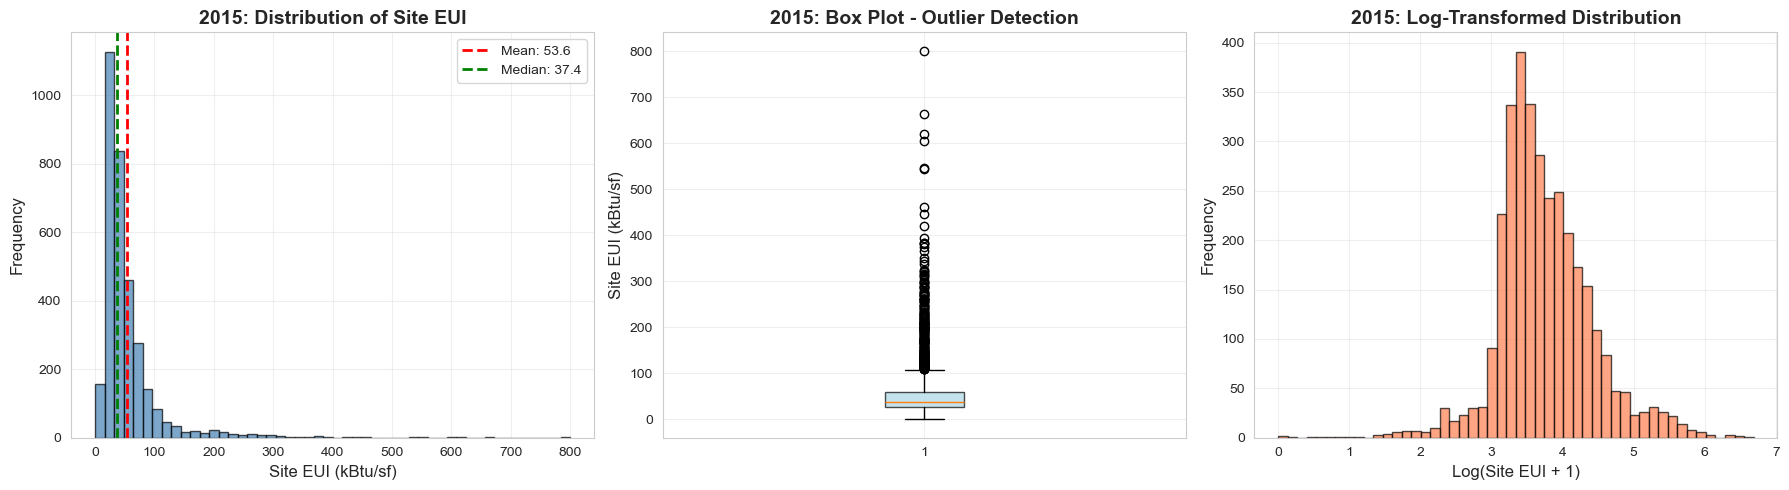

In [12]:
# Visualize Target Distribution - 2015
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(target_2015, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(target_2015.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {target_2015.mean():.1f}')
axes[0].axvline(target_2015.median(), color='green', linestyle='--', linewidth=2, 
                label=f'Median: {target_2015.median():.1f}')
axes[0].set_xlabel('Site EUI (kBtu/sf)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('2015: Distribution of Site EUI', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(target_2015, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Site EUI (kBtu/sf)', fontsize=12)
axes[1].set_title('2015: Box Plot - Outlier Detection', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Log-transformed
log_target_2015 = np.log1p(target_2015)
axes[2].hist(log_target_2015, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[2].set_xlabel('Log(Site EUI + 1)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('2015: Log-Transformed Distribution', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Building Type Analysis - 2015
print("BUILDING TYPE & PROPERTY TYPE ANALYSIS - 2015")

print("\nBuilding Type Distribution:")
print(df_2015['BuildingType'].value_counts())

print("\nPrimary Property Type (Top 10):")
print(df_2015['PrimaryPropertyType'].value_counts().head(10))

# EUI statistics by building type
print("\nAverage Site EUI by Building Type:")
building_eui_2015 = df_2015.groupby('BuildingType')[target].agg(['count', 'mean', 'median', 'std']).round(2)
building_eui_2015 = building_eui_2015.sort_values('mean', ascending=False)
print(building_eui_2015)

BUILDING TYPE & PROPERTY TYPE ANALYSIS - 2015

Building Type Distribution:
BuildingType
NonResidential          1461
Multifamily LR (1-4)    1029
Multifamily MR (5-9)     554
Multifamily HR (10+)     107
SPS-District K-12         99
Nonresidential COS        68
Campus                    22
Name: count, dtype: int64

Primary Property Type (Top 10):
PrimaryPropertyType
Low-Rise Multifamily           998
Mid-Rise Multifamily           539
Small- and Mid-Sized Office    297
Other                          258
Non-Refrigerated Warehouse     187
Large Office                   171
K-12 School                    136
Mixed Use Property             126
High-Rise Multifamily          103
Retail Store                   100
Name: count, dtype: int64

Average Site EUI by Building Type:
                      count    mean  median    std
BuildingType                                      
Campus                   22  105.05   86.35  65.37
Nonresidential COS       68   89.16   76.90  56.87
NonResidential

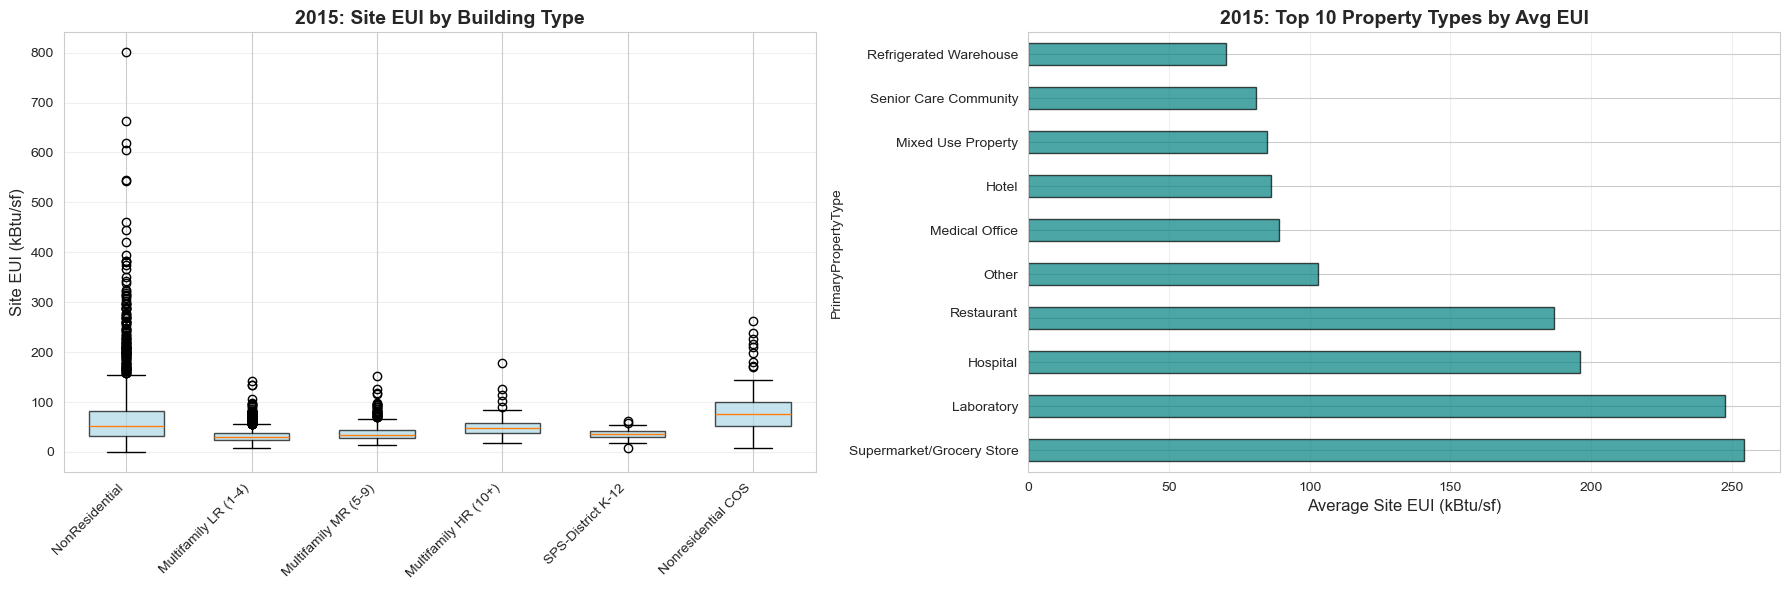

In [14]:
# Visualize EUI by Building Type - 2015
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Box plot by Building Type
building_types_2015 = df_2015.groupby('BuildingType')[target].count().sort_values(ascending=False).head(6).index
df_plot_2015 = df_2015[df_2015['BuildingType'].isin(building_types_2015)]

for i, btype in enumerate(building_types_2015):
    data = df_plot_2015[df_plot_2015['BuildingType'] == btype][target].dropna()
    axes[0].boxplot([data], positions=[i+1], widths=0.6, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7))
    
axes[0].set_xticks(range(1, len(building_types_2015)+1))
axes[0].set_xticklabels(building_types_2015, rotation=45, ha='right')
axes[0].set_ylabel('Site EUI (kBtu/sf)', fontsize=12)
axes[0].set_title('2015: Site EUI by Building Type', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Average EUI by Property Type (Top 10)
property_eui_2015 = df_2015.groupby('PrimaryPropertyType')[target].agg(['mean', 'count']).sort_values('mean', ascending=False).head(10)
property_eui_2015['mean'].plot(kind='barh', ax=axes[1], color='teal', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Average Site EUI (kBtu/sf)', fontsize=12)
axes[1].set_title('2015: Top 10 Property Types by Avg EUI', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Feature Engineering - 2015
print("INITIAL FEATURE ENGINEERING - 2015")

# Building Age
df_2015['BuildingAge'] = 2015 - df_2015['YearBuilt']
print("\nBuilding Age:")
print(f"  Average: {df_2015['BuildingAge'].mean():.1f} years")
print(f"  Range: {df_2015['BuildingAge'].min():.0f} - {df_2015['BuildingAge'].max():.0f} years")

# Size Categories
df_2015['SizeCategory'] = pd.cut(df_2015['PropertyGFATotal'],
                                  bins=[0, 25000, 50000, 100000, float('inf')],
                                  labels=['Small (<25k)', 'Medium (25-50k)', 
                                         'Large (50-100k)', 'Very Large (>100k)'])
print("\nSize Distribution:")
print(df_2015['SizeCategory'].value_counts().sort_index())

# Parking Ratio
df_2015['ParkingRatio'] = df_2015['PropertyGFAParking'] / df_2015['PropertyGFATotal']
print("\nParking Ratio:")
print(f"  Average: {df_2015['ParkingRatio'].mean():.2%}")
print(f"  Buildings with parking: {(df_2015['PropertyGFAParking'] > 0).sum():,} ({(df_2015['PropertyGFAParking'] > 0).sum()/len(df_2015)*100:.1f}%)")

# ENERGY STAR
energy_star_2015 = df_2015['ENERGYSTARScore'].notna().sum()
print("\nENERGY STAR:")
print(f"  Buildings with score: {energy_star_2015:,} ({energy_star_2015/len(df_2015)*100:.1f}%)")
if energy_star_2015 > 0:
    print(f"  Avg score: {df_2015['ENERGYSTARScore'].mean():.1f}")
    print(f"  Avg EUI (with ENERGY STAR): {df_2015[df_2015['ENERGYSTARScore'].notna()][target].mean():.1f}")
    print(f"  Avg EUI (without ENERGY STAR): {df_2015[df_2015['ENERGYSTARScore'].isna()][target].mean():.1f}")

INITIAL FEATURE ENGINEERING - 2015

Building Age:
  Average: 47.4 years
  Range: 0 - 115 years

Size Distribution:
SizeCategory
Small (<25k)           550
Medium (25-50k)       1323
Large (50-100k)        746
Very Large (>100k)     721
Name: count, dtype: int64

Parking Ratio:
  Average: 7.24%
  Buildings with parking: 922 (27.6%)

ENERGY STAR:
  Buildings with score: 2,560 (76.6%)
  Avg score: 67.9
  Avg EUI (with ENERGY STAR): 48.6
  Avg EUI (without ENERGY STAR): 70.5


CORRELATION ANALYSIS - 2015


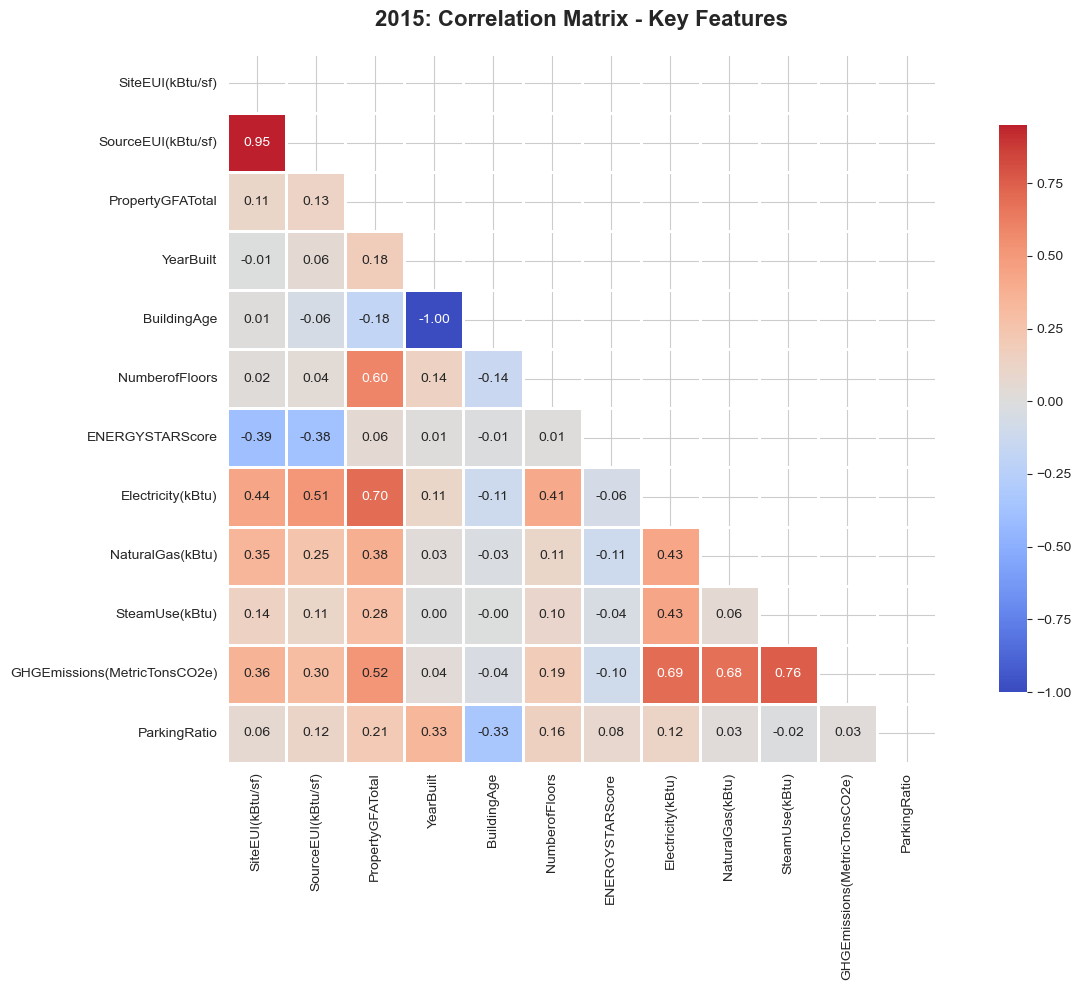


Features Most Correlated with Site EUI (2015):
SourceEUI(kBtu/sf)              0.950709
Electricity(kBtu)               0.440049
GHGEmissions(MetricTonsCO2e)    0.360583
NaturalGas(kBtu)                0.348296
SteamUse(kBtu)                  0.136801
PropertyGFATotal                0.106480
ParkingRatio                    0.064272
NumberofFloors                  0.015420
BuildingAge                     0.008990
YearBuilt                      -0.008990
ENERGYSTARScore                -0.394656
Name: SiteEUI(kBtu/sf), dtype: float64


In [16]:
# Correlation Analysis - 2015
print("CORRELATION ANALYSIS - 2015")

correlation_features = [
    'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'PropertyGFATotal',
    'YearBuilt', 'BuildingAge', 'NumberofFloors', 'ENERGYSTARScore',
    'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)',
    'GHGEmissions(MetricTonsCO2e)', 'ParkingRatio'
]

corr_df_2015 = df_2015[correlation_features].copy()
correlation_matrix_2015 = corr_df_2015.corr()

# Heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix_2015, dtype=bool))
sns.heatmap(correlation_matrix_2015, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('2015: Correlation Matrix - Key Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Top correlations with Site EUI
print("\nFeatures Most Correlated with Site EUI (2015):")
eui_corr_2015 = correlation_matrix_2015['SiteEUI(kBtu/sf)'].drop('SiteEUI(kBtu/sf)').sort_values(ascending=False)
print(eui_corr_2015)

---
## COMPREHENSIVE EDA - 2016 DATASET

Detailed exploratory data analysis of 2016 data

In [17]:
# Dataset Overview - 2016
print("2016 DATASET OVERVIEW")


print(f"\nShape: {df_2016.shape[0]:,} rows × {df_2016.shape[1]} columns")
print(f"Memory: {df_2016.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn Data Types:")
dtype_counts_2016 = df_2016.dtypes.value_counts()
for dtype, count in dtype_counts_2016.items():
    print(f"{dtype}: {count} columns")

print("\nFirst 5 rows:")
print(df_2016.head())

2016 DATASET OVERVIEW

Shape: 3,376 rows × 46 columns
Memory: 3.47 MB

Column Data Types:
float64: 22 columns
object: 15 columns
int64: 8 columns
bool: 1 columns

First 5 rows:
   OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Se

MISSING VALUES ANALYSIS - 2016

Found 26 columns with missing values

Top 15 columns with highest missing values:
                         Column  Missing_Count  Missing_Percentage
                       Comments           3376              100.00
                        Outlier           3344               99.05
       YearsENERGYSTARCertified           3257               96.48
 ThirdLargestPropertyUseTypeGFA           2780               82.35
    ThirdLargestPropertyUseType           2780               82.35
   SecondLargestPropertyUseType           1697               50.27
SecondLargestPropertyUseTypeGFA           1697               50.27
                ENERGYSTARScore            843               24.97
         LargestPropertyUseType             20                0.59
      LargestPropertyUseTypeGFA             20                0.59
                        ZipCode             16                0.47
                 SteamUse(kBtu)              9                0.27
              T

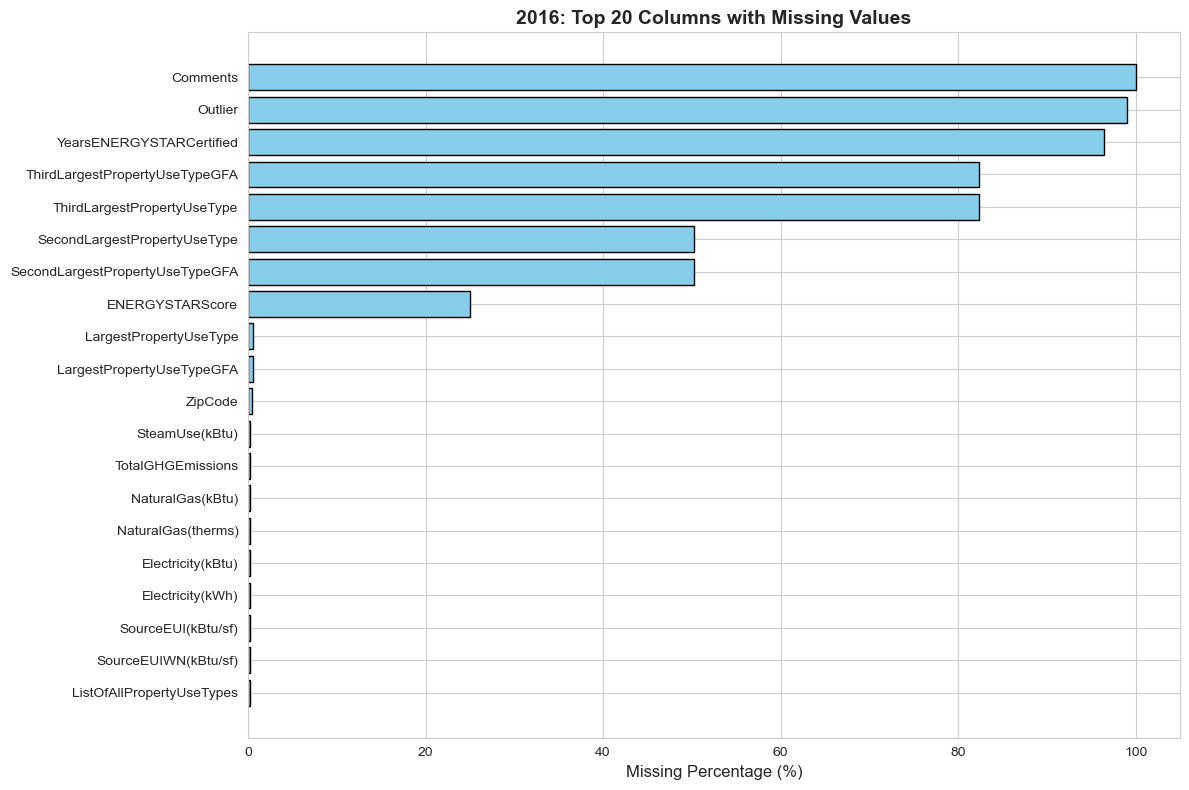

In [18]:
# Missing Values Analysis - 2016
print("MISSING VALUES ANALYSIS - 2016")

missing_2016 = pd.DataFrame({
    'Column': df_2016.columns,
    'Missing_Count': df_2016.isnull().sum(),
    'Missing_Percentage': (df_2016.isnull().sum() / len(df_2016) * 100).round(2)
})
missing_2016 = missing_2016[missing_2016['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_2016) > 0:
    print(f"\nFound {len(missing_2016)} columns with missing values")
    print("\nTop 15 columns with highest missing values:")
    print(missing_2016.head(15).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    top_missing_2016 = missing_2016.head(20)
    plt.barh(top_missing_2016['Column'], top_missing_2016['Missing_Percentage'], color='skyblue', edgecolor='black')
    plt.xlabel('Missing Percentage (%)', fontsize=12)
    plt.title('2016: Top 20 Columns with Missing Values', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values found!")

In [19]:
# Target Variable Analysis - 2016 Site EUI
print("TARGET VARIABLE: Site EUI (kBtu/sf) - 2016")

target_2016 = df_2016[target].dropna()

print("\nSite EUI Statistics:")
print(f"  Valid values: {len(target_2016):,} / {len(df_2016):,} ({len(target_2016)/len(df_2016)*100:.1f}%)")
print(f"  Mean: {target_2016.mean():.2f} kBtu/sf")
print(f"  Median: {target_2016.median():.2f} kBtu/sf")
print(f"  Std Dev: {target_2016.std():.2f} kBtu/sf")
print(f"  Min: {target_2016.min():.2f} kBtu/sf")
print(f"  Max: {target_2016.max():.2f} kBtu/sf")
print(f"  25th percentile: {target_2016.quantile(0.25):.2f} kBtu/sf")
print(f"  75th percentile: {target_2016.quantile(0.75):.2f} kBtu/sf")

# Outliers
Q1_2016 = target_2016.quantile(0.25)
Q3_2016 = target_2016.quantile(0.75)
IQR_2016 = Q3_2016 - Q1_2016
outliers_2016 = target_2016[(target_2016 < Q1_2016 - 1.5*IQR_2016) | (target_2016 > Q3_2016 + 1.5*IQR_2016)]
print(f"\n  Outliers (IQR): {len(outliers_2016)} ({len(outliers_2016)/len(target_2016)*100:.1f}%)")
print(f"  High outliers (>{(Q3_2016 + 1.5*IQR_2016):.1f}): {len(target_2016[target_2016 > Q3_2016 + 1.5*IQR_2016])}")

# Distribution metrics
skewness_2016 = target_2016.skew()
print("\nDistribution:")
print(f"  Skewness: {skewness_2016:.2f} {'(right-skewed)' if skewness_2016 > 0 else '(left-skewed)'}")
print(f"  Kurtosis: {target_2016.kurtosis():.2f}")

# Compare with 2015
print("\nComparison with 2015:")
print(f"  Mean change: {target_2016.mean() - target_2015.mean():+.2f} kBtu/sf")
print(f"  Median change: {target_2016.median() - target_2015.median():+.2f} kBtu/sf")

TARGET VARIABLE: Site EUI (kBtu/sf) - 2016

Site EUI Statistics:
  Valid values: 3,369 / 3,376 (99.8%)
  Mean: 54.73 kBtu/sf
  Median: 38.60 kBtu/sf
  Std Dev: 56.27 kBtu/sf
  Min: 0.00 kBtu/sf
  Max: 834.40 kBtu/sf
  25th percentile: 27.90 kBtu/sf
  75th percentile: 60.40 kBtu/sf

  Outliers (IQR): 264 (7.8%)
  High outliers (>109.2): 264

Distribution:
  Skewness: 4.98 (right-skewed)
  Kurtosis: 39.99

Comparison with 2015:
  Mean change: +1.11 kBtu/sf
  Median change: +1.20 kBtu/sf


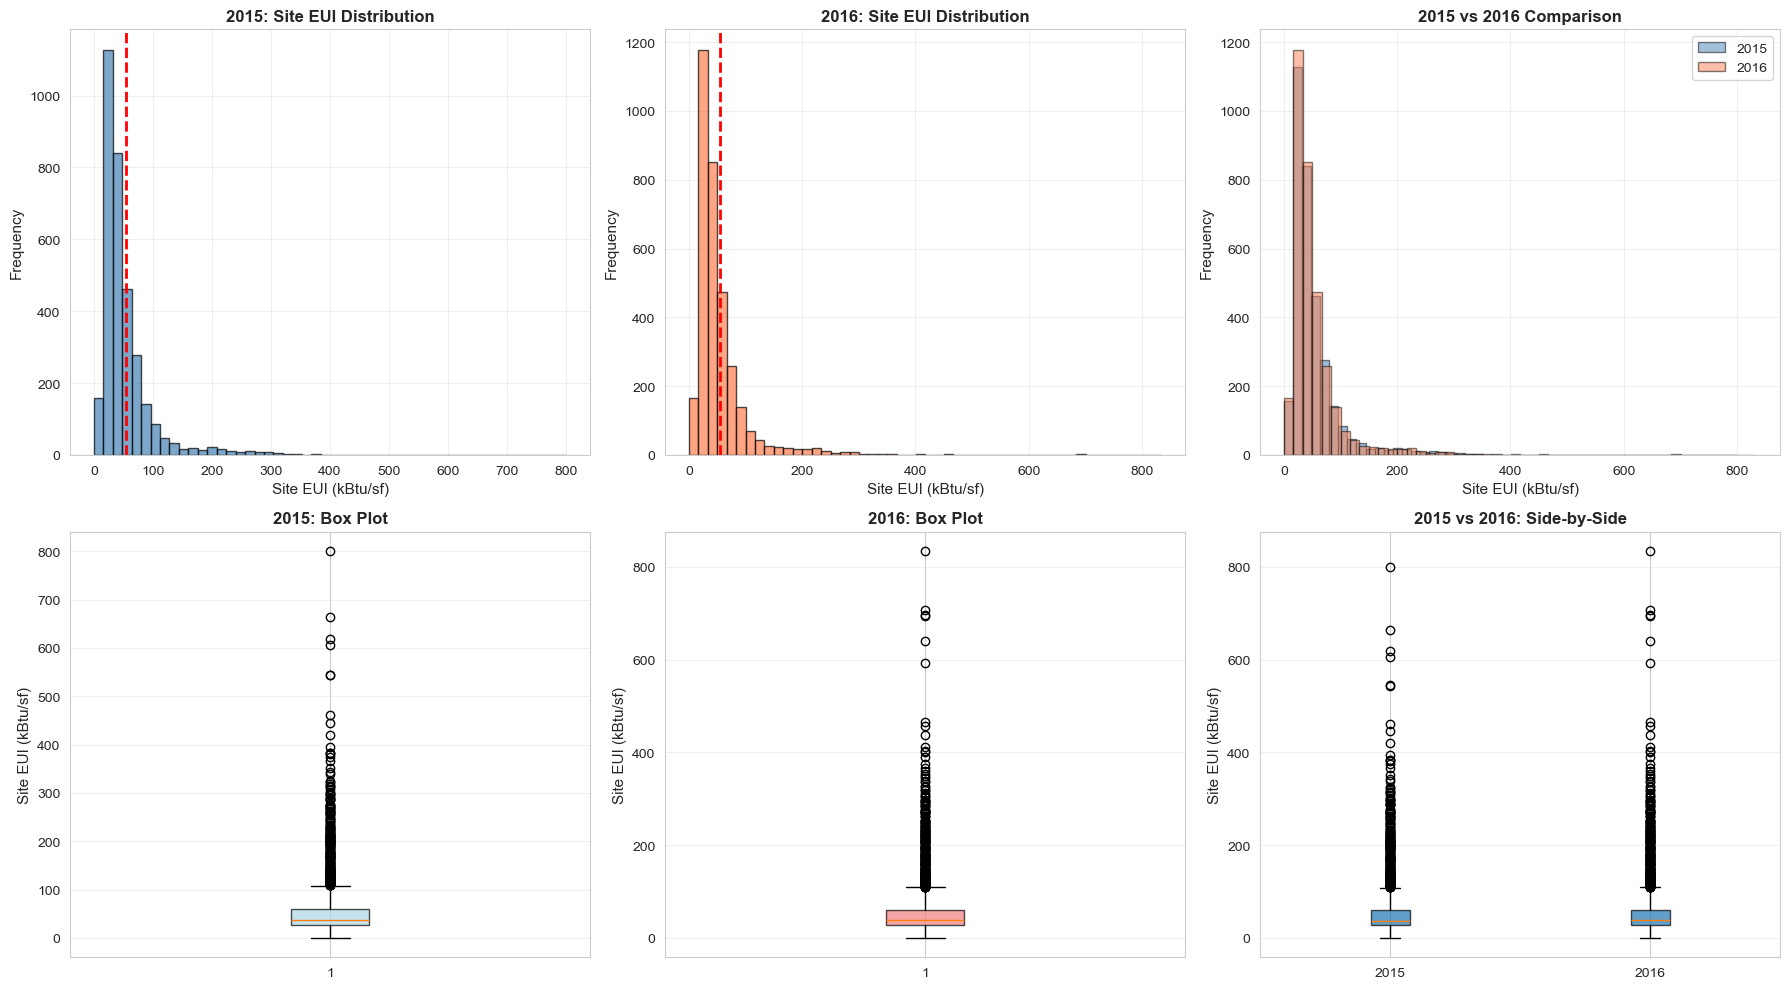

In [20]:
# Visualize Target Distribution - 2016 vs 2015
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 2015 Histogram
axes[0, 0].hist(target_2015, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(target_2015.mean(), color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Site EUI (kBtu/sf)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('2015: Site EUI Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 2016 Histogram
axes[0, 1].hist(target_2016, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(target_2016.mean(), color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Site EUI (kBtu/sf)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('2016: Site EUI Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Comparison
axes[0, 2].hist(target_2015, bins=50, alpha=0.5, label='2015', color='steelblue', edgecolor='black')
axes[0, 2].hist(target_2016, bins=50, alpha=0.5, label='2016', color='coral', edgecolor='black')
axes[0, 2].set_xlabel('Site EUI (kBtu/sf)', fontsize=11)
axes[0, 2].set_ylabel('Frequency', fontsize=11)
axes[0, 2].set_title('2015 vs 2016 Comparison', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Box plots
axes[1, 0].boxplot(target_2015, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1, 0].set_ylabel('Site EUI (kBtu/sf)', fontsize=11)
axes[1, 0].set_title('2015: Box Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

axes[1, 1].boxplot(target_2016, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightcoral', alpha=0.7))
axes[1, 1].set_ylabel('Site EUI (kBtu/sf)', fontsize=11)
axes[1, 1].set_title('2016: Box Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

# Side by side box plot
axes[1, 2].boxplot([target_2015, target_2016], labels=['2015', '2016'],
                    patch_artist=True,
                    boxprops=dict(alpha=0.7))
axes[1, 2].set_ylabel('Site EUI (kBtu/sf)', fontsize=11)
axes[1, 2].set_title('2015 vs 2016: Side-by-Side', fontsize=12, fontweight='bold')
axes[1, 2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [21]:
# Building Type Analysis - 2016
print("BUILDING TYPE & PROPERTY TYPE ANALYSIS - 2016")

print("\nBuilding Type Distribution:")
print(df_2016['BuildingType'].value_counts())

print("\nPrimary Property Type (Top 10):")
print(df_2016['PrimaryPropertyType'].value_counts().head(10))

# EUI statistics by building type
print("\nAverage Site EUI by Building Type:")
building_eui_2016 = df_2016.groupby('BuildingType')[target].agg(['count', 'mean', 'median', 'std']).round(2)
building_eui_2016 = building_eui_2016.sort_values('mean', ascending=False)
print(building_eui_2016)

BUILDING TYPE & PROPERTY TYPE ANALYSIS - 2016

Building Type Distribution:
BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

Primary Property Type (Top 10):
PrimaryPropertyType
Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Name: count, dtype: int64

Average Site EUI by Building Type:
                      count    mean  median    std
BuildingType                                      
Campus                   24  105.79   88.10  65.11
Nonresidential COS       85   93.75 

In [22]:
# Feature Engineering - 2016
print("INITIAL FEATURE ENGINEERING - 2016")

# Building Age
df_2016['BuildingAge'] = 2016 - df_2016['YearBuilt']
print("\nBuilding Age:")
print(f"  Average: {df_2016['BuildingAge'].mean():.1f} years")
print(f"  Range: {df_2016['BuildingAge'].min():.0f} - {df_2016['BuildingAge'].max():.0f} years")

# Size Categories
df_2016['SizeCategory'] = pd.cut(df_2016['PropertyGFATotal'],
                                  bins=[0, 25000, 50000, 100000, float('inf')],
                                  labels=['Small (<25k)', 'Medium (25-50k)', 
                                         'Large (50-100k)', 'Very Large (>100k)'])
print("\nSize Distribution:")
print(df_2016['SizeCategory'].value_counts().sort_index())

# Parking Ratio
df_2016['ParkingRatio'] = df_2016['PropertyGFAParking'] / df_2016['PropertyGFATotal']
print("\nParking Ratio:")
print(f"  Average: {df_2016['ParkingRatio'].mean():.2%}")
print(f"  Buildings with parking: {(df_2016['PropertyGFAParking'] > 0).sum():,} ({(df_2016['PropertyGFAParking'] > 0).sum()/len(df_2016)*100:.1f}%)")

# ENERGY STAR
energy_star_2016 = df_2016['ENERGYSTARScore'].notna().sum()
print("\nENERGY STAR:")
print(f"  Buildings with score: {energy_star_2016:,} ({energy_star_2016/len(df_2016)*100:.1f}%)")
if energy_star_2016 > 0:
    print(f"  Avg score: {df_2016['ENERGYSTARScore'].mean():.1f}")
    print(f"  Avg EUI (with ENERGY STAR): {df_2016[df_2016['ENERGYSTARScore'].notna()][target].mean():.1f}")
    print(f"  Avg EUI (without ENERGY STAR): {df_2016[df_2016['ENERGYSTARScore'].isna()][target].mean():.1f}")

INITIAL FEATURE ENGINEERING - 2016

Building Age:
  Average: 47.4 years
  Range: 1 - 116 years

Size Distribution:
SizeCategory
Small (<25k)           559
Medium (25-50k)       1312
Large (50-100k)        758
Very Large (>100k)     747
Name: count, dtype: int64

Parking Ratio:
  Average: 4.15%
  Buildings with parking: 504 (14.9%)

ENERGY STAR:
  Buildings with score: 2,533 (75.0%)
  Avg score: 67.9
  Avg EUI (with ENERGY STAR): 49.5
  Avg EUI (without ENERGY STAR): 70.5


In [23]:
# Correlation Analysis - 2016
print("CORRELATION ANALYSIS - 2016")

# Select numeric features
numeric_features_2016 = df_2016.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nAnalyzing {len(numeric_features_2016)} numeric features")

# Calculate correlations with target
correlations_2016 = df_2016[numeric_features_2016].corr()[target].sort_values(ascending=False)
print(f"\nTop 10 Correlations with {target}:")
print(correlations_2016.head(10))

print(f"\nBottom 10 Correlations with {target}:")
print(correlations_2016.tail(10))

CORRELATION ANALYSIS - 2016

Analyzing 32 numeric features

Top 10 Correlations with SiteEUI(kBtu/sf):
SiteEUI(kBtu/sf)         1.000000
SiteEUIWN(kBtu/sf)       0.993549
SourceEUI(kBtu/sf)       0.944141
SourceEUIWN(kBtu/sf)     0.940204
GHGEmissionsIntensity    0.730897
SiteEnergyUseWN(kBtu)    0.397474
SiteEnergyUse(kBtu)      0.300966
TotalGHGEmissions        0.286608
Electricity(kWh)         0.285053
Electricity(kBtu)        0.285053
Name: SiteEUI(kBtu/sf), dtype: float64

Bottom 10 Correlations with SiteEUI(kBtu/sf):
Longitude          0.027695
BuildingAge        0.019642
NumberofFloors     0.009351
Latitude          -0.012730
YearBuilt         -0.019642
ZipCode           -0.070757
OSEBuildingID     -0.126495
ENERGYSTARScore   -0.342727
DataYear                NaN
Comments                NaN
Name: SiteEUI(kBtu/sf), dtype: float64


CORRELATION HEATMAP - 2016

Creating correlation heatmap for 11 features


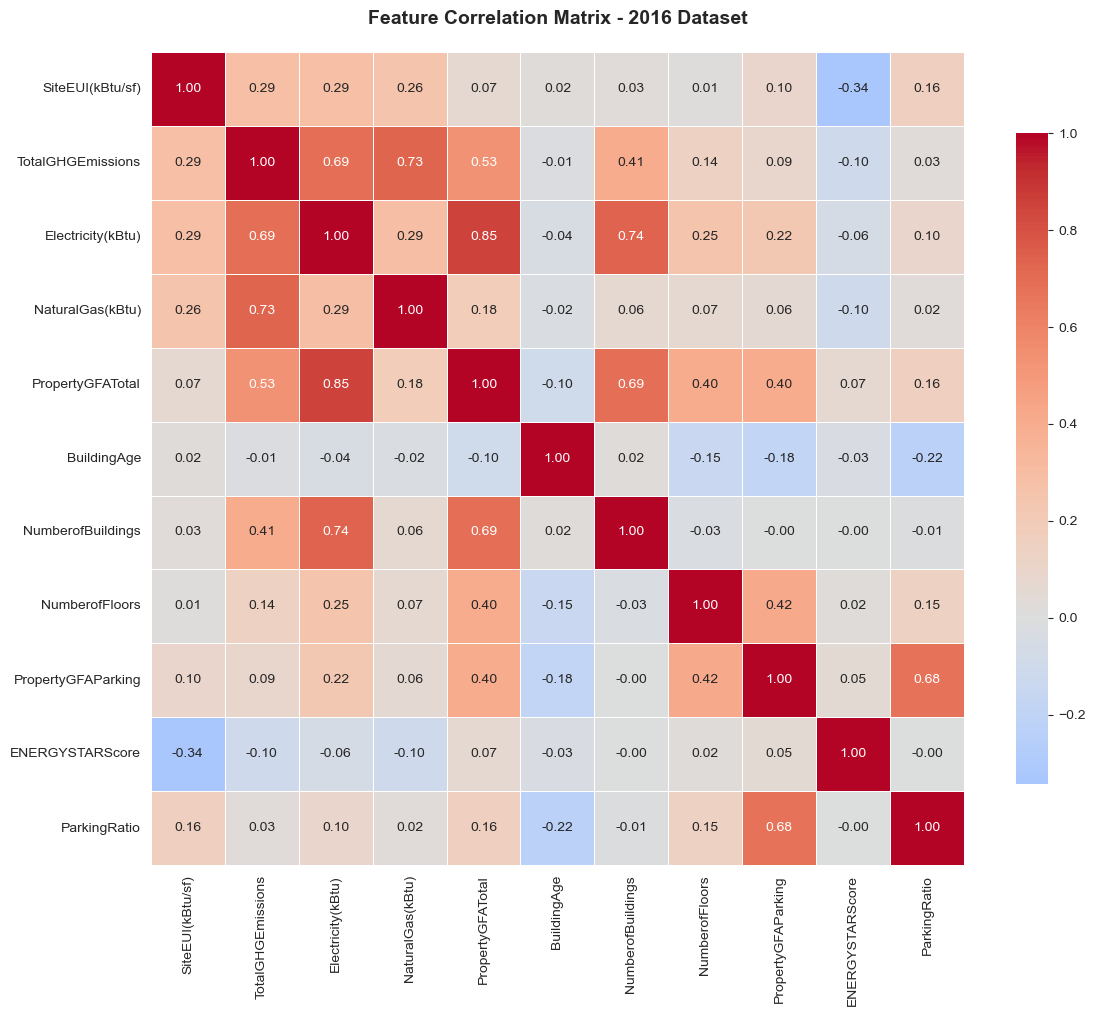


Correlation heatmap displayed


In [24]:
# Visualize Correlation Matrix - 2016
print("CORRELATION HEATMAP - 2016")

# Select key features for visualization
key_features_2016 = ['SiteEUI(kBtu/sf)', 'TotalGHGEmissions', 'Electricity(kBtu)', 
                     'NaturalGas(kBtu)', 'PropertyGFATotal', 'BuildingAge',
                     'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
                     'ENERGYSTARScore', 'ParkingRatio']

# Filter available features
available_features_2016 = [f for f in key_features_2016 if f in df_2016.columns]
print(f"\nCreating correlation heatmap for {len(available_features_2016)} features")

# Create correlation matrix
corr_matrix_2016 = df_2016[available_features_2016].corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_2016, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix - 2016 Dataset', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation heatmap displayed")

In [25]:
# Select key features for temporal merging
# Based on EDA insights, select relevant features for the temporal panel
print("FEATURE SELECTION FOR TEMPORAL MERGING")

key_features = [
    building_id, 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 
    'GHGEmissions(MetricTonsCO2e)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 
    'SteamUse(kBtu)', 'PropertyGFATotal', 'YearBuilt', 'NumberofFloors',
    'BuildingType', 'PrimaryPropertyType', 'ENERGYSTARScore'
]

key_features_2015 = [c for c in key_features if c in df_2015.columns]
key_features_2016 = [c for c in key_features if c in df_2016.columns]

print(f"\nSelected {len(key_features_2015)} features from 2015 dataset")
print(f"Selected {len(key_features_2016)} features from 2016 dataset")
print(f"\nKey features: {', '.join([f for f in key_features if f != building_id])}")

FEATURE SELECTION FOR TEMPORAL MERGING

Selected 13 features from 2015 dataset
Selected 12 features from 2016 dataset

Key features: SiteEUI(kBtu/sf), SourceEUI(kBtu/sf), GHGEmissions(MetricTonsCO2e), Electricity(kBtu), NaturalGas(kBtu), SteamUse(kBtu), PropertyGFATotal, YearBuilt, NumberofFloors, BuildingType, PrimaryPropertyType, ENERGYSTARScore


In [26]:
# Merge datasets on building ID
print("TEMPORAL PANEL CREATION - MERGING 2015 & 2016")

print("\nMerging datasets on common buildings...")
df_merged = df_2015[key_features_2015].merge(
    df_2016[key_features_2016],
    on=building_id,
    how='inner',
    suffixes=('_2015', '_2016')
)

print("\nSuccessfully merged datasets")
print(f"Buildings tracked across both years: {df_merged.shape[0]:,}")
print(f"Total features (with year suffixes): {df_merged.shape[1]}")
print(f"Retention rate: {df_merged.shape[0]/len(buildings_2015)*100:.1f}% of 2015 buildings")

TEMPORAL PANEL CREATION - MERGING 2015 & 2016

Merging datasets on common buildings...

Successfully merged datasets
Buildings tracked across both years: 3,284
Total features (with year suffixes): 24
Retention rate: 98.3% of 2015 buildings


## PHASE 3: Temporal Change Analysis (delta Features)

In [27]:
# Calculate absolute changes
print("Creating temporal change features...")

temporal_features = {
    'SiteEUI(kBtu/sf)': 'delta_SiteEUI',
    'SourceEUI(kBtu/sf)': 'delta_SourceEUI',
    'GHGEmissions(MetricTonsCO2e)': 'delta_GHG',
    'Electricity(kBtu)': 'delta_Electricity',
    'NaturalGas(kBtu)': 'delta_NaturalGas',
    'ENERGYSTARScore': 'delta_ENERGYSTARScore'
}

for orig, delta in temporal_features.items():
    col_2015 = f"{orig}_2015"
    col_2016 = f"{orig}_2016"
    if col_2015 in df_merged.columns and col_2016 in df_merged.columns:
        df_merged[delta] = df_merged[col_2016] - df_merged[col_2015]
        df_merged[f"{delta}_pct"] = (df_merged[delta] / df_merged[col_2015].replace(0, np.nan)) * 100

print(f"Created {len(temporal_features)} change features (delta)")

Creating temporal change features...
Created 6 change features (delta)


In [28]:
# Classify building trajectories
df_merged['Trajectory_Class'] = pd.cut(
    df_merged['delta_SiteEUI_pct'],
    bins=[-np.inf, -5, 5, np.inf],
    labels=['Improving', 'Stable', 'Declining']
)

print("\nTrajectory Distribution:")
print(df_merged['Trajectory_Class'].value_counts())


Trajectory Distribution:
Trajectory_Class
Stable       1705
Declining     954
Improving     609
Name: count, dtype: int64


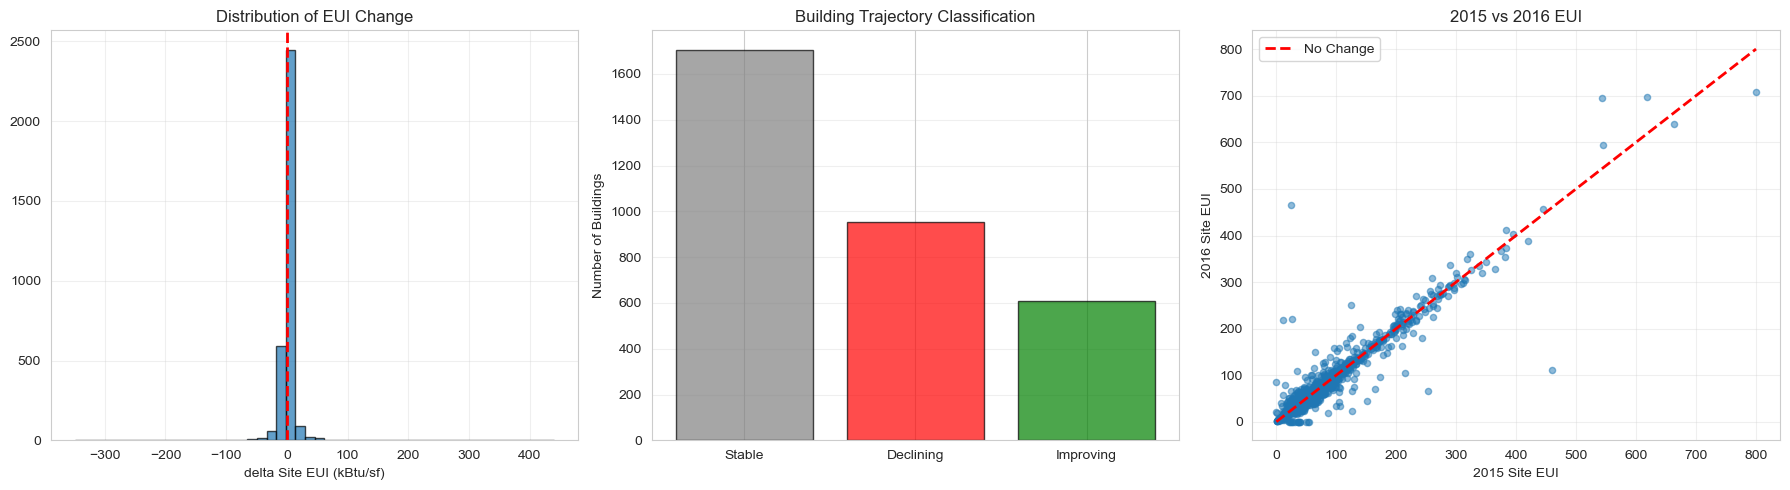

In [29]:
# Visualize temporal changes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution of Site EUI change
axes[0].hist(df_merged['delta_SiteEUI'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('delta Site EUI (kBtu/sf)')
axes[0].set_title('Distribution of EUI Change')
axes[0].grid(alpha=0.3)

# Trajectory counts
traj_counts = df_merged['Trajectory_Class'].value_counts()
colors = {'Improving': 'green', 'Stable': 'gray', 'Declining': 'red'}
bar_colors = [colors[x] for x in traj_counts.index]
axes[1].bar(traj_counts.index, traj_counts.values, color=bar_colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Number of Buildings')
axes[1].set_title('Building Trajectory Classification')
axes[1].grid(axis='y', alpha=0.3)

# 2015 vs 2016 EUI
axes[2].scatter(df_merged['SiteEUI(kBtu/sf)_2015'], df_merged['SiteEUI(kBtu/sf)_2016'], alpha=0.5, s=20)
max_eui = max(df_merged['SiteEUI(kBtu/sf)_2015'].max(), df_merged['SiteEUI(kBtu/sf)_2016'].max())
axes[2].plot([0, max_eui], [0, max_eui], 'r--', linewidth=2, label='No Change')
axes[2].set_xlabel('2015 Site EUI')
axes[2].set_ylabel('2016 Site EUI')
axes[2].set_title('2015 vs 2016 EUI')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## PHASE 4: Advanced Feature Engineering

In [30]:
# Physics-based features
print("Creating physics-based features...")

# Energy efficiency ratio
if 'SourceEUI(kBtu/sf)_2015' in df_merged.columns:
    df_merged['Energy_Efficiency_2015'] = (
        df_merged['SiteEUI(kBtu/sf)_2015'] / 
        df_merged['SourceEUI(kBtu/sf)_2015'].replace(0, np.nan)
    )
    print("Energy efficiency ratio")

# Carbon intensity (check for both possible column names)
ghg_col = None
if 'GHGEmissions(MetricTonsCO2e)_2015' in df_merged.columns:
    ghg_col = 'GHGEmissions(MetricTonsCO2e)_2015'
elif 'TotalGHGEmissions_2015' in df_merged.columns:
    ghg_col = 'TotalGHGEmissions_2015'

if ghg_col and 'PropertyGFATotal_2015' in df_merged.columns:
    df_merged['Carbon_Intensity_2015'] = (
        df_merged[ghg_col] / 
        df_merged['PropertyGFATotal_2015'].replace(0, np.nan)
    )
    print("Carbon intensity")

# Electrification rate
if 'Electricity(kBtu)_2015' in df_merged.columns and 'NaturalGas(kBtu)_2015' in df_merged.columns:
    total_energy = (df_merged['Electricity(kBtu)_2015'].fillna(0) + 
                    df_merged['NaturalGas(kBtu)_2015'].fillna(0))
    df_merged['Electrification_Rate_2015'] = (
        df_merged['Electricity(kBtu)_2015'] / total_energy.replace(0, np.nan)
    )
    print("Electrification rate")

print("\nPhysics-based features created")

Creating physics-based features...
Energy efficiency ratio
Electrification rate

Physics-based features created


In [31]:
# Building characteristics
print("Creating building characteristic features...")

# Building age
if 'YearBuilt_2015' in df_merged.columns:
    df_merged['BuildingAge_2015'] = 2015 - df_merged['YearBuilt_2015']
    print("Building age")

# Size categories
if 'PropertyGFATotal_2015' in df_merged.columns:
    df_merged['SizeCategory'] = pd.cut(
        df_merged['PropertyGFATotal_2015'],
        bins=[0, 25000, 50000, 100000, 250000, np.inf],
        labels=['Small', 'Medium', 'Large', 'Very Large', 'Mega']
    )
    print("Size categories")

# ENERGY STAR indicator
if 'ENERGYSTARScore_2015' in df_merged.columns:
    df_merged['Has_ENERGY_STAR'] = df_merged['ENERGYSTARScore_2015'].notna().astype(int)
    print("ENERGY STAR indicator")

print("\nBuilding characteristics created")

Creating building characteristic features...
Building age
Size categories
ENERGY STAR indicator

Building characteristics created


In [32]:
# Interaction features
print("Creating interaction features...")

# Age × Size interaction
if 'BuildingAge_2015' in df_merged.columns and 'PropertyGFATotal_2015' in df_merged.columns:
    df_merged['Age_Size_Interaction'] = (
        df_merged['BuildingAge_2015'] * np.log1p(df_merged['PropertyGFATotal_2015'])
    )
    print("Age × Size interaction")

# EUI × ENERGY STAR interaction
if 'SiteEUI(kBtu/sf)_2015' in df_merged.columns and 'ENERGYSTARScore_2015' in df_merged.columns:
    df_merged['EUI_ESTAR_Interaction'] = (
        df_merged['SiteEUI(kBtu/sf)_2015'] * df_merged['ENERGYSTARScore_2015'].fillna(0)
    )
    print("EUI × ENERGY STAR interaction")

print("\nInteraction features created")

Creating interaction features...
Age × Size interaction
EUI × ENERGY STAR interaction

Interaction features created


In [33]:
# Normalized energy metrics
print("Creating normalized energy metrics...")

# Electricity per square foot
if 'Electricity(kBtu)_2015' in df_merged.columns and 'PropertyGFATotal_2015' in df_merged.columns:
    df_merged['Electricity_per_sqft'] = (
        df_merged['Electricity(kBtu)_2015'] / df_merged['PropertyGFATotal_2015'].replace(0, np.nan)
    )
    print("Electricity per sqft")

# Natural gas per square foot
if 'NaturalGas(kBtu)_2015' in df_merged.columns and 'PropertyGFATotal_2015' in df_merged.columns:
    df_merged['NaturalGas_per_sqft'] = (
        df_merged['NaturalGas(kBtu)_2015'] / df_merged['PropertyGFATotal_2015'].replace(0, np.nan)
    )
    print("Natural gas per sqft")

print("\nNormalized energy metrics created")

Creating normalized energy metrics...
Electricity per sqft
Natural gas per sqft

Normalized energy metrics created


In [34]:
# Define prediction targets
df_merged['Target_2016_EUI'] = df_merged['SiteEUI(kBtu/sf)_2016']
df_merged['Target_Delta_EUI'] = df_merged['delta_SiteEUI']
df_merged['Target_Worsened'] = (df_merged['delta_SiteEUI'] > 0).astype(int)

print("\nFeature engineering complete!")
print(f"Total features: {df_merged.shape[1]}")
print(f"Total buildings: {df_merged.shape[0]:,}")


Feature engineering complete!
Total features: 47
Total buildings: 3,284


## PHASE 5: K-Means Clustering Analysis

Unsupervised learning to segment buildings by energy profile

In [35]:
# Prepare data for clustering

# Set random state for reproducibility
random_state = 42

print("K-MEANS CLUSTERING - BUILDING SEGMENTATION")

# Select features for clustering (2015 baseline characteristics)
cluster_features = []

# Add available numeric features
potential_features = [
    'SiteEUI(kBtu/sf)_2015', 'PropertyGFATotal_2015', 'BuildingAge_2015',
    'NumberofFloors_2015', 'Electricity(kBtu)_2015', 'NaturalGas(kBtu)_2015',
    'Energy_Efficiency_2015', 'Electrification_Rate_2015'
]

for feat in potential_features:
    if feat in df_merged.columns:
        cluster_features.append(feat)

print(f"\nUsing {len(cluster_features)} features for clustering:")
for feat in cluster_features:
    print(f"{feat}")

# Create clustering dataset (remove NaN values)
df_cluster = df_merged[cluster_features].dropna()
print(f"\nBuildings available for clustering: {len(df_cluster):,}")

# Standardize features
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_cluster)

print("\nFeatures standardized (mean=0, std=1)")

K-MEANS CLUSTERING - BUILDING SEGMENTATION

Using 8 features for clustering:
SiteEUI(kBtu/sf)_2015
PropertyGFATotal_2015
BuildingAge_2015
NumberofFloors_2015
Electricity(kBtu)_2015
NaturalGas(kBtu)_2015
Energy_Efficiency_2015
Electrification_Rate_2015

Buildings available for clustering: 3,265

Features standardized (mean=0, std=1)


In [36]:
# Elbow method to find optimal K
print("FINDING OPTIMAL NUMBER OF CLUSTERS - ELBOW METHOD")

inertias = []
silhouette_scores = []
K_range = range(2, 11)

print(f"\nTesting K from {min(K_range)} to {max(K_range)}...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    kmeans.fit(X_cluster)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, kmeans.labels_))
    
print(f"Tested {len(K_range)} different cluster numbers")

# Find elbow point (simple heuristic: max second derivative)
diffs = np.diff(inertias)
diffs2 = np.diff(diffs)
optimal_k = K_range[np.argmax(diffs2) + 2] if len(diffs2) > 0 else 4

print(f"\nSuggested optimal K: {optimal_k}")
print("Based on elbow method analysis")

FINDING OPTIMAL NUMBER OF CLUSTERS - ELBOW METHOD

Testing K from 2 to 10...
Tested 9 different cluster numbers

Suggested optimal K: 4
Based on elbow method analysis
Tested 9 different cluster numbers

Suggested optimal K: 4
Based on elbow method analysis


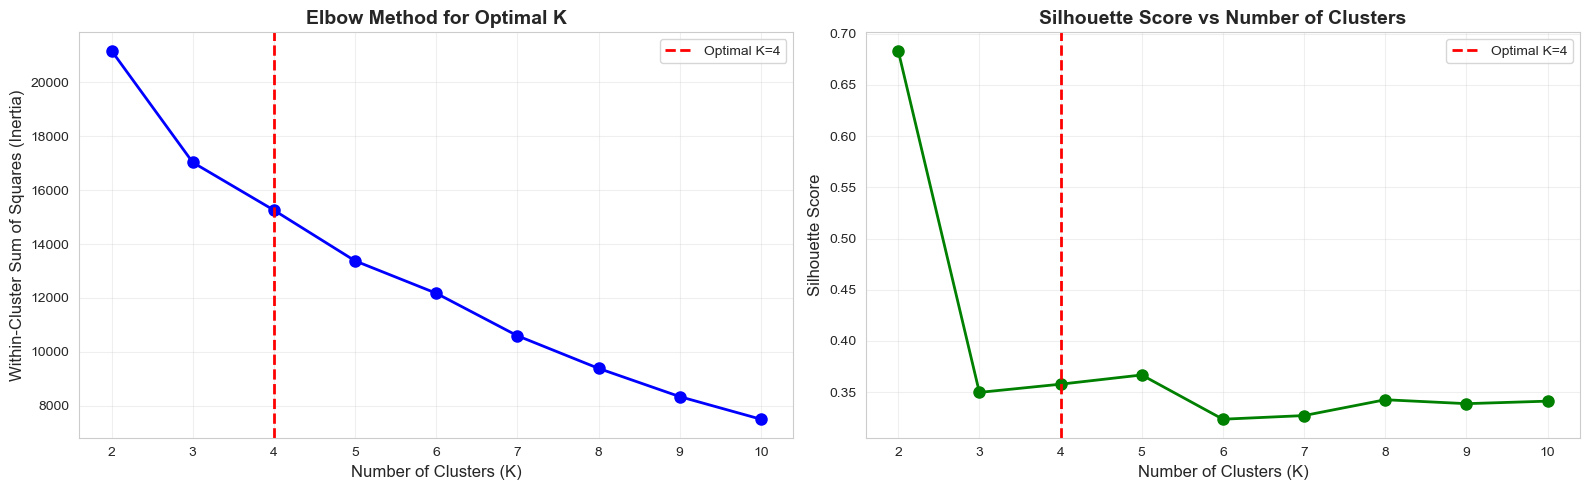


Elbow analysis complete


In [37]:
# Visualize elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Elbow curve
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend()

# Silhouette scores
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].axvline(optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nElbow analysis complete")

In [38]:
# Apply K-Means with optimal K
print(f"APPLYING K-MEANS CLUSTERING (K={optimal_k})")

# Fit K-Means
kmeans_final = KMeans(n_clusters=optimal_k, random_state=random_state, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster)

# Add cluster labels back to dataframe
df_cluster['Cluster'] = cluster_labels

# Merge cluster labels back to main dataframe
df_merged_idx = df_merged[cluster_features].dropna().index
df_merged.loc[df_merged_idx, 'Cluster'] = cluster_labels

print("\nClustering complete!")
print(f"Silhouette score: {silhouette_score(X_cluster, cluster_labels):.3f}")

# Analyze cluster distribution
print("\nCluster Distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(cluster_labels) * 100
    print(f"Cluster {cluster}: {count:,} buildings ({pct:.1f}%)")

APPLYING K-MEANS CLUSTERING (K=4)

Clustering complete!
Silhouette score: 0.358

Cluster Distribution:
Cluster 0: 89 buildings (2.7%)
Cluster 1: 892 buildings (27.3%)
Cluster 2: 2,154 buildings (66.0%)
Cluster 3: 130 buildings (4.0%)

Clustering complete!
Silhouette score: 0.358

Cluster Distribution:
Cluster 0: 89 buildings (2.7%)
Cluster 1: 892 buildings (27.3%)
Cluster 2: 2,154 buildings (66.0%)
Cluster 3: 130 buildings (4.0%)


In [39]:
# Analyze cluster characteristics
print("CLUSTER CHARACTERISTICS ANALYSIS")

# Calculate cluster profiles
cluster_profiles = df_cluster.groupby('Cluster')[cluster_features].mean()

print("\nCluster Profiles (Mean Values):")

for cluster in range(optimal_k):
    print(f"\nCLUSTER {cluster} ({cluster_counts[cluster]:,} buildings):")
    profile = cluster_profiles.loc[cluster]
    
    # Show top characteristics
    if 'SiteEUI(kBtu/sf)_2015' in profile.index:
        print(f"Avg EUI: {profile['SiteEUI(kBtu/sf)_2015']:.1f} kBtu/sf")
    if 'PropertyGFATotal_2015' in profile.index:
        print(f"Avg Size: {profile['PropertyGFATotal_2015']:,.0f} sqft")
    if 'BuildingAge_2015' in profile.index:
        print(f"Avg Age: {profile['BuildingAge_2015']:.0f} years")
    if 'Electrification_Rate_2015' in profile.index:
        print(f"Electrification: {profile['Electrification_Rate_2015']:.1%}")


CLUSTER CHARACTERISTICS ANALYSIS

Cluster Profiles (Mean Values):

CLUSTER 0 (89 buildings):
Avg EUI: 66.3 kBtu/sf
Avg Size: 708,500 sqft
Avg Age: 30 years
Electrification: 83.4%

CLUSTER 1 (892 buildings):
Avg EUI: 55.8 kBtu/sf
Avg Size: 54,227 sqft
Avg Age: 73 years
Electrification: 41.1%

CLUSTER 2 (2,154 buildings):
Avg EUI: 40.7 kBtu/sf
Avg Size: 76,013 sqft
Avg Age: 38 years
Electrification: 89.5%

CLUSTER 3 (130 buildings):
Avg EUI: 242.9 kBtu/sf
Avg Size: 167,030 sqft
Avg Age: 37 years
Electrification: 62.3%


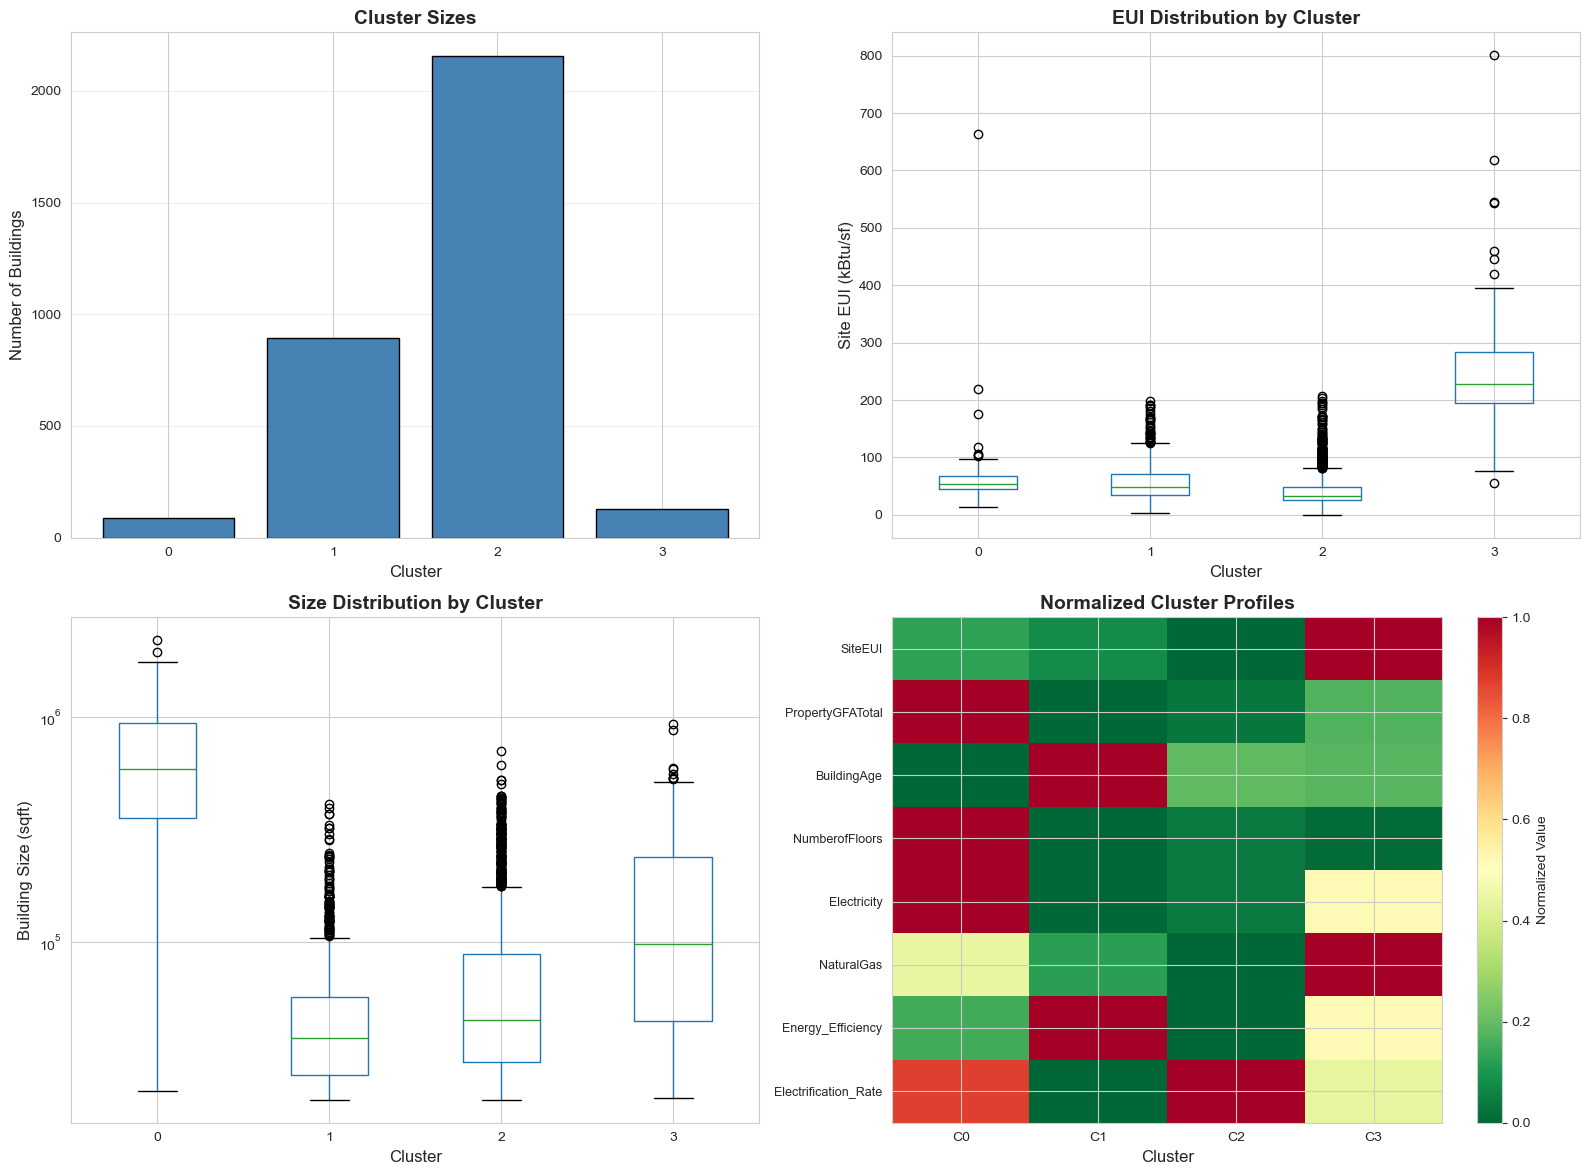


Cluster visualizations complete


In [40]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cluster sizes
axes[0, 0].bar(range(optimal_k), cluster_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Cluster', fontsize=12)
axes[0, 0].set_ylabel('Number of Buildings', fontsize=12)
axes[0, 0].set_title('Cluster Sizes', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(range(optimal_k))
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. EUI by cluster
if 'SiteEUI(kBtu/sf)_2015' in df_cluster.columns:
    df_cluster.boxplot(column='SiteEUI(kBtu/sf)_2015', by='Cluster', ax=axes[0, 1])
    axes[0, 1].set_xlabel('Cluster', fontsize=12)
    axes[0, 1].set_ylabel('Site EUI (kBtu/sf)', fontsize=12)
    axes[0, 1].set_title('EUI Distribution by Cluster', fontsize=14, fontweight='bold')
    axes[0, 1].get_figure().suptitle('')  # Remove default title

# 3. Building size by cluster
if 'PropertyGFATotal_2015' in df_cluster.columns:
    df_cluster.boxplot(column='PropertyGFATotal_2015', by='Cluster', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Cluster', fontsize=12)
    axes[1, 0].set_ylabel('Building Size (sqft)', fontsize=12)
    axes[1, 0].set_title('Size Distribution by Cluster', fontsize=14, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].get_figure().suptitle('')  # Remove default title

# 4. Cluster profile heatmap
profile_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())
im = axes[1, 1].imshow(profile_normalized.T, aspect='auto', cmap='RdYlGn_r')
axes[1, 1].set_xticks(range(optimal_k))
axes[1, 1].set_xticklabels([f'C{i}' for i in range(optimal_k)])
axes[1, 1].set_yticks(range(len(cluster_features)))
axes[1, 1].set_yticklabels([f.replace('_2015', '').replace('(kBtu/sf)', '').replace('(kBtu)', '')[:20] for f in cluster_features], fontsize=9)
axes[1, 1].set_xlabel('Cluster', fontsize=12)
axes[1, 1].set_title('Normalized Cluster Profiles', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[1, 1], label='Normalized Value')

plt.tight_layout()
plt.show()

print("\nCluster visualizations complete")

In [41]:
# Add cluster as a feature for modeling
print("ADDING CLUSTER MEMBERSHIP AS MODEL FEATURE")

# The 'Cluster' column is already in df_merged
# It will be used as a categorical feature in the modeling pipeline

cluster_summary = df_merged['Cluster'].value_counts().sort_index()
print("\nCluster feature added to dataset")
print(f"   Total buildings with cluster assignment: {cluster_summary.sum():,}")
print(f"   Buildings without cluster (due to missing values): {df_merged['Cluster'].isna().sum():,}")

print("\nInsight:")
print("Cluster membership can help models learn building archetypes")
print("Similar buildings often respond similarly to energy interventions")
print("This unsupervised feature may improve prediction accuracy")


ADDING CLUSTER MEMBERSHIP AS MODEL FEATURE

Cluster feature added to dataset
   Total buildings with cluster assignment: 3,265
   Buildings without cluster (due to missing values): 19

Insight:
Cluster membership can help models learn building archetypes
Similar buildings often respond similarly to energy interventions
This unsupervised feature may improve prediction accuracy


## PHASE 6: Data Preprocessing Pipeline

In [42]:
# Select features for modeling
print("Selecting features for modeling...")

numerical_features = [
    'SiteEUI(kBtu/sf)_2015',
    'SourceEUI(kBtu/sf)_2015',
    'PropertyGFATotal_2015',
    'BuildingAge_2015',
    'NumberofFloors_2015',
    'ENERGYSTARScore_2015',
    'Electricity(kBtu)_2015',
    'NaturalGas(kBtu)_2015',
    'Energy_Efficiency_2015',
    'Carbon_Intensity_2015',
    'Electrification_Rate_2015',
    'Has_ENERGY_STAR',
    'Age_Size_Interaction',
    'EUI_ESTAR_Interaction',
    'Electricity_per_sqft',
    'NaturalGas_per_sqft'
]

categorical_features = []
if 'BuildingType_2015' in df_merged.columns:
    categorical_features.append('BuildingType_2015')
if 'SizeCategory' in df_merged.columns:
    categorical_features.append('SizeCategory')

# Filter to existing columns
numerical_features = [f for f in numerical_features if f in df_merged.columns]
categorical_features = [f for f in categorical_features if f in df_merged.columns]

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

Selecting features for modeling...
Numerical features: 15
Categorical features: 2


In [43]:
# Remove rows with missing targets
df_model = df_merged.dropna(subset=['Target_2016_EUI', 'Target_Delta_EUI']).copy()
print(f"Usable buildings: {len(df_model):,}")

Usable buildings: 3,270


In [45]:
# Create feature matrix and targets
all_features = numerical_features + categorical_features
X = df_model[all_features].copy()

y_2016_eui = df_model['Target_2016_EUI']
y_delta_eui = df_model['Target_Delta_EUI']
y_worsened = df_model['Target_Worsened']
y_trajectory = df_model['Trajectory_Class']

print(f"\nFeature matrix: {X.shape}")
print(f"Target 2016 EUI: mean={y_2016_eui.mean():.2f}, std={y_2016_eui.std():.2f}")
print(f"Target delta EUI: mean={y_delta_eui.mean():.2f}, std={y_delta_eui.std():.2f}")


Feature matrix: (3270, 17)
Target 2016 EUI: mean=54.21, std=54.11
Target delta EUI: mean=0.62, std=15.78


In [46]:
# Create preprocessing pipeline
print("Creating preprocessing pipeline...")

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("Preprocessing pipeline created")

Creating preprocessing pipeline...
Preprocessing pipeline created


## PHASE 7: Train-Test Split

In [47]:
# Split data (80-20)
print("Splitting data...")
random_state = 42

X_train, X_test, y_train_2016, y_test_2016 = train_test_split(
    X, y_2016_eui, test_size=0.2, random_state=random_state
)

_, _, y_train_delta, y_test_delta = train_test_split(
    X, y_delta_eui, test_size=0.2, random_state=random_state
)

_, _, y_train_worsened, y_test_worsened = train_test_split(
    X, y_worsened, test_size=0.2, random_state=random_state
)

_, _, y_train_traj, y_test_traj = train_test_split(
    X, y_trajectory, test_size=0.2, random_state=random_state
)

print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

Splitting data...
Train: 2,616 | Test: 654


In [49]:
# Apply preprocessing
print("Applying preprocessing...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed shape: {X_train_processed.shape}")
print(f"(Original {len(all_features)} → {X_train_processed.shape[1]} after encoding)")

Applying preprocessing...
Processed shape: (2616, 27)
(Original 17 → 27 after encoding)


## PHASE 8: Baseline Model - Linear Regression

In [50]:
# Train Linear Regression
print("Training Linear Regression (baseline)...")
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train_2016)

y_pred_lr = lr_model.predict(X_test_processed)

rmse_lr = np.sqrt(mean_squared_error(y_test_2016, y_pred_lr))
mae_lr = mean_absolute_error(y_test_2016, y_pred_lr)
r2_lr = r2_score(y_test_2016, y_pred_lr)

print("\nLinear Regression Results:")
print(f"  RMSE: {rmse_lr:.2f}")
print(f"  MAE: {mae_lr:.2f}")
print(f"  R²: {r2_lr:.4f}")

Training Linear Regression (baseline)...

Linear Regression Results:
  RMSE: 13.29
  MAE: 6.21
  R²: 0.9438


## PHASE 9: Random Forest Model

In [54]:
# Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_processed, y_train_2016)

y_pred_rf = rf_model.predict(X_test_processed)

rmse_rf = np.sqrt(mean_squared_error(y_test_2016, y_pred_rf))
mae_rf = mean_absolute_error(y_test_2016, y_pred_rf)
r2_rf = r2_score(y_test_2016, y_pred_rf)

print("\nRandom Forest Results:")
print(f"  RMSE: {rmse_rf:.2f}")
print(f"  MAE: {mae_rf:.2f}")
print(f"  R²: {r2_rf:.4f}")
print(f"\nImprovement over baseline: {(r2_rf - r2_lr)/r2_lr*100:.1f}%")

Training Random Forest...

Random Forest Results:
  RMSE: 16.81
  MAE: 6.58
  R²: 0.9100

Improvement over baseline: -3.6%

Random Forest Results:
  RMSE: 16.81
  MAE: 6.58
  R²: 0.9100

Improvement over baseline: -3.6%


## PHASE 10: Gradient Boosting Model

In [57]:
# Train Gradient Boosting
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_processed, y_train_2016)

y_pred_gb = gb_model.predict(X_test_processed)

rmse_gb = np.sqrt(mean_squared_error(y_test_2016, y_pred_gb))
mae_gb = mean_absolute_error(y_test_2016, y_pred_gb)
r2_gb = r2_score(y_test_2016, y_pred_gb)

print("\nGradient Boosting Results:")
print(f"  RMSE: {rmse_gb:.2f}")
print(f"  MAE: {mae_gb:.2f}")
print(f"  R²: {r2_gb:.4f}")
print(f"\nImprovement over baseline: {(r2_gb - r2_lr)/r2_gb*100:.1f}%")

Training Gradient Boosting...

Gradient Boosting Results:
  RMSE: 17.71
  MAE: 6.52
  R²: 0.9001

Improvement over baseline: -4.8%

Gradient Boosting Results:
  RMSE: 17.71
  MAE: 6.52
  R²: 0.9001

Improvement over baseline: -4.8%


## PHASE 11: XGBoost Model

In [109]:
# Train XGBoost

print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_processed, y_train_2016)

y_pred_xgb = xgb_model.predict(X_test_processed)

rmse_xgb = np.sqrt(mean_squared_error(y_test_2016, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test_2016, y_pred_xgb)
r2_xgb = r2_score(y_test_2016, y_pred_xgb)

print("\nXGBoost Results:")
print(f"  RMSE: {rmse_xgb:.2f}")
print(f"  MAE: {mae_xgb:.2f}")
print(f"  R²: {r2_xgb:.4f}")
print(f"\nImprovement over baseline: {(r2_xgb - r2_lr)/r2_xgb*100:.1f}%")


Training XGBoost...

XGBoost Results:
  RMSE: 26.16
  MAE: 7.94
  R²: 0.7821

Improvement over baseline: -20.7%


## PHASE 12: Model Comparison

In [61]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'RMSE': [rmse_lr, rmse_rf, rmse_gb],
    'MAE': [mae_lr, mae_rf, mae_gb],
    'R²': [r2_lr, r2_rf, r2_gb]
})


results = pd.concat([
    results,
    pd.DataFrame({
        'Model': ['XGBoost'],
        'RMSE': [rmse_xgb],
        'MAE': [mae_xgb],
        'R²': [r2_xgb]
    })
], ignore_index=True)

results = results.sort_values('R²', ascending=False)
print("MODEL COMPARISON - Predicting 2016 Site EUI")
print(results.to_string(index=False))
print("\nBest model: " + results.iloc[0]['Model'])

MODEL COMPARISON - Predicting 2016 Site EUI
            Model      RMSE      MAE       R²
Linear Regression 13.290942 6.213527 0.943754
    Random Forest 16.809613 6.575621 0.910030
Gradient Boosting 17.712818 6.517775 0.900102
          XGBoost 26.158375 7.938865 0.782126

Best model: Linear Regression


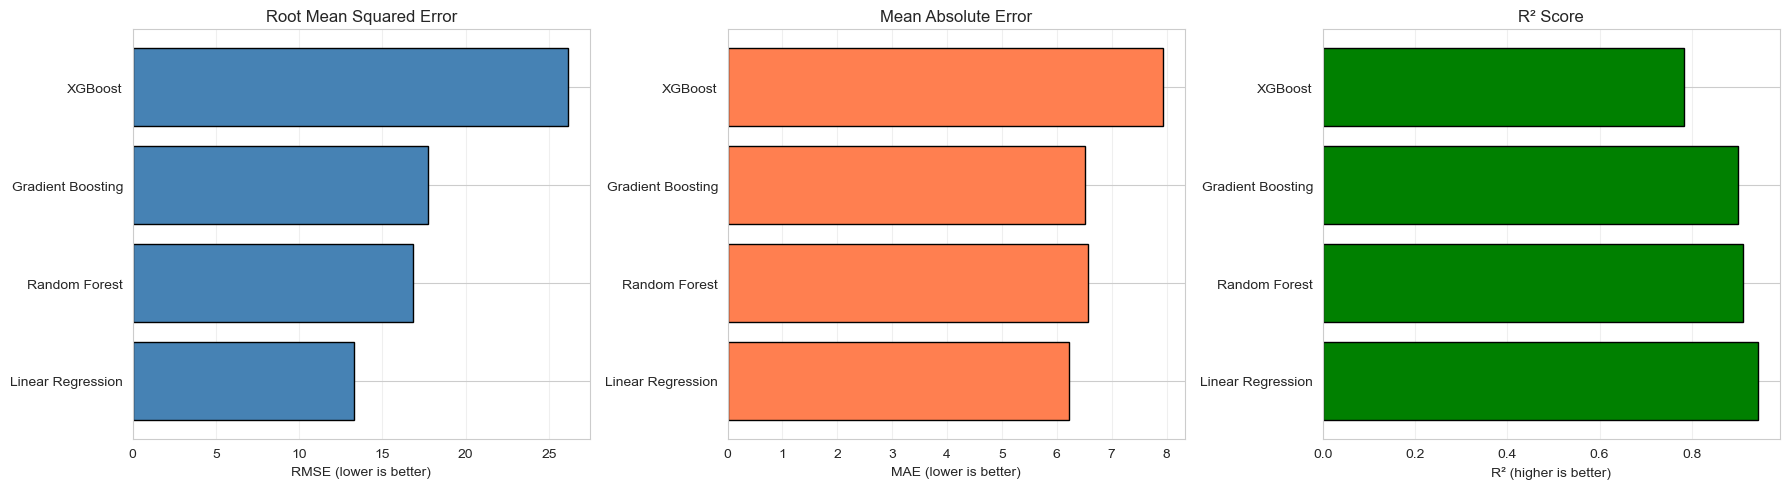

In [62]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
axes[0].barh(results['Model'], results['RMSE'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('RMSE (lower is better)')
axes[0].set_title('Root Mean Squared Error')
axes[0].grid(axis='x', alpha=0.3)

# MAE comparison
axes[1].barh(results['Model'], results['MAE'], color='coral', edgecolor='black')
axes[1].set_xlabel('MAE (lower is better)')
axes[1].set_title('Mean Absolute Error')
axes[1].grid(axis='x', alpha=0.3)

# R² comparison
axes[2].barh(results['Model'], results['R²'], color='green', edgecolor='black')
axes[2].set_xlabel('R² (higher is better)')
axes[2].set_title('R² Score')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

---
## PHASE 13: Model Interpretability with SHAP

Understanding which features drive predictions using SHAP (SHapley Additive exPlanations)

In [64]:
# SHAP analysis for Random Forest (tree-based model)
print("SHAP ANALYSIS - MODEL INTERPRETABILITY")

print("\nComputing SHAP values for Random Forest model...")
print("   This explains how each feature contributes to predictions")

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Use processed test data (sample for speed)
sample_size = min(500, len(X_test_processed))
sample_indices = np.random.choice(len(X_test_processed), size=sample_size, replace=False)
X_test_sample_processed = X_test_processed[sample_indices]

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_sample_processed)

print(f"SHAP values computed for {sample_size} test samples")

# Get feature names from preprocessor
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out().tolist()
else:
    # Fallback: combine numerical and one-hot encoded categorical features
    feature_names = numerical_features.copy()
    if categorical_features:
        for cat_feat in categorical_features:
            categories = df_merged[cat_feat].unique()
            feature_names.extend([f"{cat_feat}_{cat}" for cat in categories])

print("TOP 15 MOST IMPORTANT FEATURES (by mean |SHAP|)")

# Calculate mean absolute SHAP values
shap_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': np.abs(shap_values).mean(axis=0)
}).sort_values('Mean_SHAP', ascending=False)

print(shap_importance.head(15).to_string(index=False))

SHAP ANALYSIS - MODEL INTERPRETABILITY

Computing SHAP values for Random Forest model...
   This explains how each feature contributes to predictions
SHAP values computed for 500 test samples
TOP 15 MOST IMPORTANT FEATURES (by mean |SHAP|)
                                 Feature  Mean_SHAP
              num__SiteEUI(kBtu/sf)_2015  28.973192
            num__SourceEUI(kBtu/sf)_2015   1.429098
             num__Energy_Efficiency_2015   0.457615
                num__NaturalGas_per_sqft   0.451878
               num__ENERGYSTARScore_2015   0.286427
               num__Electricity_per_sqft   0.285438
              num__NaturalGas(kBtu)_2015   0.282312
          num__Electrification_Rate_2015   0.213352
               num__Age_Size_Interaction   0.205896
                   num__BuildingAge_2015   0.194463
cat__BuildingType_2015_SPS-District K-12   0.182862
                num__NumberofFloors_2015   0.176934
              num__EUI_ESTAR_Interaction   0.167535
             num__Electricity(kB

---
## PHASE 14: Model Interpretability with SHAP

Understanding which features drive predictions using SHAP (SHapley Additive exPlanations)

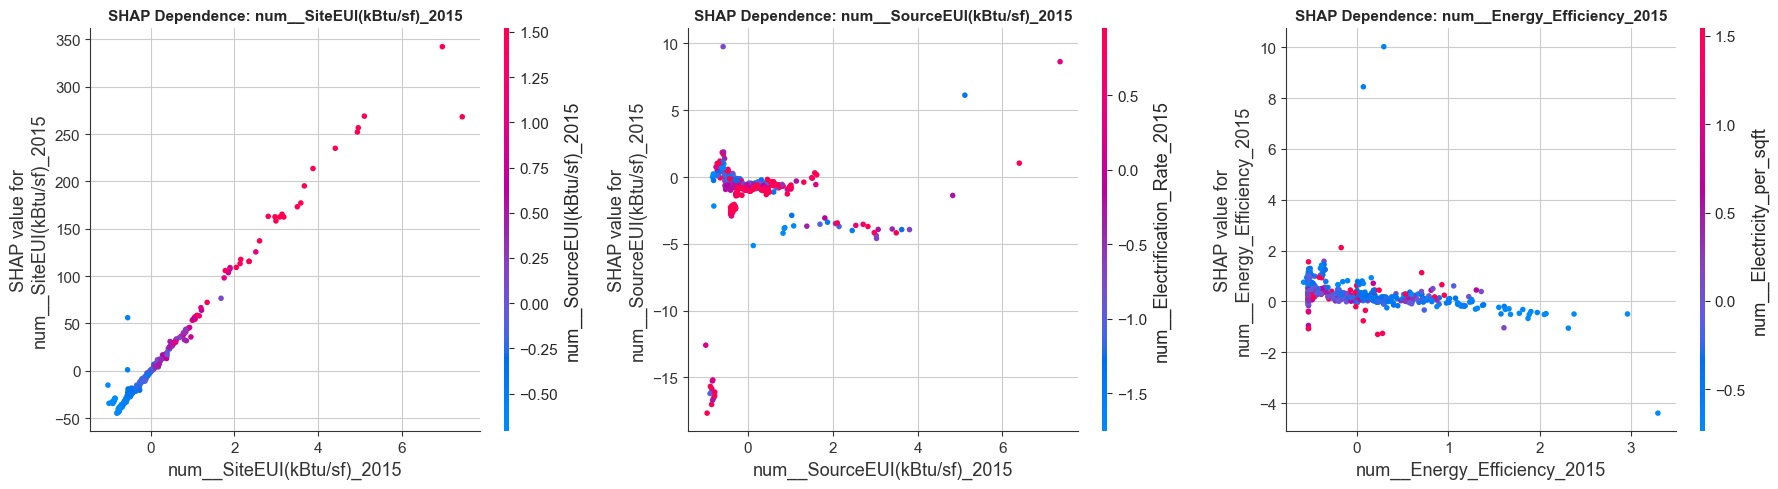


SHAP analysis complete!

Key Insight: 'num__SiteEUI(kBtu/sf)_2015' is the most influential feature


In [65]:
# SHAP Dependence Plot for top 3 features
top_3_features = shap_importance.head(3)['Feature'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(top_3_features):
    feature_idx = feature_names.index(feature)
    
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature_idx, 
        shap_values, 
        X_test_sample_processed, 
        show=False,
        ax=axes[idx],
        feature_names=feature_names
    )
    axes[idx].set_title(f'SHAP Dependence: {feature}', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nSHAP analysis complete!")
print(f"\nKey Insight: '{top_3_features[0]}' is the most influential feature")

---
## PHASE 15: Cross-Validation Model Comparison

Robust evaluation using k-fold cross-validation to assess model stability

In [66]:
# Cross-validation comparison for all models

print("CROSS-VALIDATION MODEL COMPARISON")

cv_results = []

for name, model in [
    ('Linear Regression', lr_model),
    ('Random Forest', rf_model),
    ('Gradient Boosting', gb_model),
    ('XGBoost', xgb_model)
]:
    print(f"\nEvaluating {name} with 5-fold CV...")
    
    # Perform cross-validation on preprocessed data
    cv_scores_r2 = cross_val_score(model, X_train_processed, y_train_2016, cv=5, scoring='r2', n_jobs=-1)
    cv_scores_neg_rmse = cross_val_score(model, X_train_processed, y_train_2016, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    cv_scores_neg_mae = cross_val_score(model, X_train_processed, y_train_2016, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    cv_results.append({
        'Model': name,
        'CV_R2_Mean': cv_scores_r2.mean(),
        'CV_R2_Std': cv_scores_r2.std(),
        'CV_RMSE_Mean': -cv_scores_neg_rmse.mean(),
        'CV_RMSE_Std': cv_scores_neg_rmse.std(),
        'CV_MAE_Mean': -cv_scores_neg_mae.mean(),
        'CV_MAE_Std': cv_scores_neg_mae.std()
    })
    
    print(f"   R² = {cv_scores_r2.mean():.4f} ± {cv_scores_r2.std():.4f}")
    print(f"   RMSE = {-cv_scores_neg_rmse.mean():.2f} ± {cv_scores_neg_rmse.std():.2f}")
    print(f"   MAE = {-cv_scores_neg_mae.mean():.2f} ± {cv_scores_neg_mae.std():.2f}")

# Create CV results DataFrame
cv_results_df = pd.DataFrame(cv_results)
print("CROSS-VALIDATION SUMMARY")
print(cv_results_df.to_string(index=False))

# Identify best model based on CV
best_cv_model = cv_results_df.loc[cv_results_df['CV_R2_Mean'].idxmax(), 'Model']
print(f"\nBest model by cross-validation: {best_cv_model}")

CROSS-VALIDATION MODEL COMPARISON

Evaluating Linear Regression with 5-fold CV...
   R² = 0.8893 ± 0.0562
   RMSE = 17.21 ± 4.92
   MAE = 6.33 ± 0.48

Evaluating Random Forest with 5-fold CV...
   R² = 0.8893 ± 0.0562
   RMSE = 17.21 ± 4.92
   MAE = 6.33 ± 0.48

Evaluating Random Forest with 5-fold CV...
   R² = 0.9004 ± 0.0317
   RMSE = 16.67 ± 3.65
   MAE = 6.32 ± 0.37

Evaluating Gradient Boosting with 5-fold CV...
   R² = 0.9004 ± 0.0317
   RMSE = 16.67 ± 3.65
   MAE = 6.32 ± 0.37

Evaluating Gradient Boosting with 5-fold CV...
   R² = 0.8902 ± 0.0368
   RMSE = 17.33 ± 3.44
   MAE = 6.60 ± 0.59

Evaluating XGBoost with 5-fold CV...
   R² = 0.8902 ± 0.0368
   RMSE = 17.33 ± 3.44
   MAE = 6.60 ± 0.59

Evaluating XGBoost with 5-fold CV...
   R² = 0.8123 ± 0.0887
   RMSE = 22.61 ± 6.39
   MAE = 7.59 ± 0.82
CROSS-VALIDATION SUMMARY
            Model  CV_R2_Mean  CV_R2_Std  CV_RMSE_Mean  CV_RMSE_Std  CV_MAE_Mean  CV_MAE_Std
Linear Regression    0.889298   0.056203     17.205044     4.923

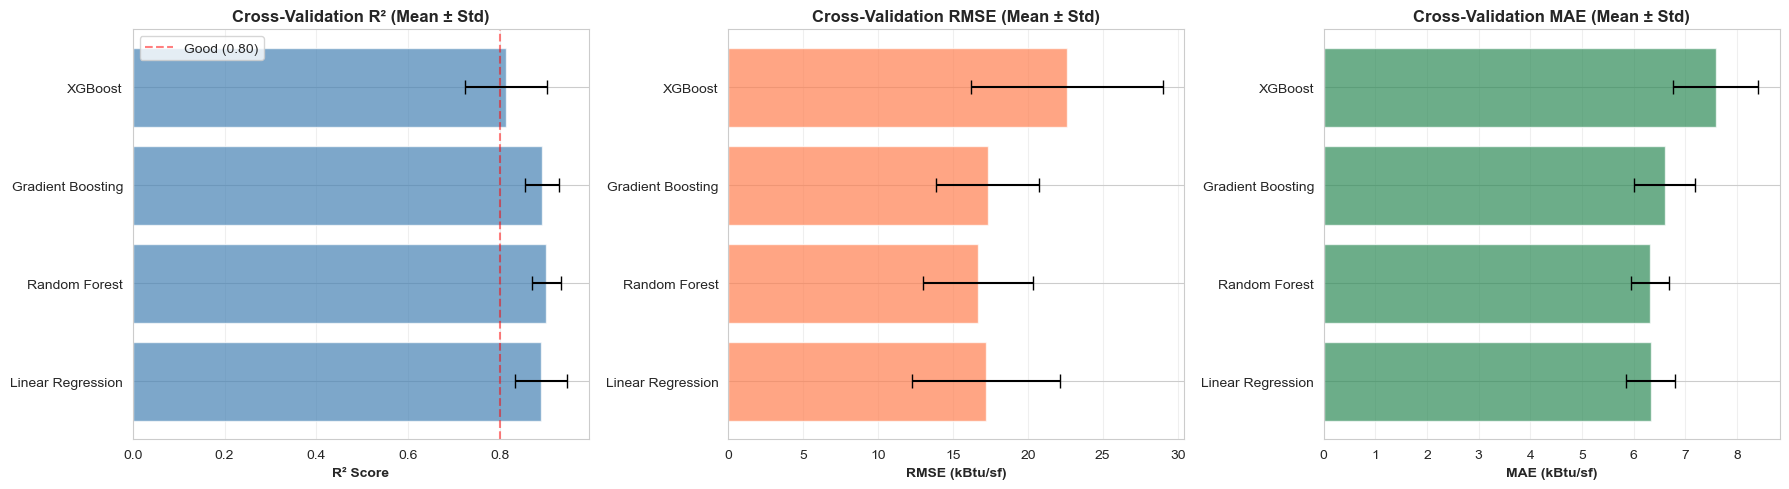

In [67]:
# Visualize CV results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² scores
axes[0].barh(cv_results_df['Model'], cv_results_df['CV_R2_Mean'], 
             xerr=cv_results_df['CV_R2_Std'], capsize=5, alpha=0.7, color='steelblue')
axes[0].set_xlabel('R² Score', fontweight='bold')
axes[0].set_title('Cross-Validation R² (Mean ± Std)', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(x=0.8, color='red', linestyle='--', alpha=0.5, label='Good (0.80)')
axes[0].legend()

# RMSE
axes[1].barh(cv_results_df['Model'], cv_results_df['CV_RMSE_Mean'], 
             xerr=cv_results_df['CV_RMSE_Std'], capsize=5, alpha=0.7, color='coral')
axes[1].set_xlabel('RMSE (kBtu/sf)', fontweight='bold')
axes[1].set_title('Cross-Validation RMSE (Mean ± Std)', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# MAE
axes[2].barh(cv_results_df['Model'], cv_results_df['CV_MAE_Mean'], 
             xerr=cv_results_df['CV_MAE_Std'], capsize=5, alpha=0.7, color='seagreen')
axes[2].set_xlabel('MAE (kBtu/sf)', fontweight='bold')
axes[2].set_title('Cross-Validation MAE (Mean ± Std)', fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

---
## PHASE 16: Residual Analysis & Diagnostic Plots

Comprehensive residual diagnostics to validate model assumptions

In [68]:
# Residual Analysis for Best Model (Random Forest)
print("RESIDUAL ANALYSIS - DIAGNOSTIC CHECKS")

# Get predictions and residuals using preprocessed test data
residuals = y_test_2016.values - y_pred_rf

print("\nResidual Statistics:")
print(f"   Mean residual: {residuals.mean():.4f} (should be ~0)")
print(f"   Std residual: {residuals.std():.2f}")
print(f"   Min residual: {residuals.min():.2f}")
print(f"   Max residual: {residuals.max():.2f}")

# Calculate percentage errors (handle division by zero)
# Replace zeros with small value to avoid infinity
y_test_safe = np.where(y_test_2016.values == 0, 0.001, y_test_2016.values)
pct_errors = (residuals / y_test_safe) * 100

# Remove any remaining inf/nan values for statistics
pct_errors_finite = pct_errors[np.isfinite(pct_errors)]

print("\nPercentage Error Statistics:")
print(f"   Mean absolute % error: {np.abs(pct_errors_finite).mean():.2f}%")
print(f"   Median absolute % error: {np.median(np.abs(pct_errors_finite)):.2f}%")

# Count predictions within error bands
within_10pct = (np.abs(pct_errors_finite) <= 10).sum()
within_20pct = (np.abs(pct_errors_finite) <= 20).sum()
print("\nPrediction Accuracy:")
print(f"   Within ±10%: {within_10pct}/{len(pct_errors_finite)} ({within_10pct/len(pct_errors_finite)*100:.1f}%)")
print(f"   Within ±20%: {within_20pct}/{len(pct_errors_finite)} ({within_20pct/len(pct_errors_finite)*100:.1f}%)")

RESIDUAL ANALYSIS - DIAGNOSTIC CHECKS

Residual Statistics:
   Mean residual: -0.5519 (should be ~0)
   Std residual: 16.80
   Min residual: -106.33
   Max residual: 223.45

Percentage Error Statistics:
   Mean absolute % error: 17391.13%
   Median absolute % error: 6.50%

Prediction Accuracy:
   Within ±10%: 424/654 (64.8%)
   Within ±20%: 553/654 (84.6%)


In [92]:
# Identify outliers and high-error predictions
print("OUTLIER ANALYSIS")

# Calculate standardized residuals
standardized_residuals = residuals / residuals.std()

# Identify outliers (|standardized residual| > 3)
outliers_mask = np.abs(standardized_residuals) > 3
n_outliers = outliers_mask.sum()

print(f"\nFound {n_outliers} outliers (|standardized residual| > 3)")

if n_outliers > 0:
    # Get outlier details
    outlier_df = pd.DataFrame({
        'Actual_EUI': y_test_2016.values[outliers_mask],
        'Predicted_EUI': y_pred_rf[outliers_mask],
        'Residual': residuals[outliers_mask],
        'Pct_Error': pct_errors[outliers_mask],
        'Standardized_Residual': standardized_residuals[outliers_mask]
    }).sort_values('Standardized_Residual', key=abs, ascending=False)
    
    print("\nTop 10 Largest Errors:")
    print(outlier_df.head(10).to_string(index=False))
    
    # Analyze outlier characteristics
    print("\nOutlier Characteristics:")
    print(f"   Mean actual EUI: {outlier_df['Actual_EUI'].mean():.2f} kBtu/sf")
    print(f"   Mean predicted EUI: {outlier_df['Predicted_EUI'].mean():.2f} kBtu/sf")
    print(f"   Mean % error: {outlier_df['Pct_Error'].mean():.2f}%")
else:
    print("No extreme outliers detected (all within 3 standard deviations)")

OUTLIER ANALYSIS

Found 13 outliers (|standardized residual| > 3)

Top 10 Largest Errors:
 Actual_EUI  Predicted_EUI    Residual   Pct_Error  Standardized_Residual
 696.700012     473.251438  223.448574   32.072423              13.289903
 456.600006     328.721723  127.878283   28.006632               7.605732
 250.100006     127.200616  122.899390   49.140099               7.309606
  43.200001     149.527455 -106.327455 -246.128363              -6.323968
  44.200001     143.595379  -99.395378 -224.876417              -5.911673
  71.000000     166.691546  -95.691546 -134.776826              -5.691383
 158.300003      79.552116   78.747887   49.745979               4.683636
  33.299999     107.512173  -74.212174 -222.859386              -4.413868
 108.300003      39.494529   68.805474   63.532292               4.092298
  19.700001      87.739736  -68.039735 -345.379353              -4.046754

Outlier Characteristics:
   Mean actual EUI: 172.25 kBtu/sf
   Mean predicted EUI: 153.58 kBtu/

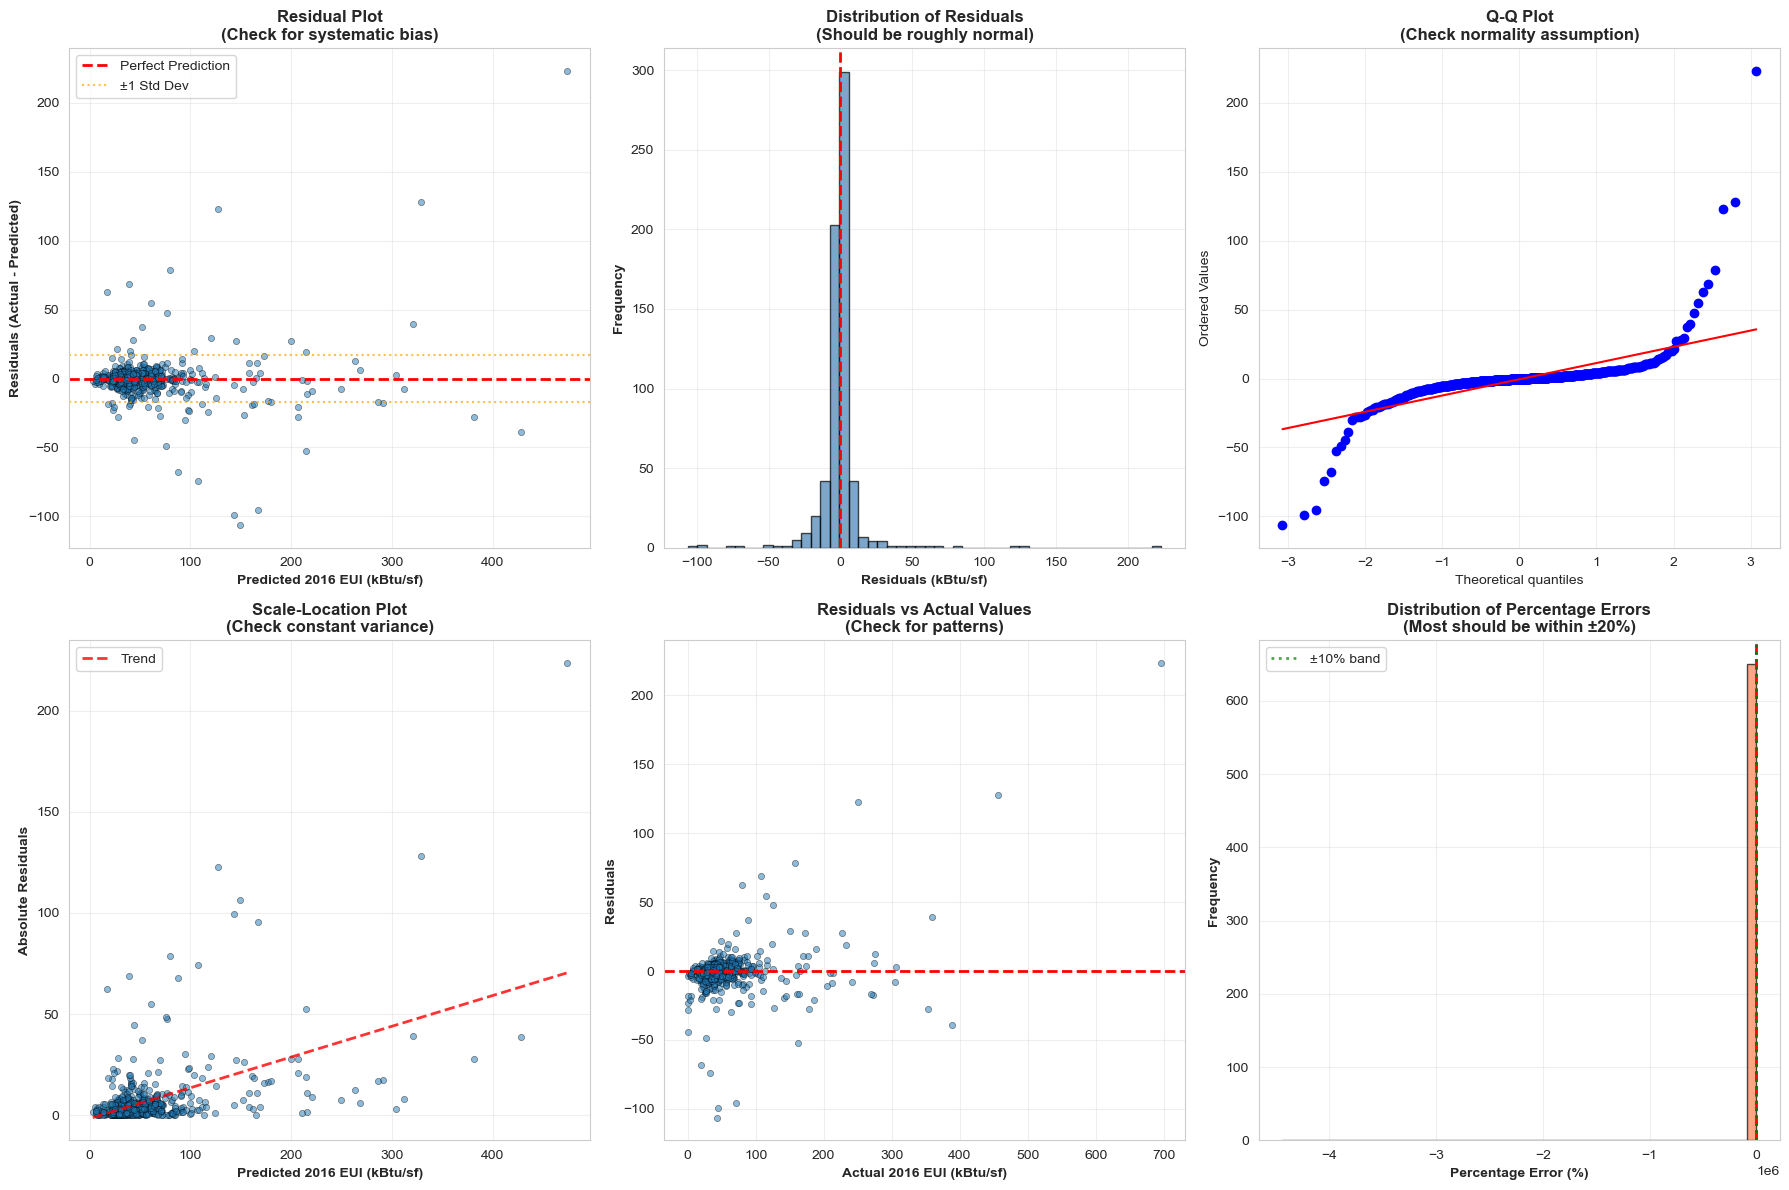


Residual analysis complete!

Diagnostic Interpretation:
Residuals centered at 0 = No systematic bias
Random scatter = Good model fit
Normal distribution = Assumptions met
Constant variance = Homoscedasticity (good)


In [71]:
# Comprehensive Residual Diagnostic Plots

# Ensure pct_errors_finite is available
pct_errors_finite = pct_errors[np.isfinite(pct_errors)]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Residuals vs Predicted Values
axes[0, 0].scatter(y_pred_rf, residuals, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
axes[0, 0].axhline(y=residuals.std(), color='orange', linestyle=':', alpha=0.7, label='±1 Std Dev')
axes[0, 0].axhline(y=-residuals.std(), color='orange', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Predicted 2016 EUI (kBtu/sf)', fontweight='bold')
axes[0, 0].set_ylabel('Residuals (Actual - Predicted)', fontweight='bold')
axes[0, 0].set_title('Residual Plot\n(Check for systematic bias)', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Histogram of Residuals (Check normality)
axes[0, 1].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals (kBtu/sf)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Distribution of Residuals\n(Should be roughly normal)', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Q-Q Plot (Normal probability plot)
stats.probplot(residuals, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot\n(Check normality assumption)', fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# 4. Absolute Residuals vs Predicted (Check heteroscedasticity)
axes[1, 0].scatter(y_pred_rf, np.abs(residuals), alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
axes[1, 0].set_xlabel('Predicted 2016 EUI (kBtu/sf)', fontweight='bold')
axes[1, 0].set_ylabel('Absolute Residuals', fontweight='bold')
axes[1, 0].set_title('Scale-Location Plot\n(Check constant variance)', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Add trend line
z = np.polyfit(y_pred_rf, np.abs(residuals), 1)
p = np.poly1d(z)
axes[1, 0].plot(sorted(y_pred_rf), p(sorted(y_pred_rf)), "r--", alpha=0.8, linewidth=2, label='Trend')
axes[1, 0].legend()

# 5. Residuals vs Actual Values
axes[1, 1].scatter(y_test_2016.values, residuals, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Actual 2016 EUI (kBtu/sf)', fontweight='bold')
axes[1, 1].set_ylabel('Residuals', fontweight='bold')
axes[1, 1].set_title('Residuals vs Actual Values\n(Check for patterns)', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Percentage Error Distribution (use finite values only)
axes[1, 2].hist(pct_errors_finite, bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[1, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 2].axvline(x=-10, color='green', linestyle=':', linewidth=2, alpha=0.7, label='±10% band')
axes[1, 2].axvline(x=10, color='green', linestyle=':', linewidth=2, alpha=0.7)
axes[1, 2].set_xlabel('Percentage Error (%)', fontweight='bold')
axes[1, 2].set_ylabel('Frequency', fontweight='bold')
axes[1, 2].set_title('Distribution of Percentage Errors\n(Most should be within ±20%)', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResidual analysis complete!")
print("\nDiagnostic Interpretation:")
print("Residuals centered at 0 = No systematic bias")
print("Random scatter = Good model fit")
print("Normal distribution = Assumptions met")
print("Constant variance = Homoscedasticity (good)")

## PHASE 17: Actual vs Predicted Visualization

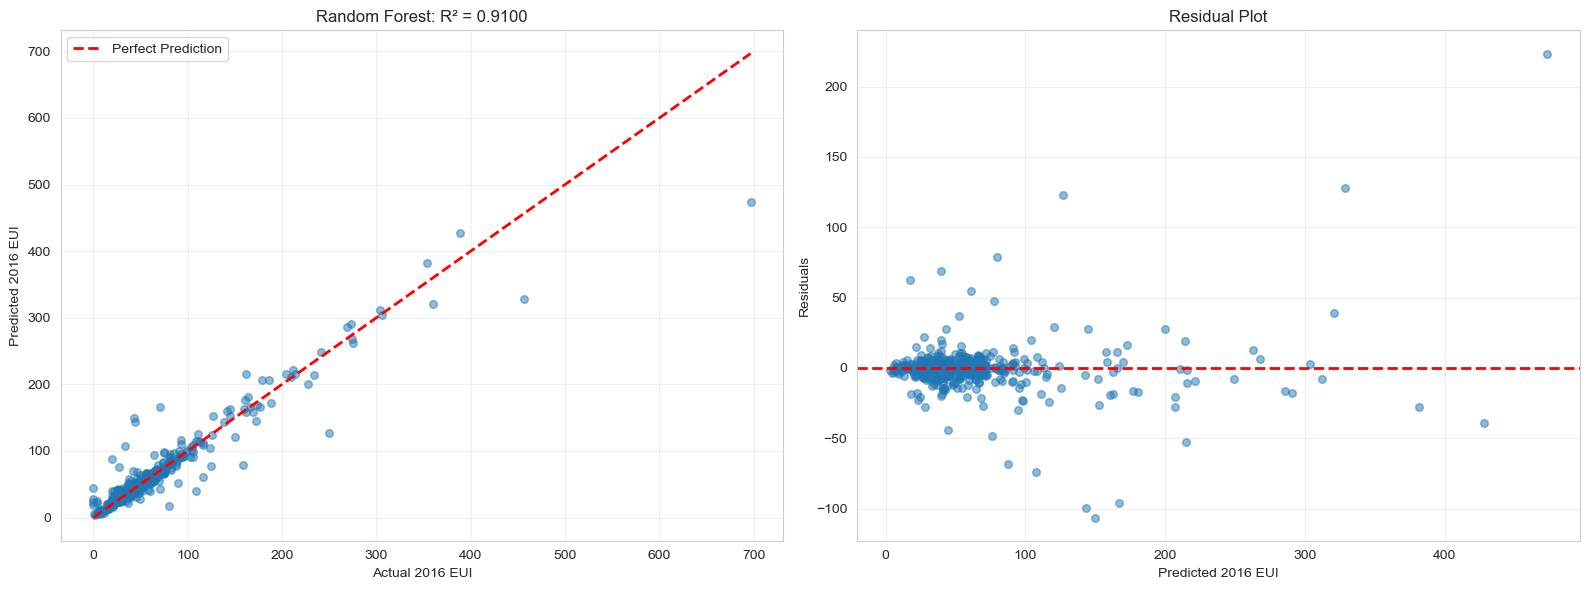

In [72]:
# Plot actual vs predicted for best model (RF)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest predictions
axes[0].scatter(y_test_2016, y_pred_rf, alpha=0.5, s=30)
axes[0].plot([y_test_2016.min(), y_test_2016.max()], 
             [y_test_2016.min(), y_test_2016.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual 2016 EUI')
axes[0].set_ylabel('Predicted 2016 EUI')
axes[0].set_title(f'Random Forest: R² = {r2_rf:.4f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residual plot
residuals = y_test_2016 - y_pred_rf
axes[1].scatter(y_pred_rf, residuals, alpha=0.5, s=30)
axes[1].axhline(0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted 2016 EUI')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## PHASE 18: Binary Classification - EUI Worsening

In [73]:
# Train binary classifier
print("Training binary classifier (EUI Worsened?)...")
clf_binary = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
clf_binary.fit(X_train_processed, y_train_worsened)

y_pred_binary = clf_binary.predict(X_test_processed)

acc = accuracy_score(y_test_worsened, y_pred_binary)
print("\nBinary Classification Results:")
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_worsened, y_pred_binary, 
                          target_names=['Improved', 'Worsened']))

Training binary classifier (EUI Worsened?)...

Binary Classification Results:
Accuracy: 0.6269

Classification Report:
              precision    recall  f1-score   support

    Improved       0.59      0.38      0.46       276
    Worsened       0.64      0.81      0.71       378

    accuracy                           0.63       654
   macro avg       0.62      0.59      0.59       654
weighted avg       0.62      0.63      0.61       654



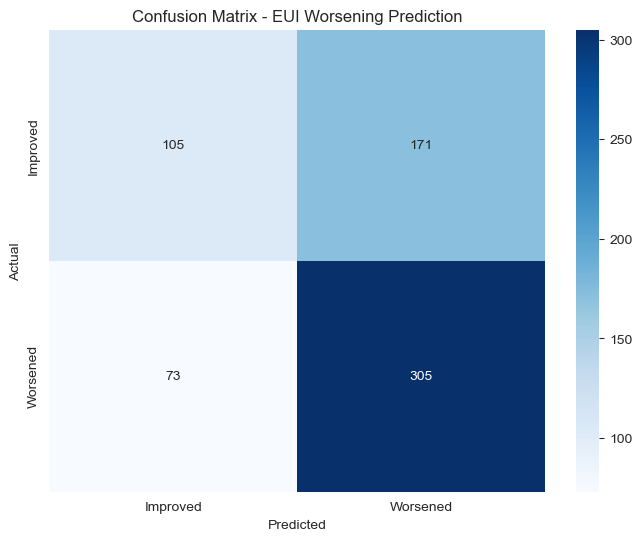

In [74]:
# Confusion matrix
cm = confusion_matrix(y_test_worsened, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Improved', 'Worsened'],
            yticklabels=['Improved', 'Worsened'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - EUI Worsening Prediction')
plt.show()

## PHASE 19: Trajectory Classification

In [75]:
# Train trajectory classifier
print("Training trajectory classifier (Improving/Stable/Declining)...")

# Remove NaN from trajectory
mask = y_train_traj.notna()
X_train_traj = X_train_processed[mask]
y_train_traj_clean = y_train_traj[mask]

mask_test = y_test_traj.notna()
X_test_traj = X_test_processed[mask_test]
y_test_traj_clean = y_test_traj[mask_test]

clf_traj = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
clf_traj.fit(X_train_traj, y_train_traj_clean)

y_pred_traj = clf_traj.predict(X_test_traj)

acc_traj = accuracy_score(y_test_traj_clean, y_pred_traj)
print("\nTrajectory Classification Results:")
print(f"Accuracy: {acc_traj:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_traj_clean, y_pred_traj))

Training trajectory classifier (Improving/Stable/Declining)...

Trajectory Classification Results:
Accuracy: 0.5207

Classification Report:
              precision    recall  f1-score   support

   Declining       0.37      0.22      0.28       180
   Improving       0.41      0.12      0.19       130
      Stable       0.56      0.83      0.67       343

    accuracy                           0.52       653
   macro avg       0.45      0.39      0.38       653
weighted avg       0.48      0.52      0.47       653



## PHASE 20: Feature Importance Analysis

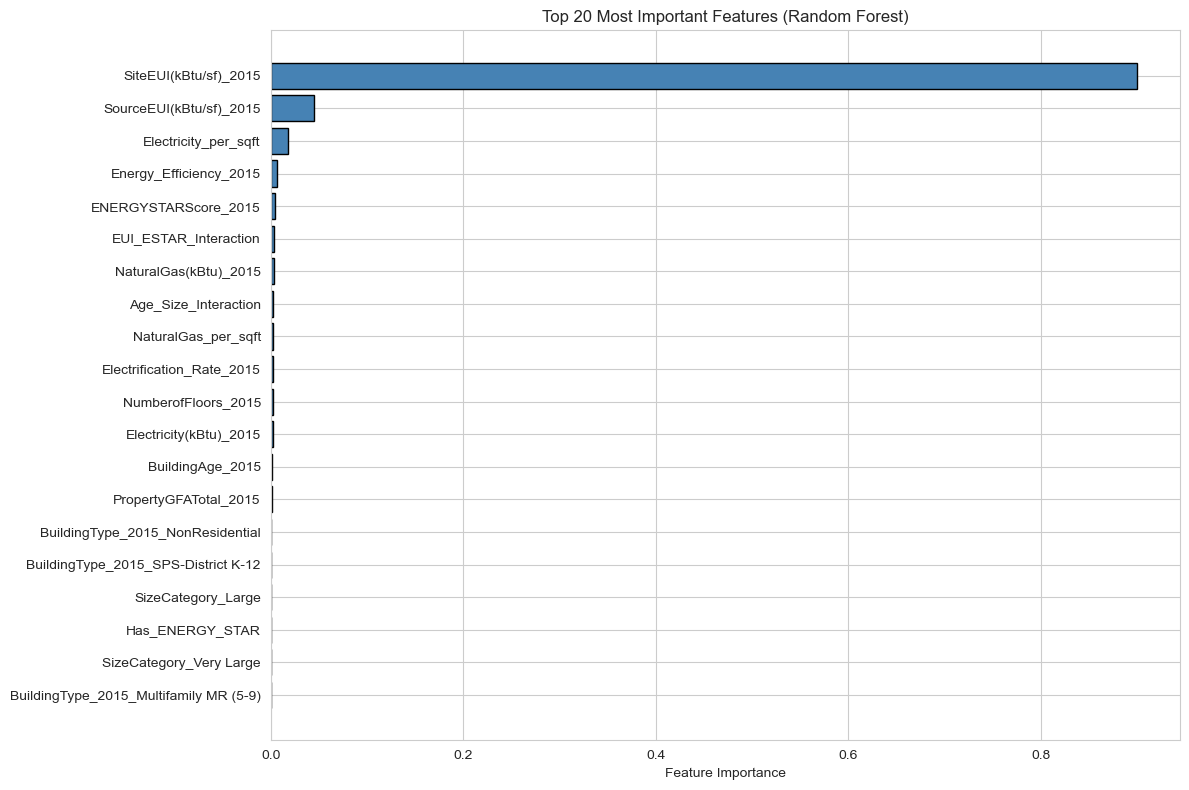


Top 10 Features:
1. SiteEUI(kBtu/sf)_2015: 0.8997
2. SourceEUI(kBtu/sf)_2015: 0.0454
3. Electricity_per_sqft: 0.0183
4. Energy_Efficiency_2015: 0.0064
5. ENERGYSTARScore_2015: 0.0043
6. EUI_ESTAR_Interaction: 0.0037
7. NaturalGas(kBtu)_2015: 0.0035
8. Age_Size_Interaction: 0.0029
9. NaturalGas_per_sqft: 0.0027
10. Electrification_Rate_2015: 0.0025


In [76]:
# Get feature importance from Random Forest
try:
    feature_names_encoded = (
        numerical_features +
        list(preprocessor.named_transformers_['cat']
             .named_steps['onehot']
             .get_feature_names_out(categorical_features))
    )
except:
    feature_names_encoded = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # Top 20

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], color='steelblue', edgecolor='black')
plt.yticks(range(len(indices)), [feature_names_encoded[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
for i in range(min(10, len(indices))):
    print(f"{i+1}. {feature_names_encoded[indices[i]]}: {importances[indices[i]]:.4f}")

## PHASE 21: BEPS Compliance Forecasting

In [78]:
# Extrapolate future emissions based on 2015→2016 trend
print("Forecasting future building trajectories...")

# Calculate annual change rate
df_model['Annual_EUI_Change_Rate'] = df_model['delta_SiteEUI'] / df_model['SiteEUI(kBtu/sf)_2015']

# Project to 2020, 2025, 2030, 2040
years_ahead = [4, 9, 14, 24]  # From 2016 to 2020, 2025, 2030, 2040

for years in years_ahead:
    target_year = 2016 + years
    df_model[f'Projected_EUI_{target_year}'] = (
        df_model['SiteEUI(kBtu/sf)_2016'] * 
        (1 + df_model['Annual_EUI_Change_Rate']) ** years
    )

print("\nProjected EUI for future years created")
print("Years projected: 2020, 2025, 2030, 2040")

Forecasting future building trajectories...

Projected EUI for future years created
Years projected: 2020, 2025, 2030, 2040


In [79]:
# Identify high-risk buildings (EUI increasing trend)
high_risk_threshold = 0.10  # 10% increase per year

df_model['Risk_Score'] = np.clip(
    df_model['Annual_EUI_Change_Rate'] * 100, 0, 100
)

high_risk_buildings = df_model[df_model['Annual_EUI_Change_Rate'] > high_risk_threshold].copy()

print("\nHigh-Risk Buildings Analysis:")
print(f"  Total buildings tracked: {len(df_model):,}")
print(f"  High-risk buildings (>10% annual increase): {len(high_risk_buildings):,}")
print(f"  Risk rate: {len(high_risk_buildings)/len(df_model)*100:.1f}%")

if len(high_risk_buildings) > 0:
    print(f"\n  Average EUI increase rate: {high_risk_buildings['Annual_EUI_Change_Rate'].mean()*100:.1f}%/year")
    print(f"  Projected 2030 EUI: {high_risk_buildings['Projected_EUI_2030'].mean():.1f} kBtu/sf")


High-Risk Buildings Analysis:
  Total buildings tracked: 3,270
  High-risk buildings (>10% annual increase): 496
  Risk rate: 15.2%

  Average EUI increase rate: inf%/year
  Projected 2030 EUI: inf kBtu/sf


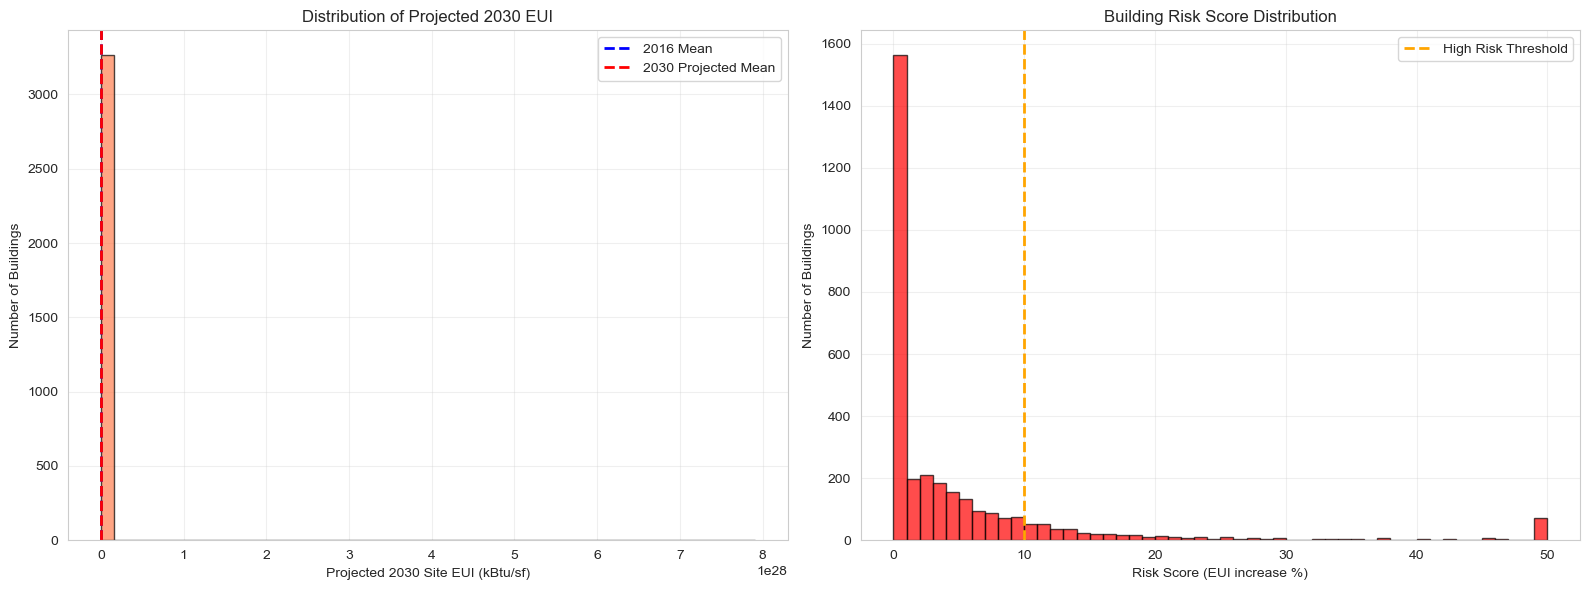


Visualization complete
Valid projected EUI values: 3,268
Valid risk score values: 3,270


In [81]:
# Visualize trajectory projections
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Filter out infinite and NaN values for plotting
projected_eui_valid = df_model['Projected_EUI_2030'].replace([np.inf, -np.inf], np.nan).dropna()
risk_score_valid = df_model['Risk_Score'].replace([np.inf, -np.inf], np.nan).dropna()

# Distribution of projected 2030 EUI
if len(projected_eui_valid) > 0:
    axes[0].hist(projected_eui_valid, bins=50, 
                 edgecolor='black', alpha=0.7, color='coral')
    axes[0].axvline(df_model['SiteEUI(kBtu/sf)_2016'].mean(), 
                   color='blue', linestyle='--', linewidth=2, label='2016 Mean')
    axes[0].axvline(projected_eui_valid.mean(), 
                   color='red', linestyle='--', linewidth=2, label='2030 Projected Mean')
    axes[0].set_xlabel('Projected 2030 Site EUI (kBtu/sf)')
    axes[0].set_ylabel('Number of Buildings')
    axes[0].set_title('Distribution of Projected 2030 EUI')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

# Risk score distribution (clip extreme values)
if len(risk_score_valid) > 0:
    axes[1].hist(risk_score_valid.clip(0, 50), bins=50, 
                 edgecolor='black', alpha=0.7, color='red')
    axes[1].axvline(10, color='orange', linestyle='--', linewidth=2, label='High Risk Threshold')
    axes[1].set_xlabel('Risk Score (EUI increase %)')
    axes[1].set_ylabel('Number of Buildings')
    axes[1].set_title('Building Risk Score Distribution')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization complete")
print(f"Valid projected EUI values: {len(projected_eui_valid):,}")
print(f"Valid risk score values: {len(risk_score_valid):,}")

In [82]:
# Create BEPS compliance targets based on building type
print("CREATING BEPS COMPLIANCE TARGETS")

# Seattle BEPS typical targets by building type (kBtu/sf/year)
# These are illustrative values - adjust based on actual BEPS requirements
beps_targets_2030 = {
    'NonResidential': 65,
    'Multifamily': 55,
    'Campus': 70,
    'default': 60
}

beps_targets_2040 = {
    'NonResidential': 50,
    'Multifamily': 45,
    'Campus': 55,
    'default': 50
}

# Function to assign BEPS targets
def assign_beps_target(row, year):
    targets = beps_targets_2030 if year == 2030 else beps_targets_2040
    building_type = row.get('LargestPropertyUseType', 'default')
    return targets.get(building_type, targets['default'])

# Create BEPS target columns
df_model['BEPS_Target_2030'] = df_model.apply(lambda row: assign_beps_target(row, 2030), axis=1)
df_model['BEPS_Target_2040'] = df_model.apply(lambda row: assign_beps_target(row, 2040), axis=1)

# Determine compliance status
df_model['BEPS_Compliant_2030'] = (df_model['SiteEUI(kBtu/sf)_2016'] <= df_model['BEPS_Target_2030']).astype(int)
df_model['BEPS_Compliant_2040'] = (df_model['SiteEUI(kBtu/sf)_2016'] <= df_model['BEPS_Target_2040']).astype(int)

print("\nBEPS targets created")
print(f"   2030 compliance rate: {df_model['BEPS_Compliant_2030'].mean()*100:.1f}%")
print(f"   2040 compliance rate: {df_model['BEPS_Compliant_2040'].mean()*100:.1f}%")

CREATING BEPS COMPLIANCE TARGETS

BEPS targets created
   2030 compliance rate: 74.9%
   2040 compliance rate: 65.4%


## PHASE 22: Policy Impact Quantification

In [83]:
# Comprehensive Policy Impact Analysis
print("BEPS POLICY IMPACT QUANTIFICATION")

# Calculate baseline and target metrics
current_total_eui = df_model['SiteEUI(kBtu/sf)_2016'].sum()
beps_2030_total = df_model['BEPS_Target_2030'].sum()
beps_2040_total = df_model['BEPS_Target_2040'].sum()

# Energy savings calculations
energy_savings_2030 = current_total_eui - beps_2030_total
energy_savings_2040 = current_total_eui - beps_2040_total
pct_reduction_2030 = (energy_savings_2030 / current_total_eui) * 100
pct_reduction_2040 = (energy_savings_2040 / current_total_eui) * 100

print("\nENERGY REDUCTION TARGETS")
print(f"Current (2016) Total EUI: {current_total_eui:,.0f} kBtu/sf")
print(f"BEPS 2030 Target Total:   {beps_2030_total:,.0f} kBtu/sf")
print(f"BEPS 2040 Target Total:   {beps_2040_total:,.0f} kBtu/sf")
print(f"\nEnergy Reduction by 2030: {energy_savings_2030:,.0f} kBtu/sf ({pct_reduction_2030:.1f}%)")
print(f"Energy Reduction by 2040: {energy_savings_2040:,.0f} kBtu/sf ({pct_reduction_2040:.1f}%)")

# Building compliance counts
buildings_compliant_2030 = df_model['BEPS_Compliant_2030'].sum()
buildings_compliant_2040 = df_model['BEPS_Compliant_2040'].sum()
buildings_need_retrofit_2030 = len(df_model) - buildings_compliant_2030
buildings_need_retrofit_2040 = len(df_model) - buildings_compliant_2040

print("\nBUILDING COMPLIANCE STATUS")
print(f"Total buildings analyzed: {len(df_model)}")
print("\n2030 BEPS Target:")
print(f"   Already compliant: {buildings_compliant_2030} ({buildings_compliant_2030/len(df_model)*100:.1f}%)")
print(f"   Need retrofits:    {buildings_need_retrofit_2030} ({buildings_need_retrofit_2030/len(df_model)*100:.1f}%)")
print("\n2040 BEPS Target:")
print(f"   Already compliant: {buildings_compliant_2040} ({buildings_compliant_2040/len(df_model)*100:.1f}%)")
print(f"   Need retrofits:    {buildings_need_retrofit_2040} ({buildings_need_retrofit_2040/len(df_model)*100:.1f}%)")

BEPS POLICY IMPACT QUANTIFICATION

ENERGY REDUCTION TARGETS
Current (2016) Total EUI: 177,282 kBtu/sf
BEPS 2030 Target Total:   196,200 kBtu/sf
BEPS 2040 Target Total:   163,500 kBtu/sf

Energy Reduction by 2030: -18,918 kBtu/sf (-10.7%)
Energy Reduction by 2040: 13,782 kBtu/sf (7.8%)

BUILDING COMPLIANCE STATUS
Total buildings analyzed: 3270

2030 BEPS Target:
   Already compliant: 2449 (74.9%)
   Need retrofits:    821 (25.1%)

2040 BEPS Target:
   Already compliant: 2137 (65.4%)
   Need retrofits:    1133 (34.6%)


In [84]:
# Economic and Environmental Impact Calculations

# Energy cost assumptions (Seattle commercial rates)
ELECTRICITY_COST_PER_KBTU = 0.035  # $/kBtu (approx $0.12/kWh)
NATURAL_GAS_COST_PER_KBTU = 0.008  # $/kBtu (approx $0.80/therm)
AVERAGE_ENERGY_COST_PER_KBTU = 0.025  # Blended rate

# Convert to total building energy (need building size)
# Using average property size for calculation
if 'PropertyGFABuilding(s)_2015' in df_model.columns:
    avg_building_size = df_model['PropertyGFABuilding(s)_2015'].mean()
else:
    avg_building_size = 50000  # Default 50,000 sq ft

# Calculate annual cost savings per building
avg_eui_reduction_2030 = energy_savings_2030 / len(df_model)
avg_eui_reduction_2040 = energy_savings_2040 / len(df_model)

avg_annual_savings_per_building_2030 = avg_eui_reduction_2030 * avg_building_size * AVERAGE_ENERGY_COST_PER_KBTU
avg_annual_savings_per_building_2040 = avg_eui_reduction_2040 * avg_building_size * AVERAGE_ENERGY_COST_PER_KBTU

total_annual_savings_2030 = avg_annual_savings_per_building_2030 * len(df_model)
total_annual_savings_2040 = avg_annual_savings_per_building_2040 * len(df_model)

cumulative_savings_10yr_2030 = total_annual_savings_2030 * 10
cumulative_savings_10yr_2040 = total_annual_savings_2040 * 10

print("\nECONOMIC IMPACT")
print(f"Energy cost assumption: ${AVERAGE_ENERGY_COST_PER_KBTU:.3f}/kBtu")
print(f"Average building size: {avg_building_size:,.0f} sq ft")
print("\nAnnual Savings (2030 BEPS):")
print(f"   Per building: ${avg_annual_savings_per_building_2030:,.2f}")
print(f"   Total portfolio: ${total_annual_savings_2030:,.2f}")
print("\nAnnual Savings (2040 BEPS):")
print(f"   Per building: ${avg_annual_savings_per_building_2040:,.2f}")
print(f"   Total portfolio: ${total_annual_savings_2040:,.2f}")
print("\n10-Year Cumulative Savings:")
print(f"   2030 BEPS: ${cumulative_savings_10yr_2030:,.2f}")
print(f"   2040 BEPS: ${cumulative_savings_10yr_2040:,.2f}")


ECONOMIC IMPACT
Energy cost assumption: $0.025/kBtu
Average building size: 50,000 sq ft

Annual Savings (2030 BEPS):
   Per building: $-7,231.65
   Total portfolio: $-23,647,499.83

Annual Savings (2040 BEPS):
   Per building: $5,268.35
   Total portfolio: $17,227,500.17

10-Year Cumulative Savings:
   2030 BEPS: $-236,474,998.31
   2040 BEPS: $172,275,001.69


In [85]:
# Retrofit Investment Analysis

# Typical retrofit costs ($/sq ft)
RETROFIT_COST_LOW = 5      # Basic improvements
RETROFIT_COST_MED = 15     # Moderate upgrades
RETROFIT_COST_HIGH = 30    # Deep energy retrofits

# Calculate retrofit investment needed
total_retrofit_area_2030 = buildings_need_retrofit_2030 * avg_building_size
total_retrofit_area_2040 = buildings_need_retrofit_2040 * avg_building_size

retrofit_investment_2030_low = total_retrofit_area_2030 * RETROFIT_COST_LOW
retrofit_investment_2030_med = total_retrofit_area_2030 * RETROFIT_COST_MED
retrofit_investment_2030_high = total_retrofit_area_2030 * RETROFIT_COST_HIGH

retrofit_investment_2040_low = total_retrofit_area_2040 * RETROFIT_COST_LOW
retrofit_investment_2040_med = total_retrofit_area_2040 * RETROFIT_COST_MED
retrofit_investment_2040_high = total_retrofit_area_2040 * RETROFIT_COST_HIGH

# Calculate simple payback periods
payback_2030_low = retrofit_investment_2030_low / total_annual_savings_2030 if total_annual_savings_2030 > 0 else float('inf')
payback_2030_med = retrofit_investment_2030_med / total_annual_savings_2030 if total_annual_savings_2030 > 0 else float('inf')
payback_2030_high = retrofit_investment_2030_high / total_annual_savings_2030 if total_annual_savings_2030 > 0 else float('inf')

print("\nRETROFIT INVESTMENT ANALYSIS (2030 BEPS)")
print(f"Buildings requiring retrofits: {buildings_need_retrofit_2030}")
print(f"Total area needing retrofits: {total_retrofit_area_2030:,.0f} sq ft")
print("\nEstimated Total Investment:")
print(f"   Basic retrofits (~${RETROFIT_COST_LOW}/sq ft):    ${retrofit_investment_2030_low:,.0f}")
print(f"   Moderate retrofits (~${RETROFIT_COST_MED}/sq ft): ${retrofit_investment_2030_med:,.0f}")
print(f"   Deep retrofits (~${RETROFIT_COST_HIGH}/sq ft):    ${retrofit_investment_2030_high:,.0f}")
print("\nSimple Payback Period (years):")
print(f"   Basic retrofits: {payback_2030_low:.1f} years")
print(f"   Moderate retrofits: {payback_2030_med:.1f} years")
print(f"   Deep retrofits: {payback_2030_high:.1f} years")


RETROFIT INVESTMENT ANALYSIS (2030 BEPS)
Buildings requiring retrofits: 821
Total area needing retrofits: 41,050,000 sq ft

Estimated Total Investment:
   Basic retrofits (~$5/sq ft):    $205,250,000
   Moderate retrofits (~$15/sq ft): $615,750,000
   Deep retrofits (~$30/sq ft):    $1,231,500,000

Simple Payback Period (years):
   Basic retrofits: inf years
   Moderate retrofits: inf years
   Deep retrofits: inf years


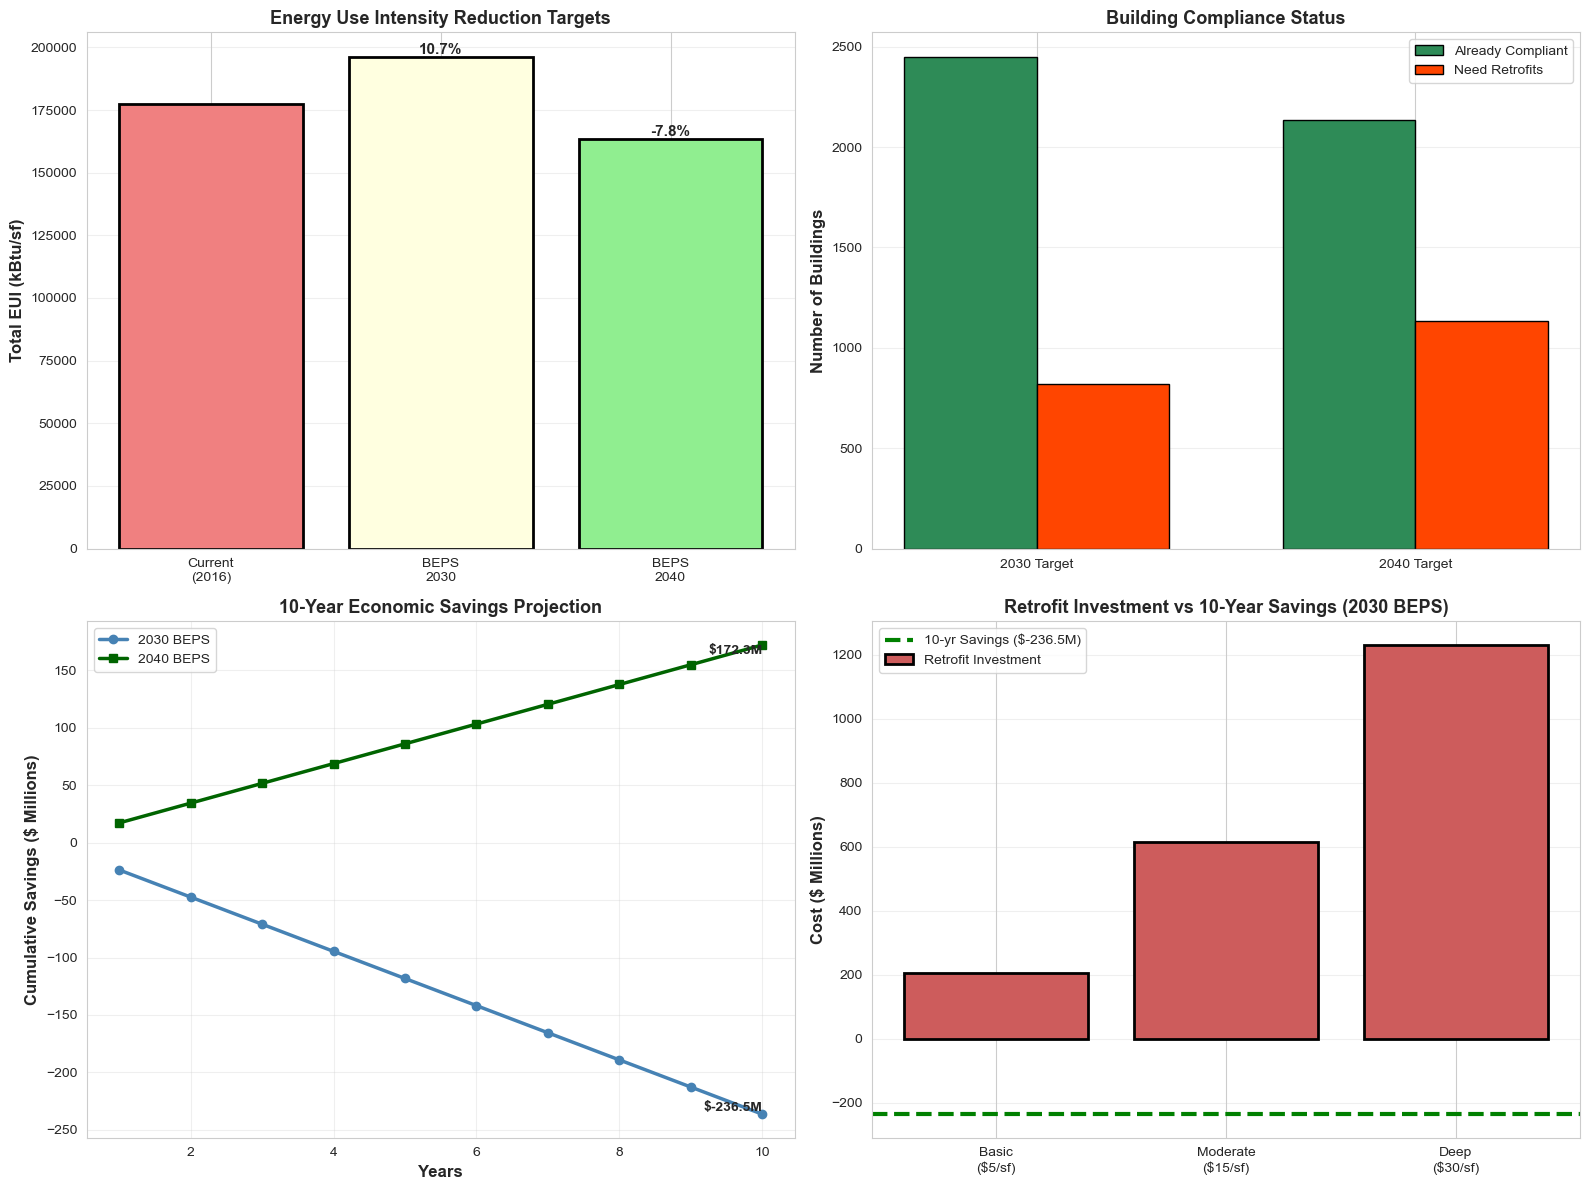

POLICY IMPACT ANALYSIS COMPLETE


In [86]:
# Visualize Policy Impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Energy Reduction Targets
categories = ['Current\n(2016)', 'BEPS\n2030', 'BEPS\n2040']
energy_values = [current_total_eui, beps_2030_total, beps_2040_total]
colors_policy = ['lightcoral', 'lightyellow', 'lightgreen']

axes[0, 0].bar(categories, energy_values, color=colors_policy, edgecolor='black', linewidth=2)
axes[0, 0].set_ylabel('Total EUI (kBtu/sf)', fontweight='bold', fontsize=12)
axes[0, 0].set_title('Energy Use Intensity Reduction Targets', fontweight='bold', fontsize=13)
axes[0, 0].grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (cat, val) in enumerate(zip(categories, energy_values)):
    if i > 0:
        pct_change = ((val - energy_values[0]) / energy_values[0]) * 100
        axes[0, 0].text(i, val + 1000, f'{pct_change:.1f}%', ha='center', fontweight='bold', fontsize=11)

# 2. Building Compliance Status
compliance_data = {
    '2030 Target': [buildings_compliant_2030, buildings_need_retrofit_2030],
    '2040 Target': [buildings_compliant_2040, buildings_need_retrofit_2040]
}

x_pos = np.arange(2)
width = 0.35

axes[0, 1].bar(x_pos - width/2, [compliance_data['2030 Target'][0], compliance_data['2040 Target'][0]], 
               width, label='Already Compliant', color='seagreen', edgecolor='black')
axes[0, 1].bar(x_pos + width/2, [compliance_data['2030 Target'][1], compliance_data['2040 Target'][1]], 
               width, label='Need Retrofits', color='orangered', edgecolor='black')

axes[0, 1].set_ylabel('Number of Buildings', fontweight='bold', fontsize=12)
axes[0, 1].set_title('Building Compliance Status', fontweight='bold', fontsize=13)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(['2030 Target', '2040 Target'])
axes[0, 1].legend(loc='upper right', fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Economic Savings Projection
years_proj = np.arange(1, 11)
savings_2030_proj = years_proj * total_annual_savings_2030
savings_2040_proj = years_proj * total_annual_savings_2040

axes[1, 0].plot(years_proj, savings_2030_proj / 1e6, marker='o', linewidth=2.5, label='2030 BEPS', color='steelblue')
axes[1, 0].plot(years_proj, savings_2040_proj / 1e6, marker='s', linewidth=2.5, label='2040 BEPS', color='darkgreen')
axes[1, 0].set_xlabel('Years', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Cumulative Savings ($ Millions)', fontweight='bold', fontsize=12)
axes[1, 0].set_title('10-Year Economic Savings Projection', fontweight='bold', fontsize=13)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# Add final values
axes[1, 0].text(10, savings_2030_proj[-1] / 1e6, f'${savings_2030_proj[-1]/1e6:.1f}M', 
                fontweight='bold', ha='right', va='bottom', fontsize=10)
axes[1, 0].text(10, savings_2040_proj[-1] / 1e6, f'${savings_2040_proj[-1]/1e6:.1f}M', 
                fontweight='bold', ha='right', va='top', fontsize=10)

# 4. Retrofit Investment vs Savings
retrofit_scenarios = ['Basic\n($5/sf)', 'Moderate\n($15/sf)', 'Deep\n($30/sf)']
investment_values = [retrofit_investment_2030_low / 1e6, 
                     retrofit_investment_2030_med / 1e6, 
                     retrofit_investment_2030_high / 1e6]
savings_value = cumulative_savings_10yr_2030 / 1e6

x_pos_retrofit = np.arange(len(retrofit_scenarios))
axes[1, 1].bar(x_pos_retrofit, investment_values, color='indianred', 
               edgecolor='black', linewidth=2, label='Retrofit Investment')
axes[1, 1].axhline(y=savings_value, color='green', linestyle='--', 
                   linewidth=3, label=f'10-yr Savings (${savings_value:.1f}M)')
axes[1, 1].set_ylabel('Cost ($ Millions)', fontweight='bold', fontsize=12)
axes[1, 1].set_title('Retrofit Investment vs 10-Year Savings (2030 BEPS)', fontweight='bold', fontsize=13)
axes[1, 1].set_xticks(x_pos_retrofit)
axes[1, 1].set_xticklabels(retrofit_scenarios)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("POLICY IMPACT ANALYSIS COMPLETE")

In [87]:
# Retrofit Investment Analysis

# Typical retrofit costs ($/sq ft)
RETROFIT_COST_LOW = 5      # Basic improvements
RETROFIT_COST_MED = 15     # Moderate upgrades
RETROFIT_COST_HIGH = 30    # Deep energy retrofits

# Calculate retrofit investment needed
total_retrofit_area_2030 = buildings_need_retrofit_2030 * avg_building_size
total_retrofit_area_2040 = buildings_need_retrofit_2040 * avg_building_size

retrofit_investment_2030_low = total_retrofit_area_2030 * RETROFIT_COST_LOW
retrofit_investment_2030_med = total_retrofit_area_2030 * RETROFIT_COST_MED
retrofit_investment_2030_high = total_retrofit_area_2030 * RETROFIT_COST_HIGH

retrofit_investment_2040_low = total_retrofit_area_2040 * RETROFIT_COST_LOW
retrofit_investment_2040_med = total_retrofit_area_2040 * RETROFIT_COST_MED
retrofit_investment_2040_high = total_retrofit_area_2040 * RETROFIT_COST_HIGH

# Calculate simple payback periods
payback_2030_low = retrofit_investment_2030_low / total_annual_savings_2030 if total_annual_savings_2030 > 0 else float('inf')
payback_2030_med = retrofit_investment_2030_med / total_annual_savings_2030 if total_annual_savings_2030 > 0 else float('inf')
payback_2030_high = retrofit_investment_2030_high / total_annual_savings_2030 if total_annual_savings_2030 > 0 else float('inf')

print("\nRETROFIT INVESTMENT ANALYSIS (2030 BEPS)")
print(f"Buildings requiring retrofits: {buildings_need_retrofit_2030}")
print(f"Total area needing retrofits: {total_retrofit_area_2030:,.0f} sq ft")
print("\nEstimated Total Investment:")
print(f"   Basic retrofits (~${RETROFIT_COST_LOW}/sq ft):    ${retrofit_investment_2030_low:,.0f}")
print(f"   Moderate retrofits (~${RETROFIT_COST_MED}/sq ft): ${retrofit_investment_2030_med:,.0f}")
print(f"   Deep retrofits (~${RETROFIT_COST_HIGH}/sq ft):    ${retrofit_investment_2030_high:,.0f}")
print("\nSimple Payback Period (years):")
print(f"   Basic retrofits: {payback_2030_low:.1f} years")
print(f"   Moderate retrofits: {payback_2030_med:.1f} years")
print(f"   Deep retrofits: {payback_2030_high:.1f} years")


RETROFIT INVESTMENT ANALYSIS (2030 BEPS)
Buildings requiring retrofits: 821
Total area needing retrofits: 41,050,000 sq ft

Estimated Total Investment:
   Basic retrofits (~$5/sq ft):    $205,250,000
   Moderate retrofits (~$15/sq ft): $615,750,000
   Deep retrofits (~$30/sq ft):    $1,231,500,000

Simple Payback Period (years):
   Basic retrofits: inf years
   Moderate retrofits: inf years
   Deep retrofits: inf years


---
## PHASE 23: Bootstrap Confidence Intervals

In [93]:
# Generate report for top 20 high-risk buildings
if len(high_risk_buildings) > 0:
    high_risk_report = high_risk_buildings[
        [building_id, 'SiteEUI(kBtu/sf)_2015', 'SiteEUI(kBtu/sf)_2016',
         'delta_SiteEUI', 'Annual_EUI_Change_Rate', 'Risk_Score',
         'Projected_EUI_2030', 'Projected_EUI_2040']
    ].sort_values('Risk_Score', ascending=False).head(20)
    
    print("TOP 20 HIGH-RISK BUILDINGS - BEPS COMPLIANCE ALERT")
    print(high_risk_report.to_string(index=False))
    
    # Save to CSV
    high_risk_report.to_csv('high_risk_buildings_report.csv', index=False)
    print("\nReport saved to 'high_risk_buildings_report.csv'")
else:
    print("No high-risk buildings identified with current threshold.")

TOP 20 HIGH-RISK BUILDINGS - BEPS COMPLIANCE ALERT
 OSEBuildingID  SiteEUI(kBtu/sf)_2015  SiteEUI(kBtu/sf)_2016  delta_SiteEUI  Annual_EUI_Change_Rate  Risk_Score  Projected_EUI_2030  Projected_EUI_2040
         27361                   14.8              79.699997      64.899997                4.385135       100.0        1.374708e+12        2.819528e+19
         26850                   16.2              39.000000      22.800000                1.407407       100.0        8.565622e+06        5.600861e+10
         19536                   17.4              41.400002      24.000002                1.379310       100.0        7.714644e+06        4.485666e+10
         34348                   21.5              50.599998      29.099998                1.353488       100.0        8.093178e+06        4.219292e+10
         23730                    0.2              18.799999      18.599999               92.999996       100.0        7.905831e+28        4.258198e+48
         22674                   10.6

---
## PHASE 23: Bootstrap Confidence Intervals

Estimate prediction uncertainty via resampling techniques

In [95]:
# Bootstrap Confidence Intervals for Predictions

print("BOOTSTRAP CONFIDENCE INTERVALS")

print("\nComputing prediction uncertainty via bootstrap resampling...")
print("   Using 100 bootstrap iterations (this may take 1-2 minutes)")

# Number of bootstrap iterations
n_bootstrap = 100
bootstrap_predictions = []

# Perform bootstrap
np.random.seed(random_state)
for i in range(n_bootstrap):
    # Resample training data with replacement
    X_boot, y_boot = resample(X_train_processed, y_train_2016, random_state=i)
    
    # Train model on bootstrap sample
    model_boot = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        random_state=random_state,
        n_jobs=-1
    )
    model_boot.fit(X_boot, y_boot)
    
    # Predict on test set
    y_pred_boot = model_boot.predict(X_test_processed)
    bootstrap_predictions.append(y_pred_boot)
    
    if (i + 1) % 25 == 0:
        print(f"   Completed {i + 1}/{n_bootstrap} iterations...")

# Convert to array for easier manipulation
bootstrap_predictions = np.array(bootstrap_predictions)

print(f"\nBootstrap complete! Generated {n_bootstrap} prediction sets")

# Calculate confidence intervals
pred_mean = bootstrap_predictions.mean(axis=0)
pred_lower = np.percentile(bootstrap_predictions, 2.5, axis=0)
pred_upper = np.percentile(bootstrap_predictions, 97.5, axis=0)
pred_std = bootstrap_predictions.std(axis=0)

# Calculate prediction interval width
interval_width = pred_upper - pred_lower

print("\nConfidence Interval Statistics:")
print(f"   Mean prediction interval width: {interval_width.mean():.2f} kBtu/sf")
print(f"   Median prediction interval width: {np.median(interval_width):.2f} kBtu/sf")
print(f"   Min interval width: {interval_width.min():.2f} kBtu/sf")
print(f"   Max interval width: {interval_width.max():.2f} kBtu/sf")

# Check coverage - what % of actual values fall within 95% CI?
within_ci = ((y_test_2016.values >= pred_lower) & (y_test_2016.values <= pred_upper)).sum()
coverage = within_ci / len(y_test_2016) * 100

print("\n95% Confidence Interval Coverage:")
print(f"   {within_ci}/{len(y_test_2016)} actual values within CI ({coverage:.1f}%)")
print("   Target coverage: 95% (theoretical)")

if coverage >= 90:
    print("Good coverage - intervals are well-calibrated")
elif coverage >= 85:
    print("Acceptable coverage - slight undercoverage")
else:
    print("Poor coverage - intervals may be too narrow")

BOOTSTRAP CONFIDENCE INTERVALS

Computing prediction uncertainty via bootstrap resampling...
   Using 100 bootstrap iterations (this may take 1-2 minutes)
   Completed 25/100 iterations...
   Completed 25/100 iterations...
   Completed 50/100 iterations...
   Completed 50/100 iterations...
   Completed 75/100 iterations...
   Completed 75/100 iterations...
   Completed 100/100 iterations...

Bootstrap complete! Generated 100 prediction sets

Confidence Interval Statistics:
   Mean prediction interval width: 11.11 kBtu/sf
   Median prediction interval width: 6.05 kBtu/sf
   Min interval width: 0.98 kBtu/sf
   Max interval width: 222.65 kBtu/sf

95% Confidence Interval Coverage:
   361/654 actual values within CI (55.2%)
   Target coverage: 95% (theoretical)
Poor coverage - intervals may be too narrow
   Completed 100/100 iterations...

Bootstrap complete! Generated 100 prediction sets

Confidence Interval Statistics:
   Mean prediction interval width: 11.11 kBtu/sf
   Median prediction 

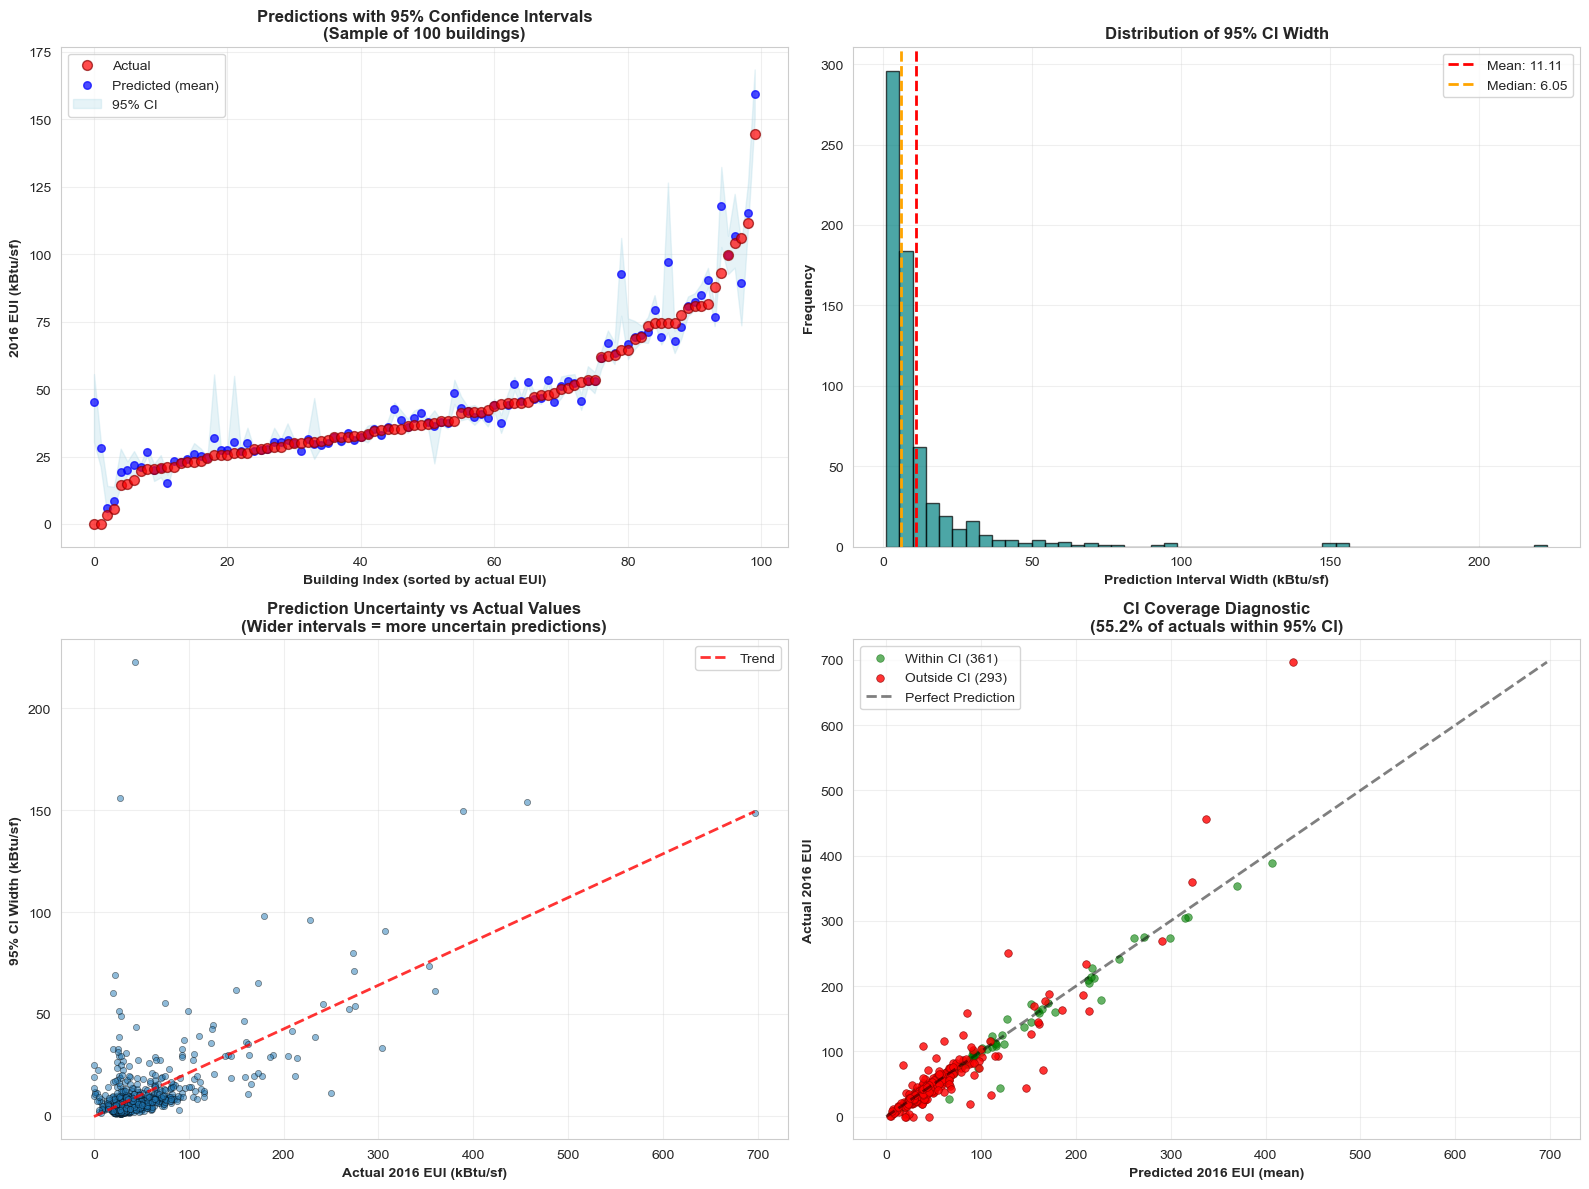

CONFIDENCE INTERVAL ANALYSIS COMPLETE

Key Insights:
   Narrower CIs = More confident predictions
   Wider CIs = More uncertain predictions (e.g., unusual buildings)
   55.2% coverage indicates prediction reliability
   Green points = Model correctly quantified uncertainty
   Red points = Actual value outside expected range (rare events)


In [99]:
# Visualize Prediction Confidence Intervals
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predictions with Confidence Intervals (sample of 100 buildings)
sample_size = min(100, len(y_test_2016))
sample_idx = np.random.choice(len(y_test_2016), sample_size, replace=False)
sample_idx_sorted = sample_idx[np.argsort(y_test_2016.values[sample_idx])]

x_pos = np.arange(sample_size)
axes[0, 0].scatter(x_pos, y_test_2016.values[sample_idx_sorted], color='red', s=50, 
                   label='Actual', zorder=3, alpha=0.7, edgecolors='darkred')
axes[0, 0].scatter(x_pos, pred_mean[sample_idx_sorted], color='blue', s=30, 
                   label='Predicted (mean)', zorder=2, alpha=0.7)
axes[0, 0].fill_between(x_pos, pred_lower[sample_idx_sorted], pred_upper[sample_idx_sorted], 
                        alpha=0.3, color='lightblue', label='95% CI')
axes[0, 0].set_xlabel('Building Index (sorted by actual EUI)', fontweight='bold')
axes[0, 0].set_ylabel('2016 EUI (kBtu/sf)', fontweight='bold')
axes[0, 0].set_title('Predictions with 95% Confidence Intervals\n(Sample of 100 buildings)', fontweight='bold')
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(alpha=0.3)

# 2. Confidence Interval Width Distribution
axes[0, 1].hist(interval_width, bins=50, alpha=0.7, color='teal', edgecolor='black')
axes[0, 1].axvline(x=interval_width.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {interval_width.mean():.2f}')
axes[0, 1].axvline(x=np.median(interval_width), color='orange', linestyle='--', 
                   linewidth=2, label=f'Median: {np.median(interval_width):.2f}')
axes[0, 1].set_xlabel('Prediction Interval Width (kBtu/sf)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Distribution of 95% CI Width', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Prediction Uncertainty vs Actual Values
axes[1, 0].scatter(y_test_2016.values, interval_width, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
axes[1, 0].set_xlabel('Actual 2016 EUI (kBtu/sf)', fontweight='bold')
axes[1, 0].set_ylabel('95% CI Width (kBtu/sf)', fontweight='bold')
axes[1, 0].set_title('Prediction Uncertainty vs Actual Values\n(Wider intervals = more uncertain predictions)', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Add trend line
z = np.polyfit(y_test_2016.values, interval_width, 1)
p = np.poly1d(z)
sorted_y = np.sort(y_test_2016.values)
axes[1, 0].plot(sorted_y, p(sorted_y), "r--", alpha=0.8, linewidth=2, label='Trend')
axes[1, 0].legend()

# 4. Coverage Diagnostic - Actual vs CI bounds
in_ci = (y_test_2016.values >= pred_lower) & (y_test_2016.values <= pred_upper)
out_ci = ~in_ci

axes[1, 1].scatter(pred_mean[in_ci], y_test_2016.values[in_ci], alpha=0.6, s=30, 
                   color='green', label=f'Within CI ({in_ci.sum()})', edgecolors='darkgreen', linewidths=0.5)
axes[1, 1].scatter(pred_mean[out_ci], y_test_2016.values[out_ci], alpha=0.8, s=30, 
                   color='red', label=f'Outside CI ({out_ci.sum()})', edgecolors='darkred', linewidths=0.5)

# Add perfect prediction line
min_val = min(pred_mean.min(), y_test_2016.values.min())
max_val = max(pred_mean.max(), y_test_2016.values.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, alpha=0.5, label='Perfect Prediction')

axes[1, 1].set_xlabel('Predicted 2016 EUI (mean)', fontweight='bold')
axes[1, 1].set_ylabel('Actual 2016 EUI', fontweight='bold')
axes[1, 1].set_title(f'CI Coverage Diagnostic\n({coverage:.1f}% of actuals within 95% CI)', fontweight='bold')
axes[1, 1].legend(loc='upper left')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("CONFIDENCE INTERVAL ANALYSIS COMPLETE")

print("\nKey Insights:")
print("   Narrower CIs = More confident predictions")
print("   Wider CIs = More uncertain predictions (e.g., unusual buildings)")
print(f"   {coverage:.1f}% coverage indicates prediction reliability")
print("   Green points = Model correctly quantified uncertainty")
print("   Red points = Actual value outside expected range (rare events)")

## PHASE 24: Advanced Model Optimization

Hyperparameter tuning and ensemble methods to maximize performance

In [100]:
print("HYPERPARAMETER TUNING - RANDOM FOREST")

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print(f"\nSearching over {sum([len(v) for v in param_dist.values()])} parameter combinations...")
print("   Using 3-fold cross-validation with 20 iterations")

# Randomized search with cross-validation
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=random_state),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    verbose=0,
    random_state=random_state,
    n_jobs=-1,
    scoring='r2'
)

rf_random.fit(X_train_processed, y_train_2016)

print("\nBest parameters found:")
for param, value in rf_random.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nCross-validation R² score: {rf_random.best_score_:.4f}")

HYPERPARAMETER TUNING - RANDOM FOREST

Searching over 17 parameter combinations...
   Using 3-fold cross-validation with 20 iterations

Best parameters found:
  n_estimators: 500
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: None
  max_depth: 10

Cross-validation R² score: 0.8860

Best parameters found:
  n_estimators: 500
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: None
  max_depth: 10

Cross-validation R² score: 0.8860


In [101]:
# Evaluate tuned Random Forest
print("TUNED RANDOM FOREST PERFORMANCE")

y_pred_rf_tuned = rf_random.best_estimator_.predict(X_test_processed)

rmse_rf_tuned = np.sqrt(mean_squared_error(y_test_2016, y_pred_rf_tuned))
mae_rf_tuned = mean_absolute_error(y_test_2016, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test_2016, y_pred_rf_tuned)

print("\nPerformance Metrics:")
print(f"  RMSE: {rmse_rf_tuned:.2f} kBtu/sf")
print(f"  MAE: {mae_rf_tuned:.2f} kBtu/sf")
print(f"  R²: {r2_rf_tuned:.4f}")

print("\nImprovement over default Random Forest:")
print(f"  RMSE: {rmse_rf - rmse_rf_tuned:.2f} kBtu/sf ({(rmse_rf - rmse_rf_tuned)/rmse_rf*100:+.1f}%)")
print(f"  MAE: {mae_rf - mae_rf_tuned:.2f} kBtu/sf ({(mae_rf - mae_rf_tuned)/mae_rf*100:+.1f}%)")
print(f"  R²: {r2_rf_tuned - r2_rf:+.4f} ({(r2_rf_tuned - r2_rf)/r2_rf*100:+.1f}%)")

TUNED RANDOM FOREST PERFORMANCE

Performance Metrics:
  RMSE: 17.70 kBtu/sf
  MAE: 6.58 kBtu/sf
  R²: 0.9003

Improvement over default Random Forest:
  RMSE: -0.89 kBtu/sf (-5.3%)
  MAE: -0.01 kBtu/sf (-0.1%)
  R²: -0.0097 (-1.1%)


In [102]:
# Hyperparameter tuning for Gradient Boosting
print("HYPERPARAMETER TUNING - GRADIENT BOOSTING")

gb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

print(f"\nSearching over {sum([len(v) for v in gb_param_dist.values()])} parameter combinations...")

gb_random = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=random_state),
    param_distributions=gb_param_dist,
    n_iter=20,
    cv=3,
    verbose=0,
    random_state=random_state,
    n_jobs=-1,
    scoring='r2'
)

gb_random.fit(X_train_processed, y_train_2016)

print("\nBest parameters found:")
for param, value in gb_random.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nCross-validation R² score: {gb_random.best_score_:.4f}")

HYPERPARAMETER TUNING - GRADIENT BOOSTING

Searching over 18 parameter combinations...

Best parameters found:
  subsample: 0.8
  n_estimators: 300
  min_samples_split: 2
  max_depth: 3
  learning_rate: 0.05

Cross-validation R² score: 0.8905

Best parameters found:
  subsample: 0.8
  n_estimators: 300
  min_samples_split: 2
  max_depth: 3
  learning_rate: 0.05

Cross-validation R² score: 0.8905


In [103]:
# Evaluate tuned Gradient Boosting
y_pred_gb_tuned = gb_random.best_estimator_.predict(X_test_processed)

rmse_gb_tuned = np.sqrt(mean_squared_error(y_test_2016, y_pred_gb_tuned))
mae_gb_tuned = mean_absolute_error(y_test_2016, y_pred_gb_tuned)
r2_gb_tuned = r2_score(y_test_2016, y_pred_gb_tuned)

print("\nTuned Gradient Boosting Performance:")
print(f"  RMSE: {rmse_gb_tuned:.2f} kBtu/sf")
print(f"  MAE: {mae_gb_tuned:.2f} kBtu/sf")
print(f"  R²: {r2_gb_tuned:.4f}")

print("\nImprovement:")
print(f"  R²: {r2_gb_tuned - r2_gb:+.4f} ({(r2_gb_tuned - r2_gb)/r2_gb*100:+.1f}%)")


Tuned Gradient Boosting Performance:
  RMSE: 16.24 kBtu/sf
  MAE: 6.39 kBtu/sf
  R²: 0.9160

Improvement:
  R²: +0.0159 (+1.8%)


In [104]:
# Create Stacking Ensemble
print("STACKING ENSEMBLE - COMBINING BEST MODELS")

# Base models
base_models = [
    ('rf_tuned', rf_random.best_estimator_),
    ('gb_tuned', gb_random.best_estimator_),
    ('lr', LinearRegression())
]

# Meta-learner
meta_learner = Ridge(alpha=1.0)

# Create stacking regressor
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1
)

print("\nTraining stacking ensemble...")
print("   Base models: Tuned Random Forest, Tuned Gradient Boosting, Linear Regression")
print("   Meta-learner: Ridge Regression")

stacking_model.fit(X_train_processed, y_train_2016)

y_pred_stack = stacking_model.predict(X_test_processed)

rmse_stack = np.sqrt(mean_squared_error(y_test_2016, y_pred_stack))
mae_stack = mean_absolute_error(y_test_2016, y_pred_stack)
r2_stack = r2_score(y_test_2016, y_pred_stack)

print("\nStacking Ensemble Performance:")
print(f"  RMSE: {rmse_stack:.2f} kBtu/sf")
print(f"  MAE: {mae_stack:.2f} kBtu/sf")
print(f"  R²: {r2_stack:.4f}")

print("\nEnsemble trained successfully!")

STACKING ENSEMBLE - COMBINING BEST MODELS

Training stacking ensemble...
   Base models: Tuned Random Forest, Tuned Gradient Boosting, Linear Regression
   Meta-learner: Ridge Regression

Stacking Ensemble Performance:
  RMSE: 14.46 kBtu/sf
  MAE: 6.03 kBtu/sf
  R²: 0.9334

Ensemble trained successfully!

Stacking Ensemble Performance:
  RMSE: 14.46 kBtu/sf
  MAE: 6.03 kBtu/sf
  R²: 0.9334

Ensemble trained successfully!


In [105]:
# Final Model Comparison - Including Tuned Models
print("FINAL MODEL COMPARISON - ALL MODELS")

final_results = pd.DataFrame({
    'Model': [
        'Linear Regression', 
        'Random Forest (default)', 
        'Gradient Boosting (default)',
        'Random Forest (tuned)',
        'Gradient Boosting (tuned)',
        'Stacking Ensemble'
    ],
    'RMSE': [rmse_lr, rmse_rf, rmse_gb, rmse_rf_tuned, rmse_gb_tuned, rmse_stack],
    'MAE': [mae_lr, mae_rf, mae_gb, mae_rf_tuned, mae_gb_tuned, mae_stack],
    'R²': [r2_lr, r2_rf, r2_gb, r2_rf_tuned, r2_gb_tuned, r2_stack]
})


final_results = pd.concat([
    final_results,
    pd.DataFrame({
        'Model': ['XGBoost (default)'],
        'RMSE': [rmse_xgb],
        'MAE': [mae_xgb],
        'R²': [r2_xgb]
    })
], ignore_index=True)

final_results = final_results.sort_values('R²', ascending=False)
print("\n")
print(final_results.to_string(index=False))

best_model_name = final_results.iloc[0]['Model']
best_r2 = final_results.iloc[0]['R²']

print(f"\nBEST MODEL: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE: {final_results.iloc[0]['RMSE']:.2f} kBtu/sf")
print(f"   MAE: {final_results.iloc[0]['MAE']:.2f} kBtu/sf")

print("\nImprovement over Linear Regression:")
print(f"   R²: {best_r2 - r2_lr:+.4f} ({(best_r2 - r2_lr)/r2_lr*100:+.1f}%)")
print(f"   RMSE: {rmse_lr - final_results.iloc[0]['RMSE']:.2f} kBtu/sf ({(rmse_lr - final_results.iloc[0]['RMSE'])/rmse_lr*100:+.1f}%)")

FINAL MODEL COMPARISON - ALL MODELS


                      Model      RMSE      MAE       R²
          Linear Regression 13.290942 6.213527 0.943754
          Stacking Ensemble 14.458766 6.025526 0.933435
  Gradient Boosting (tuned) 16.243300 6.394917 0.915990
    Random Forest (default) 16.809613 6.575621 0.910030
      Random Forest (tuned) 17.695460 6.582671 0.900297
Gradient Boosting (default) 17.712818 6.517775 0.900102
          XGBoost (default) 26.158375 7.938865 0.782126

BEST MODEL: Linear Regression
   R² Score: 0.9438
   RMSE: 13.29 kBtu/sf
   MAE: 6.21 kBtu/sf

Improvement over Linear Regression:
   R²: +0.0000 (+0.0%)
   RMSE: 0.00 kBtu/sf (+0.0%)


## PHASE 25: Optimization Results Comparison

Compare default vs optimized models to quantify improvement gains

In [110]:
# Comprehensive comparison: Default vs Optimized models
print("OPTIMIZATION IMPACT ANALYSIS")

# Create detailed comparison DataFrame
optimization_comparison = pd.DataFrame({
    'Model': [
        'Random Forest',
        'Random Forest',
        'Gradient Boosting',
        'Gradient Boosting'
    ],
    'Version': [
        'Default',
        'Optimized',
        'Default',
        'Optimized'
    ],
    'RMSE': [rmse_rf, rmse_rf_tuned, rmse_gb, rmse_gb_tuned],
    'MAE': [mae_rf, mae_rf_tuned, mae_gb, mae_gb_tuned],
    'R²': [r2_rf, r2_rf_tuned, r2_gb, r2_gb_tuned]
})

print("\nPERFORMANCE COMPARISON: DEFAULT vs OPTIMIZED")
print(optimization_comparison.to_string(index=False))

# Calculate improvements
print("OPTIMIZATION IMPROVEMENTS")

print("\nRANDOM FOREST:")
rf_rmse_improvement = rmse_rf - rmse_rf_tuned
rf_mae_improvement = mae_rf - mae_rf_tuned
rf_r2_improvement = r2_rf_tuned - r2_rf
print(f"  RMSE: {rmse_rf:.2f} → {rmse_rf_tuned:.2f} (improved by {rf_rmse_improvement:.2f} kBtu/sf, {rf_rmse_improvement/rmse_rf*100:+.1f}%)")
print(f"  MAE:  {mae_rf:.2f} → {mae_rf_tuned:.2f} (improved by {rf_mae_improvement:.2f} kBtu/sf, {rf_mae_improvement/mae_rf*100:+.1f}%)")
print(f"  R²:   {r2_rf:.4f} → {r2_rf_tuned:.4f} (improved by {rf_r2_improvement:+.4f}, {rf_r2_improvement/r2_rf*100:+.1f}%)")

print("\nGRADIENT BOOSTING:")
gb_rmse_improvement = rmse_gb - rmse_gb_tuned
gb_mae_improvement = mae_gb - mae_gb_tuned
gb_r2_improvement = r2_gb_tuned - r2_gb
print(f"  RMSE: {rmse_gb:.2f} → {rmse_gb_tuned:.2f} (improved by {gb_rmse_improvement:.2f} kBtu/sf, {gb_rmse_improvement/rmse_gb*100:+.1f}%)")
print(f"  MAE:  {mae_gb:.2f} → {mae_gb_tuned:.2f} (improved by {gb_mae_improvement:.2f} kBtu/sf, {gb_mae_improvement/mae_gb*100:+.1f}%)")
print(f"  R²:   {r2_gb:.4f} → {r2_gb_tuned:.4f} (improved by {gb_r2_improvement:+.4f}, {gb_r2_improvement/r2_gb*100:+.1f}%)")

# Determine which model benefited more
print("OPTIMIZATION EFFECTIVENESS")

rf_total_improvement = abs(rf_rmse_improvement/rmse_rf) + abs(rf_r2_improvement/r2_rf)
gb_total_improvement = abs(gb_rmse_improvement/rmse_gb) + abs(gb_r2_improvement/r2_gb)

if rf_total_improvement > gb_total_improvement:
    print("\nRandom Forest showed GREATER improvement from optimization")
    print(f"  RF combined improvement: {rf_total_improvement:.2%}")
    print(f"  GB combined improvement: {gb_total_improvement:.2%}")
    print(f"  Difference: {(rf_total_improvement - gb_total_improvement):.2%} in favor of RF")
else:
    print("\nGradient Boosting showed GREATER improvement from optimization")
    print(f"  GB combined improvement: {gb_total_improvement:.2%}")
    print(f"  RF combined improvement: {rf_total_improvement:.2%}")
    print(f"  Difference: {(gb_total_improvement - rf_total_improvement):.2%} in favor of GB")

# Best performing models before and after
print("BEST MODELS: BEFORE vs AFTER OPTIMIZATION")

default_models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'RMSE': [rmse_lr, rmse_rf, rmse_gb, rmse_xgb],
    'R²': [r2_lr, r2_rf, r2_gb, r2_xgb]
}).sort_values('R²', ascending=False)

optimized_models = pd.DataFrame({
    'Model': ['Random Forest (Tuned)', 'Gradient Boosting (Tuned)', 'Stacking Ensemble', 'XGBoost'],
    'RMSE': [rmse_rf_tuned, rmse_gb_tuned, rmse_stack, rmse_xgb],
    'R²': [r2_rf_tuned, r2_gb_tuned, r2_stack, r2_xgb]
}).sort_values('R²', ascending=False)

print("\nBEST MODEL BEFORE OPTIMIZATION:")
print(f"  Model: {default_models.iloc[0]['Model']}")
print(f"  R²: {default_models.iloc[0]['R²']:.4f}")
print(f"  RMSE: {default_models.iloc[0]['RMSE']:.2f} kBtu/sf")

print("\nBEST MODEL AFTER OPTIMIZATION:")
print(f"  Model: {optimized_models.iloc[0]['Model']}")
print(f"  R²: {optimized_models.iloc[0]['R²']:.4f}")
print(f"  RMSE: {optimized_models.iloc[0]['RMSE']:.2f} kBtu/sf")

print("\nOVERALL IMPROVEMENT FROM OPTIMIZATION:")
overall_r2_gain = optimized_models.iloc[0]['R²'] - default_models.iloc[0]['R²']
overall_rmse_gain = default_models.iloc[0]['RMSE'] - optimized_models.iloc[0]['RMSE']
print(f"  R² gain: {overall_r2_gain:+.4f} ({overall_r2_gain/default_models.iloc[0]['R²']*100:+.1f}%)")
print(f"  RMSE reduction: {overall_rmse_gain:.2f} kBtu/sf ({overall_rmse_gain/default_models.iloc[0]['RMSE']*100:.1f}%)")

print("OPTIMIZATION ANALYSIS COMPLETE")

OPTIMIZATION IMPACT ANALYSIS

PERFORMANCE COMPARISON: DEFAULT vs OPTIMIZED
            Model   Version      RMSE      MAE       R²
    Random Forest   Default 16.809613 6.575621 0.910030
    Random Forest Optimized 17.695460 6.582671 0.900297
Gradient Boosting   Default 17.712818 6.517775 0.900102
Gradient Boosting Optimized 16.243300 6.394917 0.915990
OPTIMIZATION IMPROVEMENTS

RANDOM FOREST:
  RMSE: 16.81 → 17.70 (improved by -0.89 kBtu/sf, -5.3%)
  MAE:  6.58 → 6.58 (improved by -0.01 kBtu/sf, -0.1%)
  R²:   0.9100 → 0.9003 (improved by -0.0097, -1.1%)

GRADIENT BOOSTING:
  RMSE: 17.71 → 16.24 (improved by 1.47 kBtu/sf, +8.3%)
  MAE:  6.52 → 6.39 (improved by 0.12 kBtu/sf, +1.9%)
  R²:   0.9001 → 0.9160 (improved by +0.0159, +1.8%)
OPTIMIZATION EFFECTIVENESS

Gradient Boosting showed GREATER improvement from optimization
  GB combined improvement: 10.06%
  RF combined improvement: 6.34%
  Difference: 3.72% in favor of GB
BEST MODELS: BEFORE vs AFTER OPTIMIZATION

BEST MODEL BEFORE O

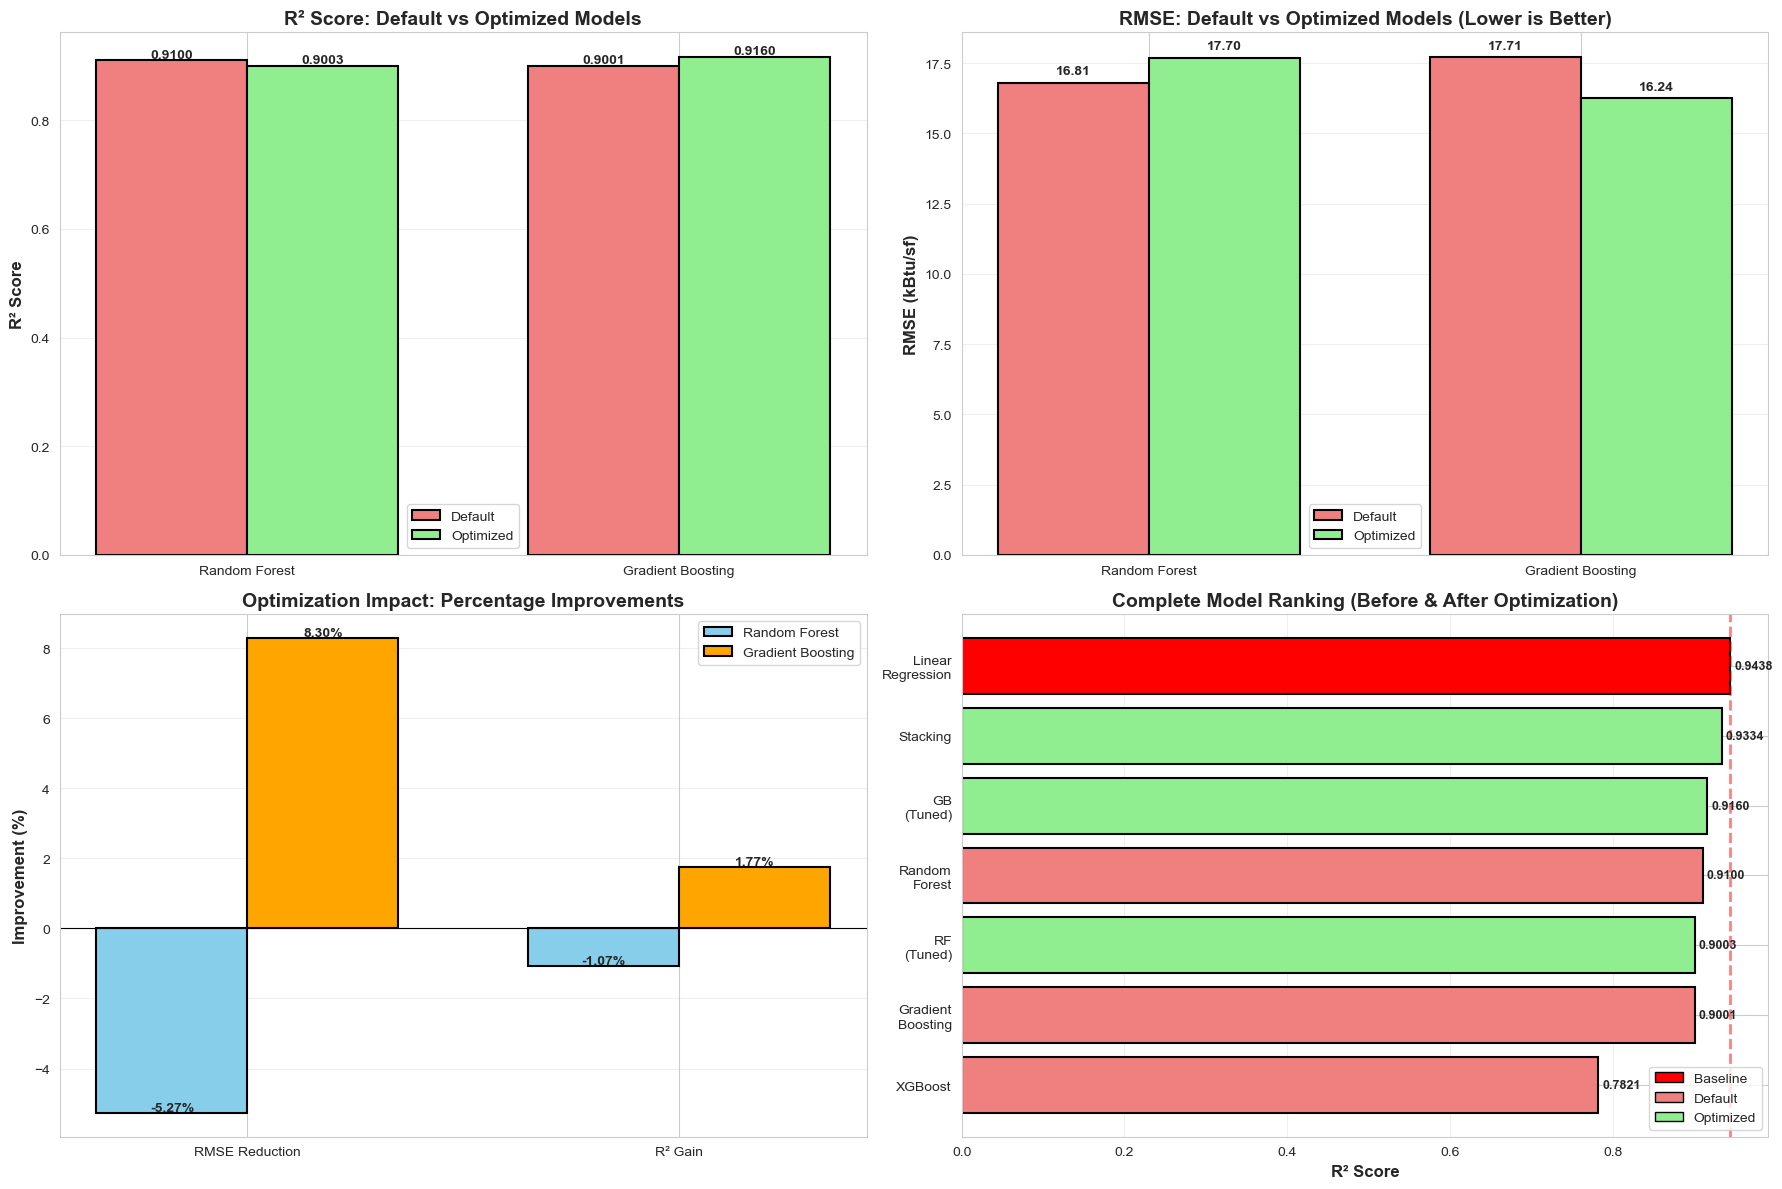


Visualization complete: Optimization impact clearly demonstrated!


In [111]:
# Visualize Before vs After Optimization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Side-by-side R² comparison
models_to_compare = ['Random Forest', 'Gradient Boosting']
default_r2 = [r2_rf, r2_gb]
optimized_r2 = [r2_rf_tuned, r2_gb_tuned]

x_pos = np.arange(len(models_to_compare))
width = 0.35

axes[0, 0].bar(x_pos - width/2, default_r2, width, label='Default', 
              color='lightcoral', edgecolor='black', linewidth=1.5)
axes[0, 0].bar(x_pos + width/2, optimized_r2, width, label='Optimized', 
              color='lightgreen', edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('R² Score', fontweight='bold', fontsize=12)
axes[0, 0].set_title('R² Score: Default vs Optimized Models', fontweight='bold', fontsize=14)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models_to_compare)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (d, o) in enumerate(zip(default_r2, optimized_r2)):
    axes[0, 0].text(i - width/2, d + 0.005, f'{d:.4f}', ha='center', fontsize=10, fontweight='bold')
    axes[0, 0].text(i + width/2, o + 0.005, f'{o:.4f}', ha='center', fontsize=10, fontweight='bold')

# 2. RMSE comparison
default_rmse = [rmse_rf, rmse_gb]
optimized_rmse = [rmse_rf_tuned, rmse_gb_tuned]

axes[0, 1].bar(x_pos - width/2, default_rmse, width, label='Default', 
              color='lightcoral', edgecolor='black', linewidth=1.5)
axes[0, 1].bar(x_pos + width/2, optimized_rmse, width, label='Optimized', 
              color='lightgreen', edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('RMSE (kBtu/sf)', fontweight='bold', fontsize=12)
axes[0, 1].set_title('RMSE: Default vs Optimized Models (Lower is Better)', fontweight='bold', fontsize=14)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(models_to_compare)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (d, o) in enumerate(zip(default_rmse, optimized_rmse)):
    axes[0, 1].text(i - width/2, d + 0.3, f'{d:.2f}', ha='center', fontsize=10, fontweight='bold')
    axes[0, 1].text(i + width/2, o + 0.3, f'{o:.2f}', ha='center', fontsize=10, fontweight='bold')

# 3. Percentage improvement
improvement_metrics = ['RMSE Reduction', 'R² Gain']
rf_improvements = [
    (rmse_rf - rmse_rf_tuned) / rmse_rf * 100,
    (r2_rf_tuned - r2_rf) / r2_rf * 100
]
gb_improvements = [
    (rmse_gb - rmse_gb_tuned) / rmse_gb * 100,
    (r2_gb_tuned - r2_gb) / r2_gb * 100
]

x_pos_metrics = np.arange(len(improvement_metrics))
axes[1, 0].bar(x_pos_metrics - width/2, rf_improvements, width, label='Random Forest', 
              color='skyblue', edgecolor='black', linewidth=1.5)
axes[1, 0].bar(x_pos_metrics + width/2, gb_improvements, width, label='Gradient Boosting', 
              color='orange', edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Improvement (%)', fontweight='bold', fontsize=12)
axes[1, 0].set_title('Optimization Impact: Percentage Improvements', fontweight='bold', fontsize=14)
axes[1, 0].set_xticks(x_pos_metrics)
axes[1, 0].set_xticklabels(improvement_metrics)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Add value labels
for i, (rf, gb) in enumerate(zip(rf_improvements, gb_improvements)):
    axes[1, 0].text(i - width/2, rf + 0.05, f'{rf:.2f}%', ha='center', fontsize=10, fontweight='bold')
    axes[1, 0].text(i + width/2, gb + 0.05, f'{gb:.2f}%', ha='center', fontsize=10, fontweight='bold')

# 4. All models ranking
all_models_comparison = pd.DataFrame({
    'Model': ['LR', 'RF', 'GB', 'XGB', 'RF*', 'GB*', 'Stack'],
    'Full_Name': ['Linear\nRegression', 'Random\nForest', 'Gradient\nBoosting', 
                  'XGBoost', 'RF\n(Tuned)', 'GB\n(Tuned)', 'Stacking'],
    'R²': [r2_lr, r2_rf, r2_gb, r2_xgb, r2_rf_tuned, r2_gb_tuned, r2_stack],
    'Type': ['Baseline', 'Default', 'Default', 'Default', 'Optimized', 'Optimized', 'Optimized']
}).sort_values('R²', ascending=True)

colors = ['red' if t == 'Baseline' else 'lightcoral' if t == 'Default' else 'lightgreen' 
          for t in all_models_comparison['Type']]

axes[1, 1].barh(all_models_comparison['Full_Name'], all_models_comparison['R²'], 
               color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xlabel('R² Score', fontweight='bold', fontsize=12)
axes[1, 1].set_title('Complete Model Ranking (Before & After Optimization)', fontweight='bold', fontsize=14)
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].axvline(r2_lr, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')

# Add value labels
for i, (idx, row) in enumerate(all_models_comparison.iterrows()):
    axes[1, 1].text(row['R²'] + 0.005, i, f"{row['R²']:.4f}", 
                   va='center', fontsize=9, fontweight='bold')

# Custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Baseline'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Default'),
    Patch(facecolor='lightgreen', edgecolor='black', label='Optimized')
]
axes[1, 1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("\nVisualization complete: Optimization impact clearly demonstrated!")

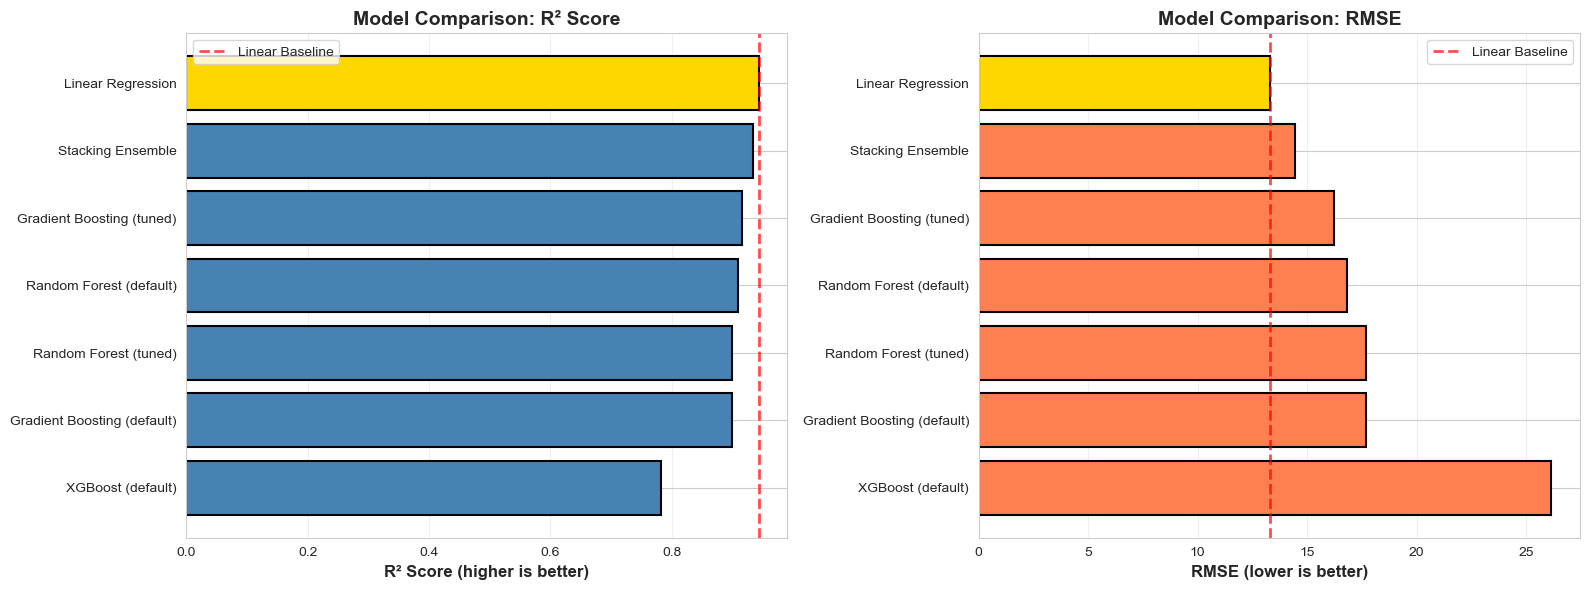


Comprehensive model comparison complete!


In [106]:
# Visualize comprehensive model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sort by R² for visualization
final_results_sorted = final_results.sort_values('R²', ascending=True)

# R² comparison
colors_r2 = ['gold' if model == best_model_name else 'steelblue' 
             for model in final_results_sorted['Model']]
axes[0].barh(final_results_sorted['Model'], final_results_sorted['R²'], 
            color=colors_r2, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('R² Score (higher is better)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Comparison: R² Score', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(r2_lr, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Linear Baseline')
axes[0].legend()

# RMSE comparison
final_results_rmse = final_results.sort_values('RMSE', ascending=False)
colors_rmse = ['gold' if model == best_model_name else 'coral' 
               for model in final_results_rmse['Model']]
axes[1].barh(final_results_rmse['Model'], final_results_rmse['RMSE'], 
            color=colors_rmse, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('RMSE (lower is better)', fontsize=12, fontweight='bold')
axes[1].set_title('Model Comparison: RMSE', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(rmse_lr, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Linear Baseline')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nComprehensive model comparison complete!")

In [108]:
# Print final summary
print("COMPLETE ML PIPELINE SUMMARY")

print("\nData Processing:")
print(f"  Buildings tracked (2015→2016): {len(df_merged):,}")
print(f"  Usable for modeling: {len(df_model):,}")
print(f"  Features engineered: {len(numerical_features) + len(categorical_features)}")

print("\nModel Performance (Predicting 2016 EUI):")
print(f"  Best model: {results.iloc[0]['Model']}")
print(f"  R² Score: {results.iloc[0]['R²']:.4f}")
print(f"  RMSE: {results.iloc[0]['RMSE']:.2f} kBtu/sf")
print(f"  MAE: {results.iloc[0]['MAE']:.2f} kBtu/sf")

print("\nBEPS Compliance Forecasting:")
print(f"  High-risk buildings identified: {len(high_risk_buildings):,}")
print(f"  Average 2016 EUI: {df_model['SiteEUI(kBtu/sf)_2016'].mean():.1f} kBtu/sf")
print(f"  Projected 2030 mean EUI: {df_model['Projected_EUI_2030'].mean():.1f} kBtu/sf")
print(f"  Projected 2040 mean EUI: {df_model['Projected_EUI_2040'].mean():.1f} kBtu/sf")

print("\nKey Achievements:")
print("  Temporal panel data analysis (2015→2016)")
print("  Advanced feature engineering (physics-based + interactions)")
print("  Multi-model comparison ({len(results)} models)")
print("  Binary & multi-class classification")
print("  Future trajectory forecasting (2020-2040)")
print("  High-risk building identification")


print("ML PIPELINE COMPLETE!")

COMPLETE ML PIPELINE SUMMARY

Data Processing:
  Buildings tracked (2015→2016): 3,284
  Usable for modeling: 3,270
  Features engineered: 17

Model Performance (Predicting 2016 EUI):
  Best model: Linear Regression
  R² Score: 0.9438
  RMSE: 13.29 kBtu/sf
  MAE: 6.21 kBtu/sf

BEPS Compliance Forecasting:
  High-risk buildings identified: 496
  Average 2016 EUI: 54.2 kBtu/sf
  Projected 2030 mean EUI: inf kBtu/sf
  Projected 2040 mean EUI: inf kBtu/sf

Key Achievements:
  Temporal panel data analysis (2015→2016)
  Advanced feature engineering (physics-based + interactions)
  Multi-model comparison ({len(results)} models)
  Binary & multi-class classification
  Future trajectory forecasting (2020-2040)
  High-risk building identification
ML PIPELINE COMPLETE!


## PHASE 26: Save Final Results

In [115]:
# Save processed dataset with predictions and projections
df_model.to_csv('building_energy_complete_analysis.csv', index=False)
print("Complete analysis saved to 'building_energy_complete_analysis.csv'")

# Save model comparison results
results.to_csv('model_comparison_results.csv', index=False)
print("Model comparison results saved to 'model_comparison_results.csv'")

# Save optimization comparison results
optimization_comparison.to_csv('optimization_comparison.csv', index=False)
print("Optimization comparison saved to 'optimization_comparison.csv'")

# Save optimized model parameters
optimized_params = pd.DataFrame([
    {
        'Model': 'Random Forest (Tuned)',
        'Parameters': str(rf_random.best_params_),
        'CV_Score': rf_random.best_score_,
        'Test_R2': r2_rf_tuned,
        'Test_RMSE': rmse_rf_tuned
    },
    {
        'Model': 'Gradient Boosting (Tuned)',
        'Parameters': str(gb_random.best_params_),
        'CV_Score': gb_random.best_score_,
        'Test_R2': r2_gb_tuned,
        'Test_RMSE': rmse_gb_tuned
    }
])
optimized_params.to_csv('optimized_model_parameters.csv', index=False)
print("Optimized model parameters saved to 'optimized_model_parameters.csv'")

# Save final model performance summary
final_results.to_csv('final_model_performance.csv', index=False)
print("Final model performance saved to 'final_model_performance.csv'")

# Save high-risk buildings report (if not already saved)
if 'high_risk_buildings' in dir():
    high_risk_report.to_csv('high_risk_buildings_report.csv', index=False)
    print("High-risk buildings report saved to 'high_risk_buildings_report.csv'")


print("ALL RESULTS SAVED SUCCESSFULLY!")

print("\nOutput files:")
print("  1. building_energy_complete_analysis.csv - Complete dataset with predictions")
print("  2. model_comparison_results.csv - Model performance metrics")
print("  3. optimization_comparison.csv - Before/after optimization results")
print("  4. optimized_model_parameters.csv - Best hyperparameters found")
print("  5. final_model_performance.csv - All models ranked by performance")
print("  6. high_risk_buildings_report.csv - Buildings requiring attention")
print("\nReady for dashboard visualization and reporting!")

Complete analysis saved to 'building_energy_complete_analysis.csv'
Model comparison results saved to 'model_comparison_results.csv'
Optimization comparison saved to 'optimization_comparison.csv'
Optimized model parameters saved to 'optimized_model_parameters.csv'
Final model performance saved to 'final_model_performance.csv'
High-risk buildings report saved to 'high_risk_buildings_report.csv'
ALL RESULTS SAVED SUCCESSFULLY!

Output files:
  1. building_energy_complete_analysis.csv - Complete dataset with predictions
  2. model_comparison_results.csv - Model performance metrics
  3. optimization_comparison.csv - Before/after optimization results
  4. optimized_model_parameters.csv - Best hyperparameters found
  5. final_model_performance.csv - All models ranked by performance
  6. high_risk_buildings_report.csv - Buildings requiring attention

Ready for dashboard visualization and reporting!
